In [139]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import SCORERS, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Q1

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### Loading the initial data

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
house.drop(columns ='Id', inplace=True)

### Taking it out all houses that are not residential

In [6]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
house.drop(house[house.MSZoning.str.startswith('C')].index, inplace=True)

In [8]:
house.shape

(1450, 80)

In [9]:
house.head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   
5          50       RL         85.0    14115   Pave   NaN      IR1   
6          20       RL         75.0    10084   Pave   NaN      Reg   
7          60       RL          NaN    10382   Pave   NaN      IR1   
8          50       RM         51.0     6120   Pave   NaN      Reg   
9         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9         0.0        TA        TA     BrkTil       T

In [10]:
# A:
house.describe(include = 'all')

MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1450.000000     1450  1191.000000    1450.000000   1450    89   
unique          NaN        4          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN     1151          NaN            NaN   1446    50   
mean      56.903448      NaN    70.052897   10523.831724    NaN   NaN   
std       42.265033      NaN    24.301013   10012.185355    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7544.500000    NaN   NaN   
50%       50.000000      NaN    70.000000    9496.000000    NaN   NaN   
75%       70.000000      NaN    80.000000   11613.500000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count      1450        1450      1450      1450      1450         1450   
unique        4           4         2         5         3           25   
top         Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq        916        1305      1449      1044      1375          225   
mean        NaN         NaN       NaN       NaN       NaN          NaN   
std         NaN         NaN       NaN       NaN       NaN          NaN   
min         NaN         NaN       NaN       NaN       NaN          NaN   
25%         NaN         NaN       NaN       NaN       NaN          NaN   
50%         NaN         NaN       NaN       NaN       NaN          NaN   
75%         NaN         NaN       NaN       NaN       NaN          NaN   
max         NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1450       1450     1450       1450  1450.000000  1450.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1252       1436     1211        722          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.114483     5.582069   
std           NaN        NaN      NaN        NaN     1.372860     1.107330   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1450.000000   1450.000000      1450     1450        1450        1450   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1135     1424         515         504   
mean    1971.593103   1985.049655       NaN      NaN         NaN         NaN   
std       30.022696     20.552319       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2001.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1442  1442.000000      1450      1450       1450     1413   
unique          4          NaN         4         5          6        4   
top          None          NaN        TA        TA      PConc       TA   
freq          854          NaN       899      127

### Working with the features that are fixed only

In [11]:
house.columns 


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
fixed_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','BsmtFinSF2',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual','BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'PoolArea', 
        'ScreenPorch','MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice']

In [13]:
house_fixed = house.loc[:, fixed_cols].copy()

In [14]:
house_fixed.shape

(1450, 53)

### Checking all the values of the columns

In [15]:
remove_features = []
for col in house_fixed.columns: 
    if house_fixed[col].value_counts(dropna=False).iloc[0]/house_fixed[col].value_counts(dropna=False).sum() > 0.90:
        print(house_fixed[col].value_counts(dropna=False),'-------------------------', sep='\n')
        remove_features.append(col)
remove_features

Pave    1446
Grvl       4
Name: Street, dtype: int64
-------------------------
NaN     1361
Grvl      50
Pave      39
Name: Alley, dtype: int64
-------------------------
Gtl    1375
Mod      62
Sev      13
Name: LandSlope, dtype: int64
-------------------------
Norm      1436
Feedr        5
PosN         2
Artery       2
RRNn         2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64
-------------------------
0      1425
80        3
360       2
371       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
572       1
528       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64
-------------------------
0    1369
1      79
2       2
Name: BsmtHalfBath, dtype: int64
-------------------------
1    1383
2      64
3       2
0       1
Name: KitchenAbvGr, dtype: int64
-------------------------
Typ     1350
Min2      34
Min1      31

['Street',
 'Alley',
 'LandSlope',
 'Condition2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 '3SsnPorch',
 'PoolArea',
 'ScreenPorch',
 'MiscFeature',
 'MiscVal']

In [16]:
#Removing the all columns with more than 90% of the same values 
house_fixed.drop(labels = remove_features, axis = 1, inplace=True)

### Dealing with Null values and correlation heatmap

In [17]:
house_fixed.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
BsmtFinSF2         0
HouseStyle         0
YearBuilt          0
YearRemodAdd       0
Foundation         0
BsmtQual          37
BsmtExposure      38
BsmtFinSF1         0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageType        79
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
dtype: int64

In [18]:
house_fixed.groupby('MSSubClass')['LotFrontage'].skew()

MSSubClass
20     3.791228
30     2.917737
40     0.000000
45    -0.161602
50     2.337122
60     4.270146
70     2.244904
75     1.951314
80     0.372845
85     0.206461
90     0.267385
120    0.428336
160    2.744447
180    1.035098
190    0.758657
Name: LotFrontage, dtype: float64

In [19]:
house_fixed.LotFrontage = house_fixed.groupby('MSSubClass')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

There was one entry where there might have been a mistake where the basement quality was 'Gd' but basement exposure
was listed as null. Generally if basement quality is Null (meaning no basement), the basement exposure is null too except for one entry. For a basement quality of 'Gd', the most frequent value for basement exposure is 'No' (No exposure) so I replaced the incorrect null value with this.

In [20]:
mistake = house_fixed[~house_fixed.BsmtQual.isnull() & house_fixed.BsmtExposure.isnull()].index
house_fixed.loc[mistake, 'BsmtExposure'] = house_fixed[house_fixed.BsmtQual == 'Gd']['BsmtExposure'].value_counts().index[0]

Replacing all the null values of the basement quality, basement exposure and garage type to 'NoB' and 'NoG'. 

In [21]:
house_fixed.BsmtQual.fillna('NoB', inplace=True) 
house_fixed.BsmtExposure.fillna('NoB', inplace=True) 
house_fixed.GarageType.fillna('NoG', inplace=True) 

For the Garage Year Built, some of the values are null where there is no Garage. With try a few methods such as matching the year the house was built, factorizing and setting them to 0 and see which one returns the best score before choosing.

Before that some of the values are entered incorrectly as there are some entries where the garage was entered as being built before the house. So I corrected these to match the year the house was built for the built in garages but left the detached garages. 

In [22]:
mistakes = house_fixed[(house_fixed.GarageYrBlt < house_fixed.YearBuilt) & 
                       (house_fixed.GarageType == 'BuiltIn')].index

house_fixed.loc[mistakes, 'GarageYrBlt'] = house_fixed.YearBuilt

In [23]:
#house_fixed[house_fixed.GarageYrBlt < house_fixed.YearBuilt].index
#house_fixed.loc[house_fixed[house_fixed.GarageYrBlt < house_fixed.YearBuilt].index, 'GarageYrBlt'] = house_fixed.YearBuilt
#house_fixed['GarageYrBlt_new'] = house_fixed.GarageYrBlt.factorize(sort=True)[0]
#garage_ref = house_fixed[['GarageYrBlt','GarageYrBlt_new']].sort_values(by= 'GarageYrBlt')
#house_fixed.pop('GarageYrBlt')

In [24]:
house_fixed.loc[house_fixed[house_fixed.GarageYrBlt.isnull()].index, 'GarageYrBlt'] = house_fixed.YearBuilt

### Correlation map

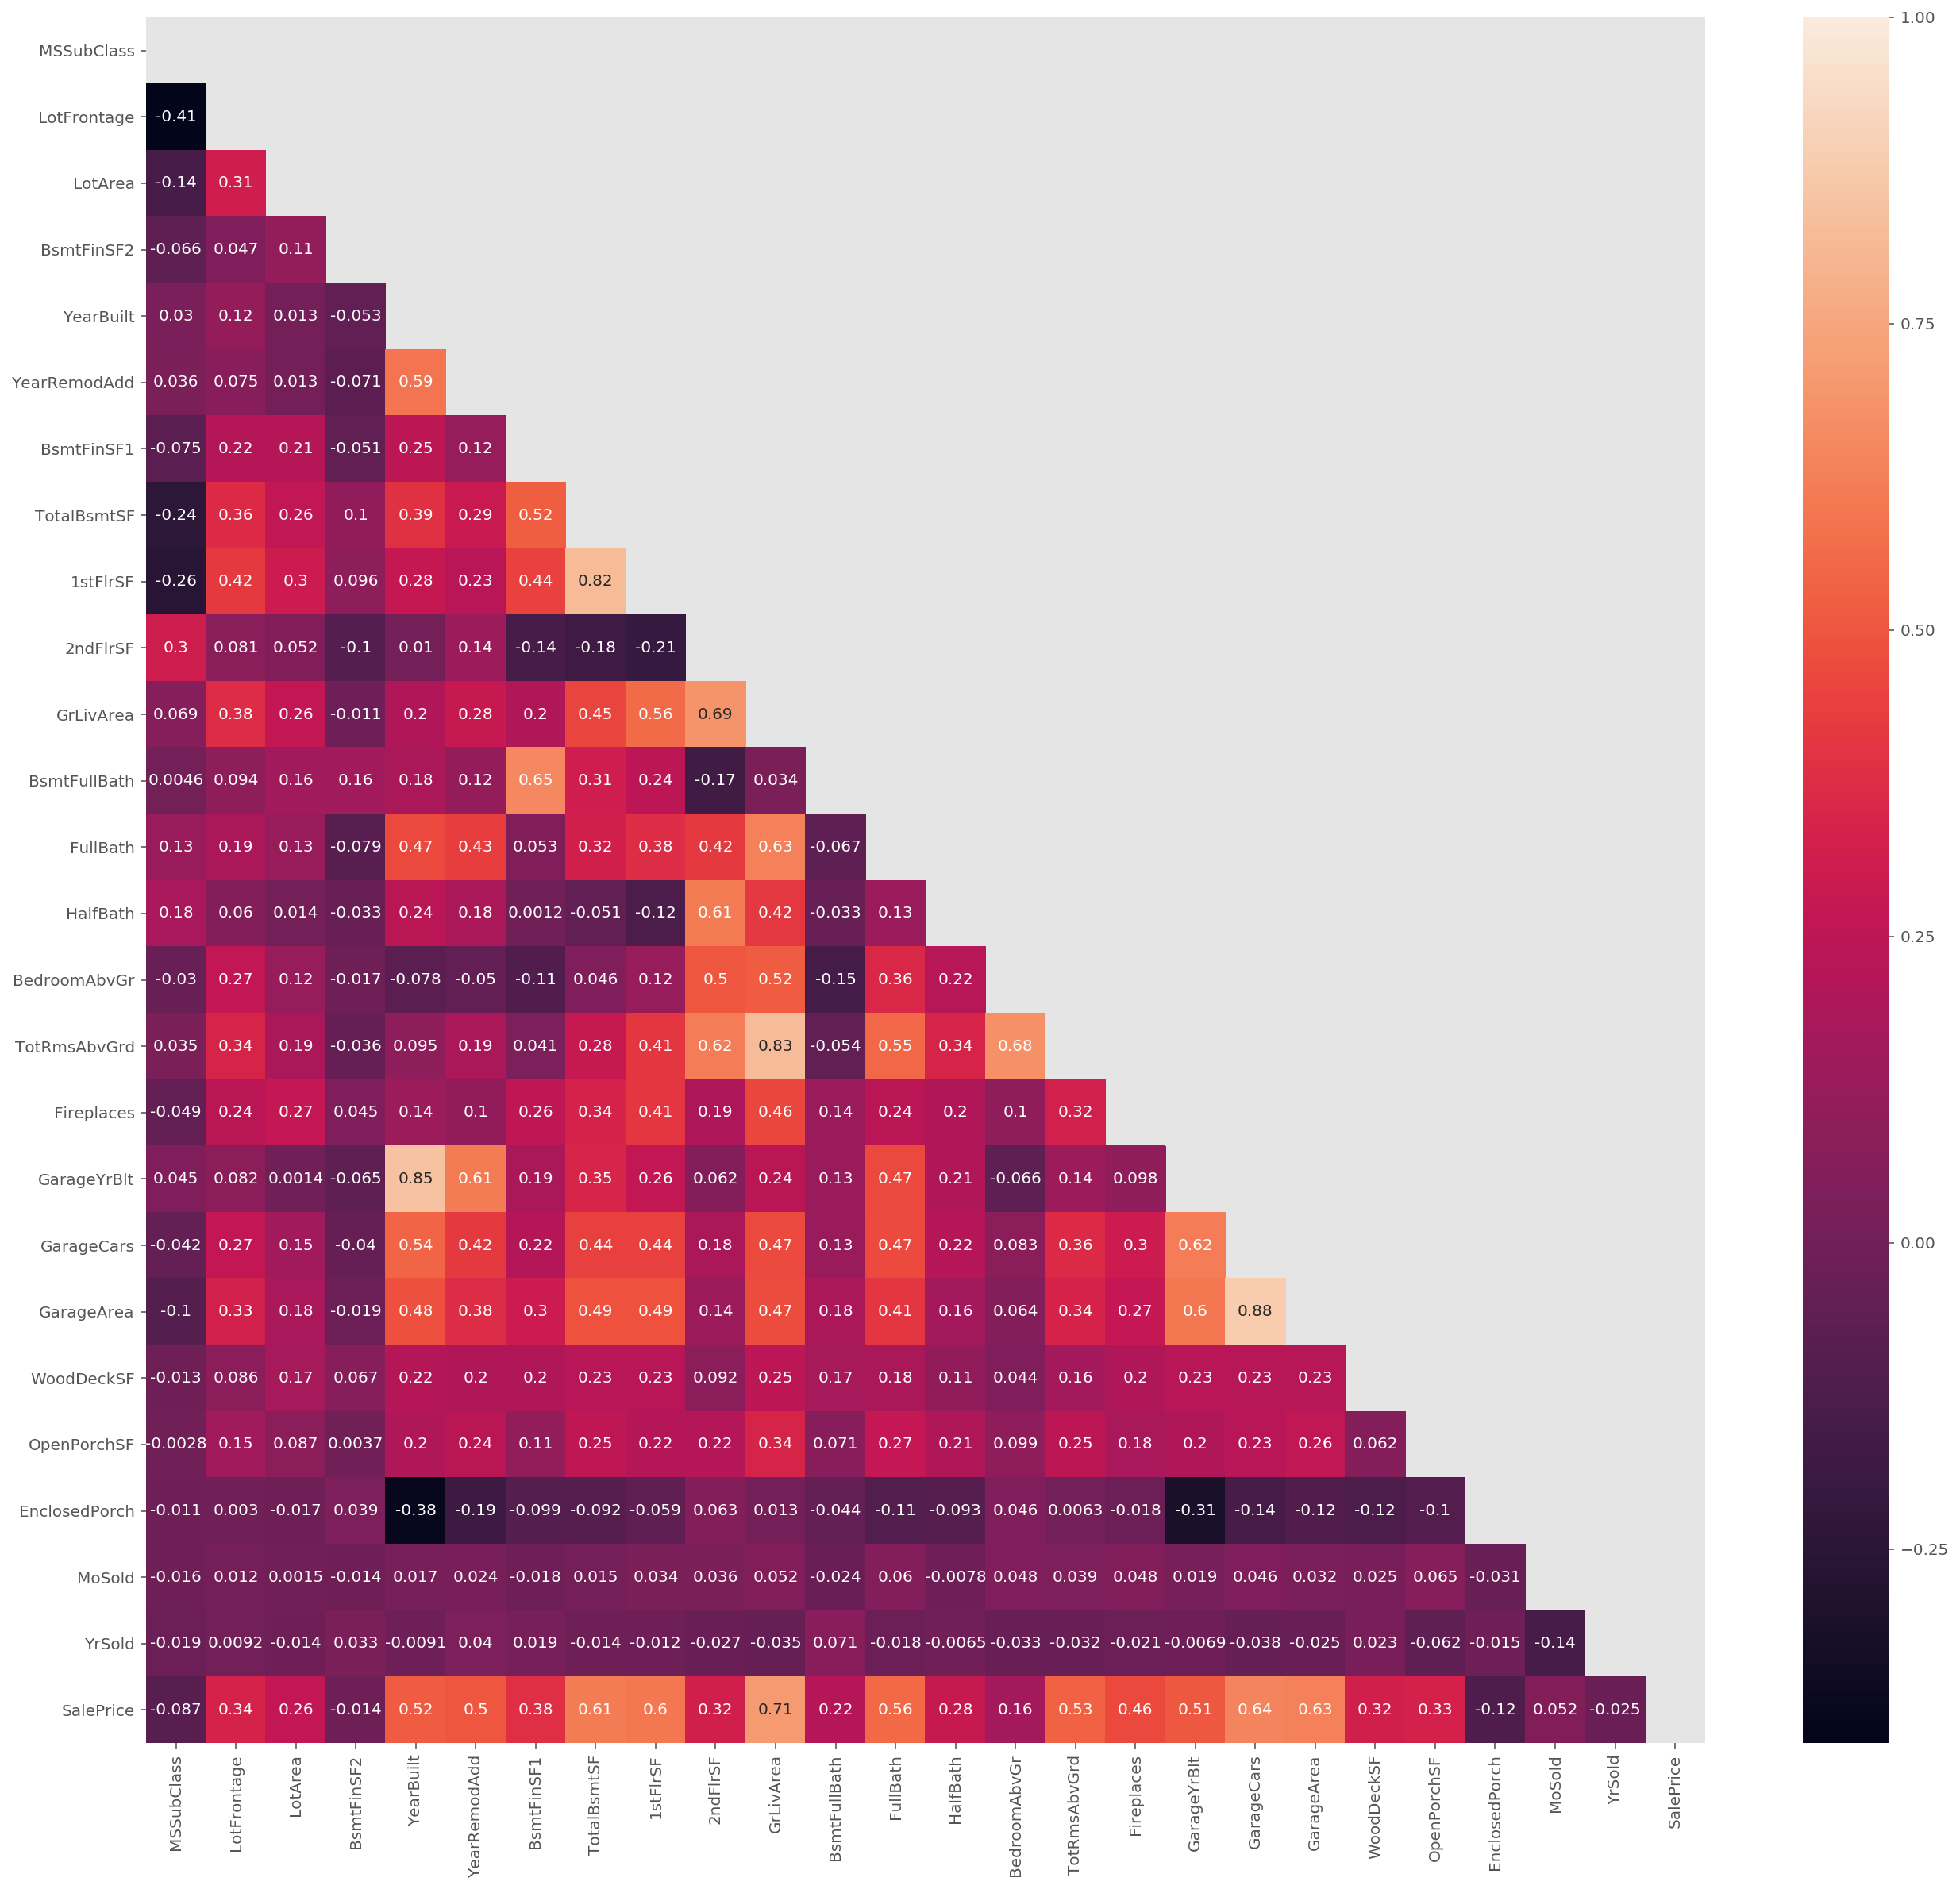

In [25]:
house_fxd_corr = house_fixed.corr()
fig, ax = plt.subplots(figsize=(22, 20))
mask = np.zeros_like(house_fxd_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(house_fxd_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([house_fxd_corr.shape[1], 0])
plt.show()

In [26]:
house_fixed.columns 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'BsmtFinSF2', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],
      dtype='object')

### Feature Engineering: Choosing variables to factorize:


In [27]:
house_fixed.select_dtypes(include='object').columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

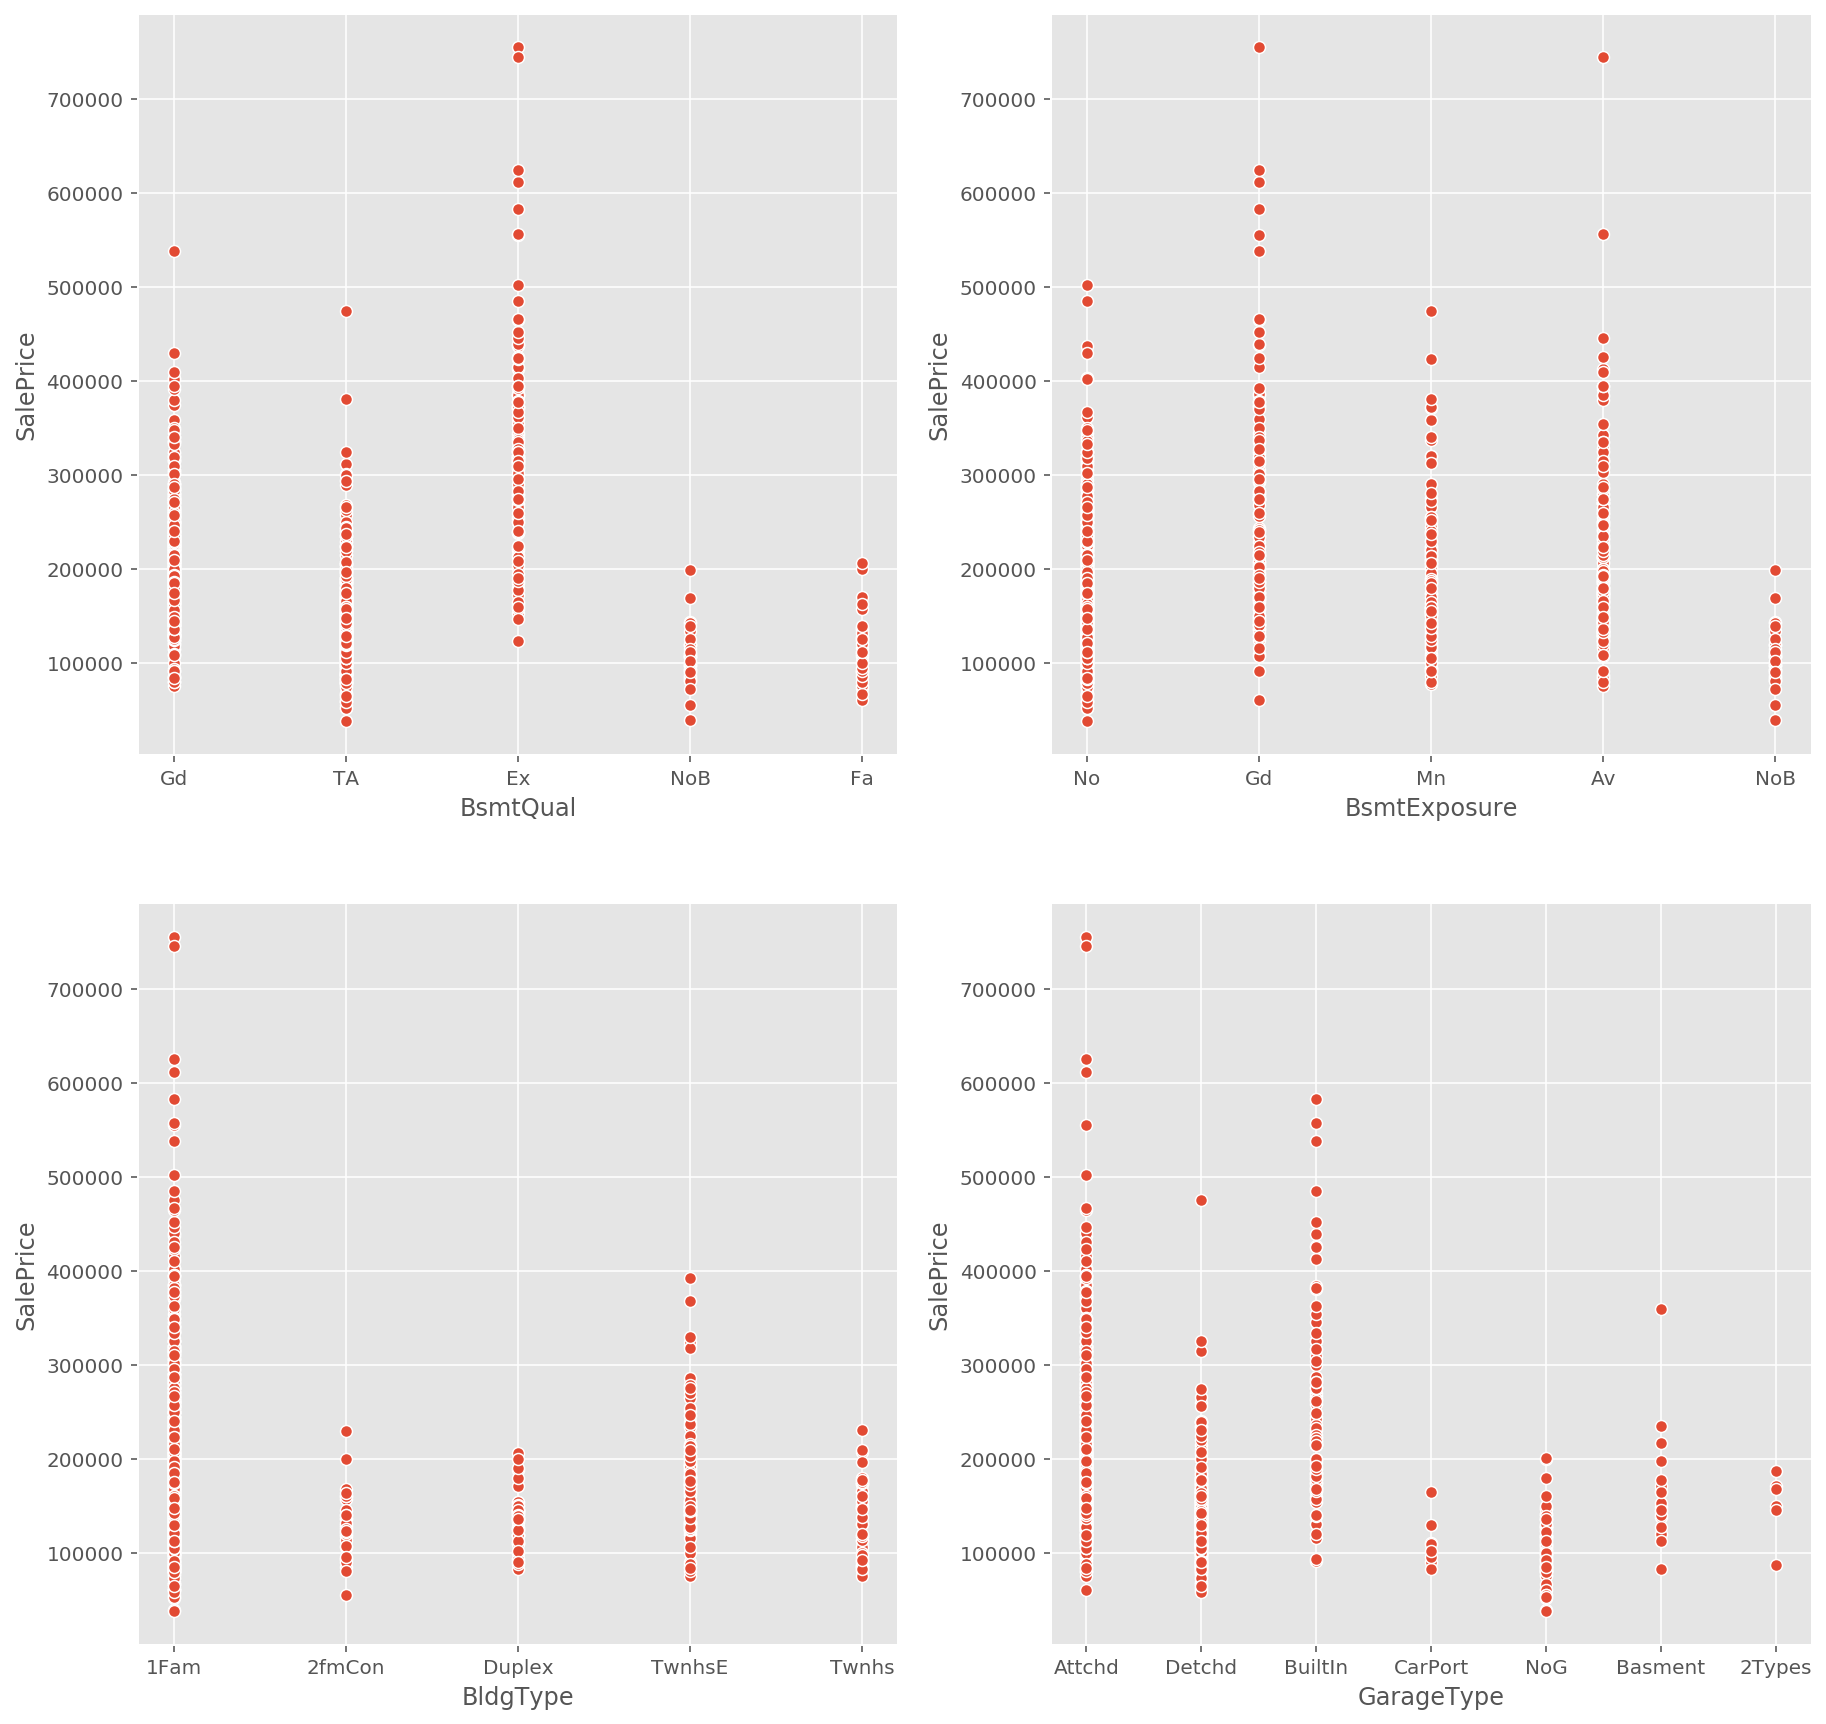

In [28]:
fig1, ax1 = plt.subplots(nrows=2, ncols =2, figsize=(15,15))
sns.scatterplot(house_fixed.BsmtQual, house_fixed.SalePrice, ax = ax1[0,0])
ax1[0,1]=sns.scatterplot(house_fixed.BsmtExposure, house_fixed.SalePrice, ax = ax1[0,1])
ax1[1,0]=sns.scatterplot(house_fixed.BldgType, house_fixed.SalePrice, ax = ax1[1,0])
ax1[1,1]=sns.scatterplot(house_fixed.GarageType, house_fixed.SalePrice, ax = ax1[1,1])
plt.show()

In [29]:
"""house_fixed.BldgType = house_fixed.BldgType.map({'1Fam': 5, '2fmCon':4, 'Duplex':3, 
                          'TwnhsE':2, 'Twnhs':1})

house_fixed.BsmtQual = house_fixed.BsmtQual.map({'Ex': 6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'NoB':1})

house_fixed.GarageType = house_fixed.GarageType.map({'2Types': 7, 'Attchd': 6, 'Basment': 5, 'BuiltIn': 4, 
                                                    'CarPort':3, 'Detchd':2, 'NoG':1 })

house_fixed.head(10)"""


house_fixed.BsmtExposure = house_fixed.BsmtExposure.map({'Gd':25, 'Av':16, 'Mn':9, 'No':4, 'NoB':1})

### Interaction Elements

Seeing as Total Basement square feet and ground floor living area seem to influence the price a lot, I decided to add together total basement sqft, ground, first and second floor sqft area for an interaction variable. Seeing as bathrooms also influence this, will add together bathrooms and then bathrooms and bedrooms - I never actually got around to doing this. 

In [30]:
house_fixed['total_sqft'] = house_fixed.GrLivArea + house_fixed['1stFlrSF'] + house_fixed['2ndFlrSF'] + house_fixed.TotalBsmtSF

In [31]:
house_fixed.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis=1, inplace=True)

In [32]:
house_fixed.drop('TotRmsAbvGrd', axis=1, inplace=True)
#Since its very correlated to total_sqft

In [33]:
house_fixed.drop(['BsmtFinSF2','BsmtFinSF1'], axis=1, inplace=True)

In [34]:
house_fixed.columns 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice', 'total_sqft'],
      dtype='object')

### Picking Dummy variables

In [35]:
to_dummify = list(house_fixed.select_dtypes(include = 'object').columns)
to_dummify += ['MSSubClass']
to_dummify

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'BsmtQual',
 'GarageType',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

### Checking for skew

In [36]:
house_fixed.skew()

MSSubClass        1.400206
LotFrontage       2.126584
LotArea          12.176209
YearBuilt        -0.626327
YearRemodAdd     -0.514579
BsmtExposure      1.413119
BsmtFullBath      0.588015
FullBath          0.037417
HalfBath          0.668103
BedroomAbvGr      0.211170
Fireplaces        0.641780
GarageYrBlt      -0.691990
GarageCars       -0.342681
GarageArea        0.162739
WoodDeckSF        1.532311
OpenPorchSF       2.233622
EnclosedPorch     3.141910
MoSold            0.219567
YrSold            0.098347
SalePrice         1.908416
total_sqft        1.639696
dtype: float64

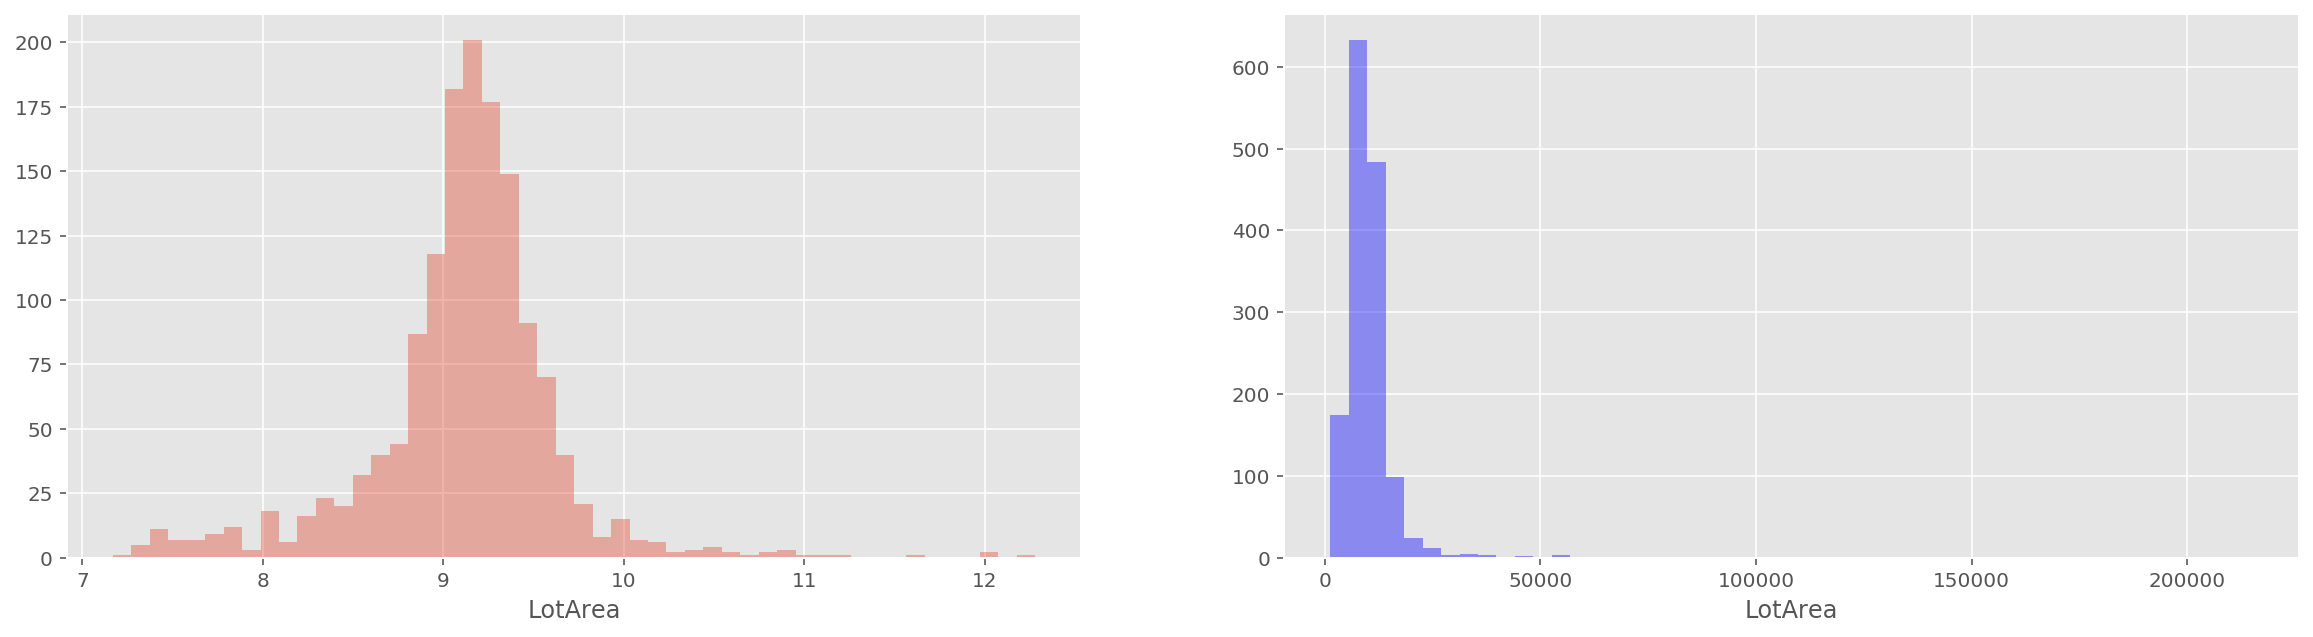

In [37]:
fig, ax = plt.subplots(ncols = 2, figsize= (20, 5))
sns.distplot(np.log(house_fixed.LotArea), kde=False, ax = ax[0])
sns.distplot(house_fixed.LotArea, kde=False, color ='b', ax= ax[1])

In [38]:
house_fixed.LotArea = np.log(house_fixed.LotArea)

### Adjust the Distribution of Y (Sale Price)

In [39]:
from scipy.stats import boxcox

new_y = np.log(house_fixed.SalePrice)

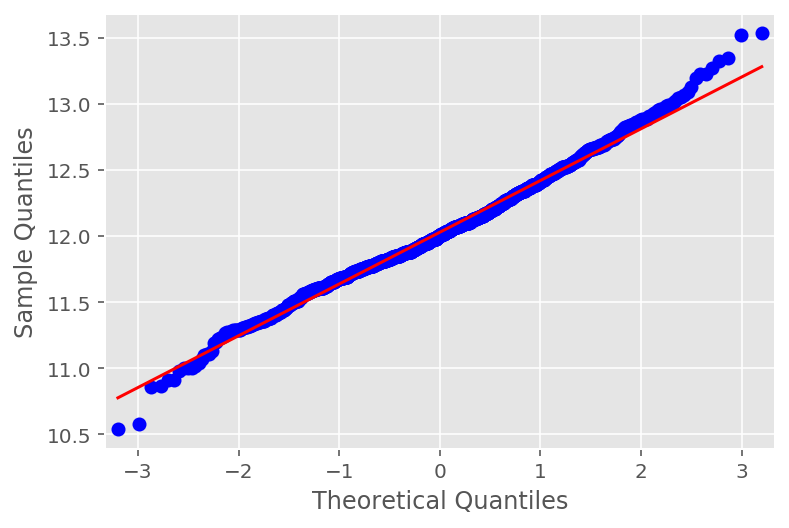

In [40]:
import statsmodels.api as sm 
sm.qqplot(new_y, line='s');

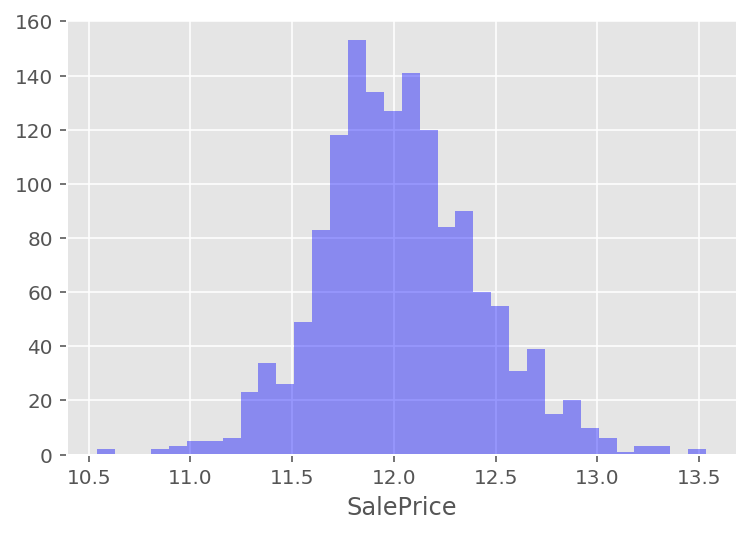

In [41]:
sns.distplot(new_y, kde=False, color ='b')

### Dummifying variables

In [42]:
house_fixed_dum = pd.get_dummies(house_fixed, columns = to_dummify, drop_first = True)

In [43]:
house_fixed_dum.head(15)
house_fixed_dum.shape

(1450, 118)

### Splitting the data

In [44]:
X_pre_2010 = house_fixed_dum[house_fixed_dum.YrSold < 2010]
#y_pre_2010 = boxcox(X_pre_2010.pop('SalePrice'))[0]
#y_pre_2010 = X_pre_2010.pop('SalePrice')
y_pre_2010 = np.log(X_pre_2010.pop('SalePrice'))
X_post_2010 = house_fixed_dum[house_fixed_dum.YrSold >= 2010]
#y_post_2010 = boxcox(X_post_2010.pop('SalePrice'))[0]
#y_post_2010 = X_post_2010.pop('SalePrice')
y_post_2010 = np.log(X_post_2010.pop('SalePrice'))

In [45]:
X_pre_2010.shape, X_post_2010.shape, y_pre_2010.shape, y_post_2010.shape

((1278, 117), (172, 117), (1278,), (172,))

### Scaling the data

In [46]:
scaler = StandardScaler()
X_pre_std = pd.DataFrame(scaler.fit_transform(X_pre_2010), index = X_pre_2010.index, columns = X_pre_2010.columns)
X_post_std = pd.DataFrame(scaler.transform(X_post_2010), index = X_post_2010.index, columns = X_post_2010.columns)

### KFold for shuffling train data

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

### **Linear Regression**

In [48]:
linreg = LinearRegression()
linreg.fit(X_pre_std, y_pre_2010)

train_score = linreg.score(X_pre_std, y_pre_2010)
test_score = linreg.score(X_post_std, y_post_2010)

#Cross Validation 
cv_score = cross_val_score(linreg, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {linreg.intercept_}')
print(f'Model coeff: {linreg.coef_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-2.20907335e-02  3.60391343e-02  3.96390177e-02  5.26183166e-02
  2.24688628e-02  2.71932328e-02  3.28950302e-02  2.69744107e-02
  9.88773604e-03  3.27824829e-02 -7.67892342e-03  4.60931568e-02
  8.45648399e-03  9.67301633e-03  8.55294801e-03  5.73075929e-03
  3.77253342e-03 -7.48584911e-03  1.13279309e-01 -3.14319806e-03
 -1.21907336e-02 -2.10831013e-02  9.38697251e-03 -1.01301531e-02
  3.75427967e-03  1.22855629e-02 -2.18411222e-04  1.40594933e-02
  5.62056125e-03 -1.20223765e-02 -4.62986931e-03 -8.71284591e-04
  6.62962055e-04 -8.08631694e-04 -2.12243482e-03 -4.37302720e-03
 -1.05852702e-02  2.02123110e-02 -3.47517270e-02 -1.55827209e-02
 -8.37251477e-03 -1.78829535e-02 -1.97204447e-02 -1.80888663e-02
  1.32247659e-03 -1.01559253e-02  2.23819306e-02  3.07795292e-02
 -2.33036072e-02 -8.69095189e-03 -1.79705728e-02 -2.36026465e-03
  1.40738311e-02  2.40974794e-02 -2.76314142e-03  5.90911383e-03
 -3.33218374e-03  1.52175578e-02  8.44817

#### Visualising coefficients - LinReg

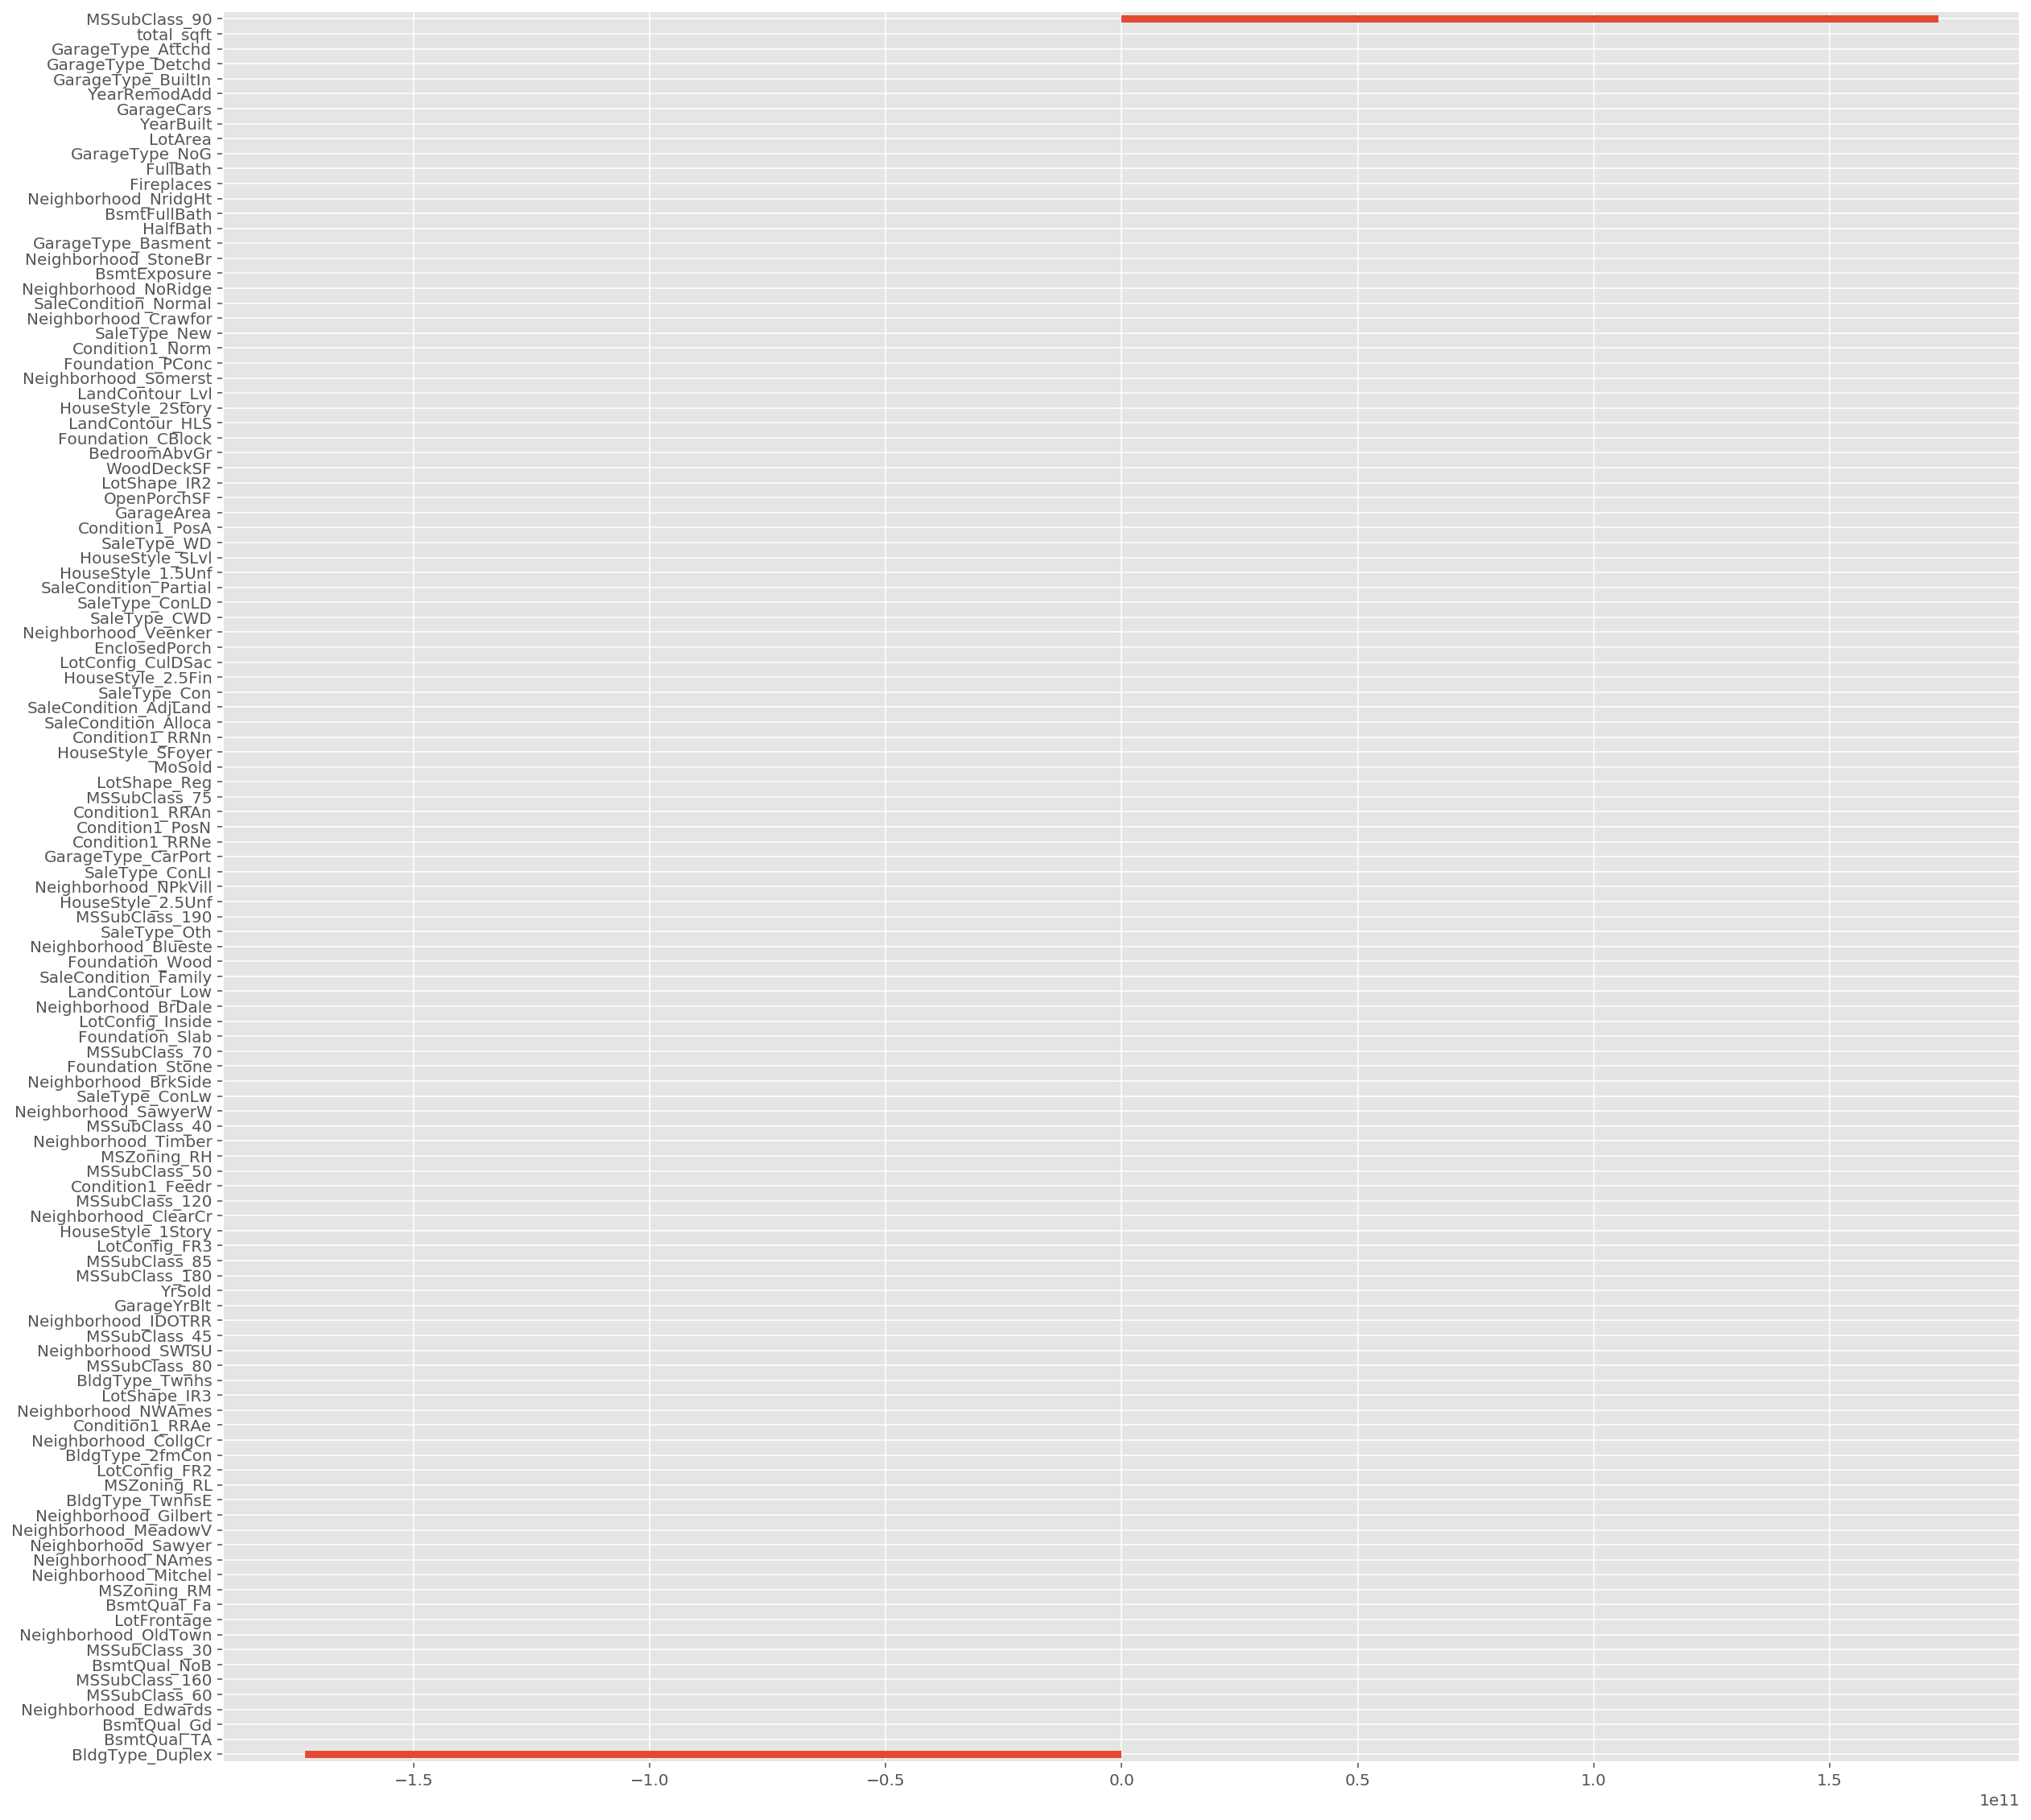

In [49]:
coef_linreg = pd.DataFrame(linreg.coef_, index=X_pre_std.columns,
                       columns=['coef_linreg'])
coef_linreg['coef_linreg_abs'] = coef_linreg.coef_linreg.abs()

plt.figure(figsize = (20,20))
coef_linreg['coef_linreg'].sort_values().plot(kind='barh');

### **Lasso CV**

In [50]:
lassoCV = LassoCV(alphas = np.logspace(-4, 4, 100), cv=kf)
lassoCV.fit(X_pre_std, y_pre_2010)

train_score = lassoCV.score(X_pre_std, y_pre_2010)
test_score = lassoCV.score(X_post_std, y_post_2010)

#Cross Validation 
lasso = Lasso(alpha=lassoCV.alpha_)
cv_score = cross_val_score(lasso, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {lassoCV.intercept_}')
print(f'Model coeff: {lassoCV.coef_}')
print(f'Model alpha: {lassoCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-1.00395568e-02  3.15696338e-02  3.50169610e-02  5.46351411e-02
  2.27406176e-02  2.54876368e-02  2.72497104e-02  1.88393215e-02
  3.37485651e-03  3.41788761e-02  0.00000000e+00  5.04689439e-02
  0.00000000e+00  1.01741312e-02  6.69223663e-03  3.05571633e-04
  2.06699424e-03 -3.70800789e-03  1.23564869e-01 -0.00000000e+00
  0.00000000e+00 -1.27663543e-02  5.78016572e-03 -1.11323251e-02
  0.00000000e+00  7.33551102e-03 -0.00000000e+00  8.78048997e-03
  6.64325892e-03 -7.10318176e-03 -1.40760196e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.87235344e-03 -0.00000000e+00
  0.00000000e+00  2.76623932e-02 -2.12541051e-02 -8.17124692e-03
 -0.00000000e+00 -1.39022729e-02 -1.14931732e-02 -7.84136041e-05
  1.53212094e-04 -0.00000000e+00  2.32954831e-02  3.77826505e-02
 -8.94699595e-03 -0.00000000e+00 -6.25913579e-03  8.98892253e-04
  2.39339748e-02  2.60631225e-02  2.59449669e-03  7.83491476e-03
 -3.84192118e-03  1.12190628e-02  4.10125

#### Visualising the coefficients

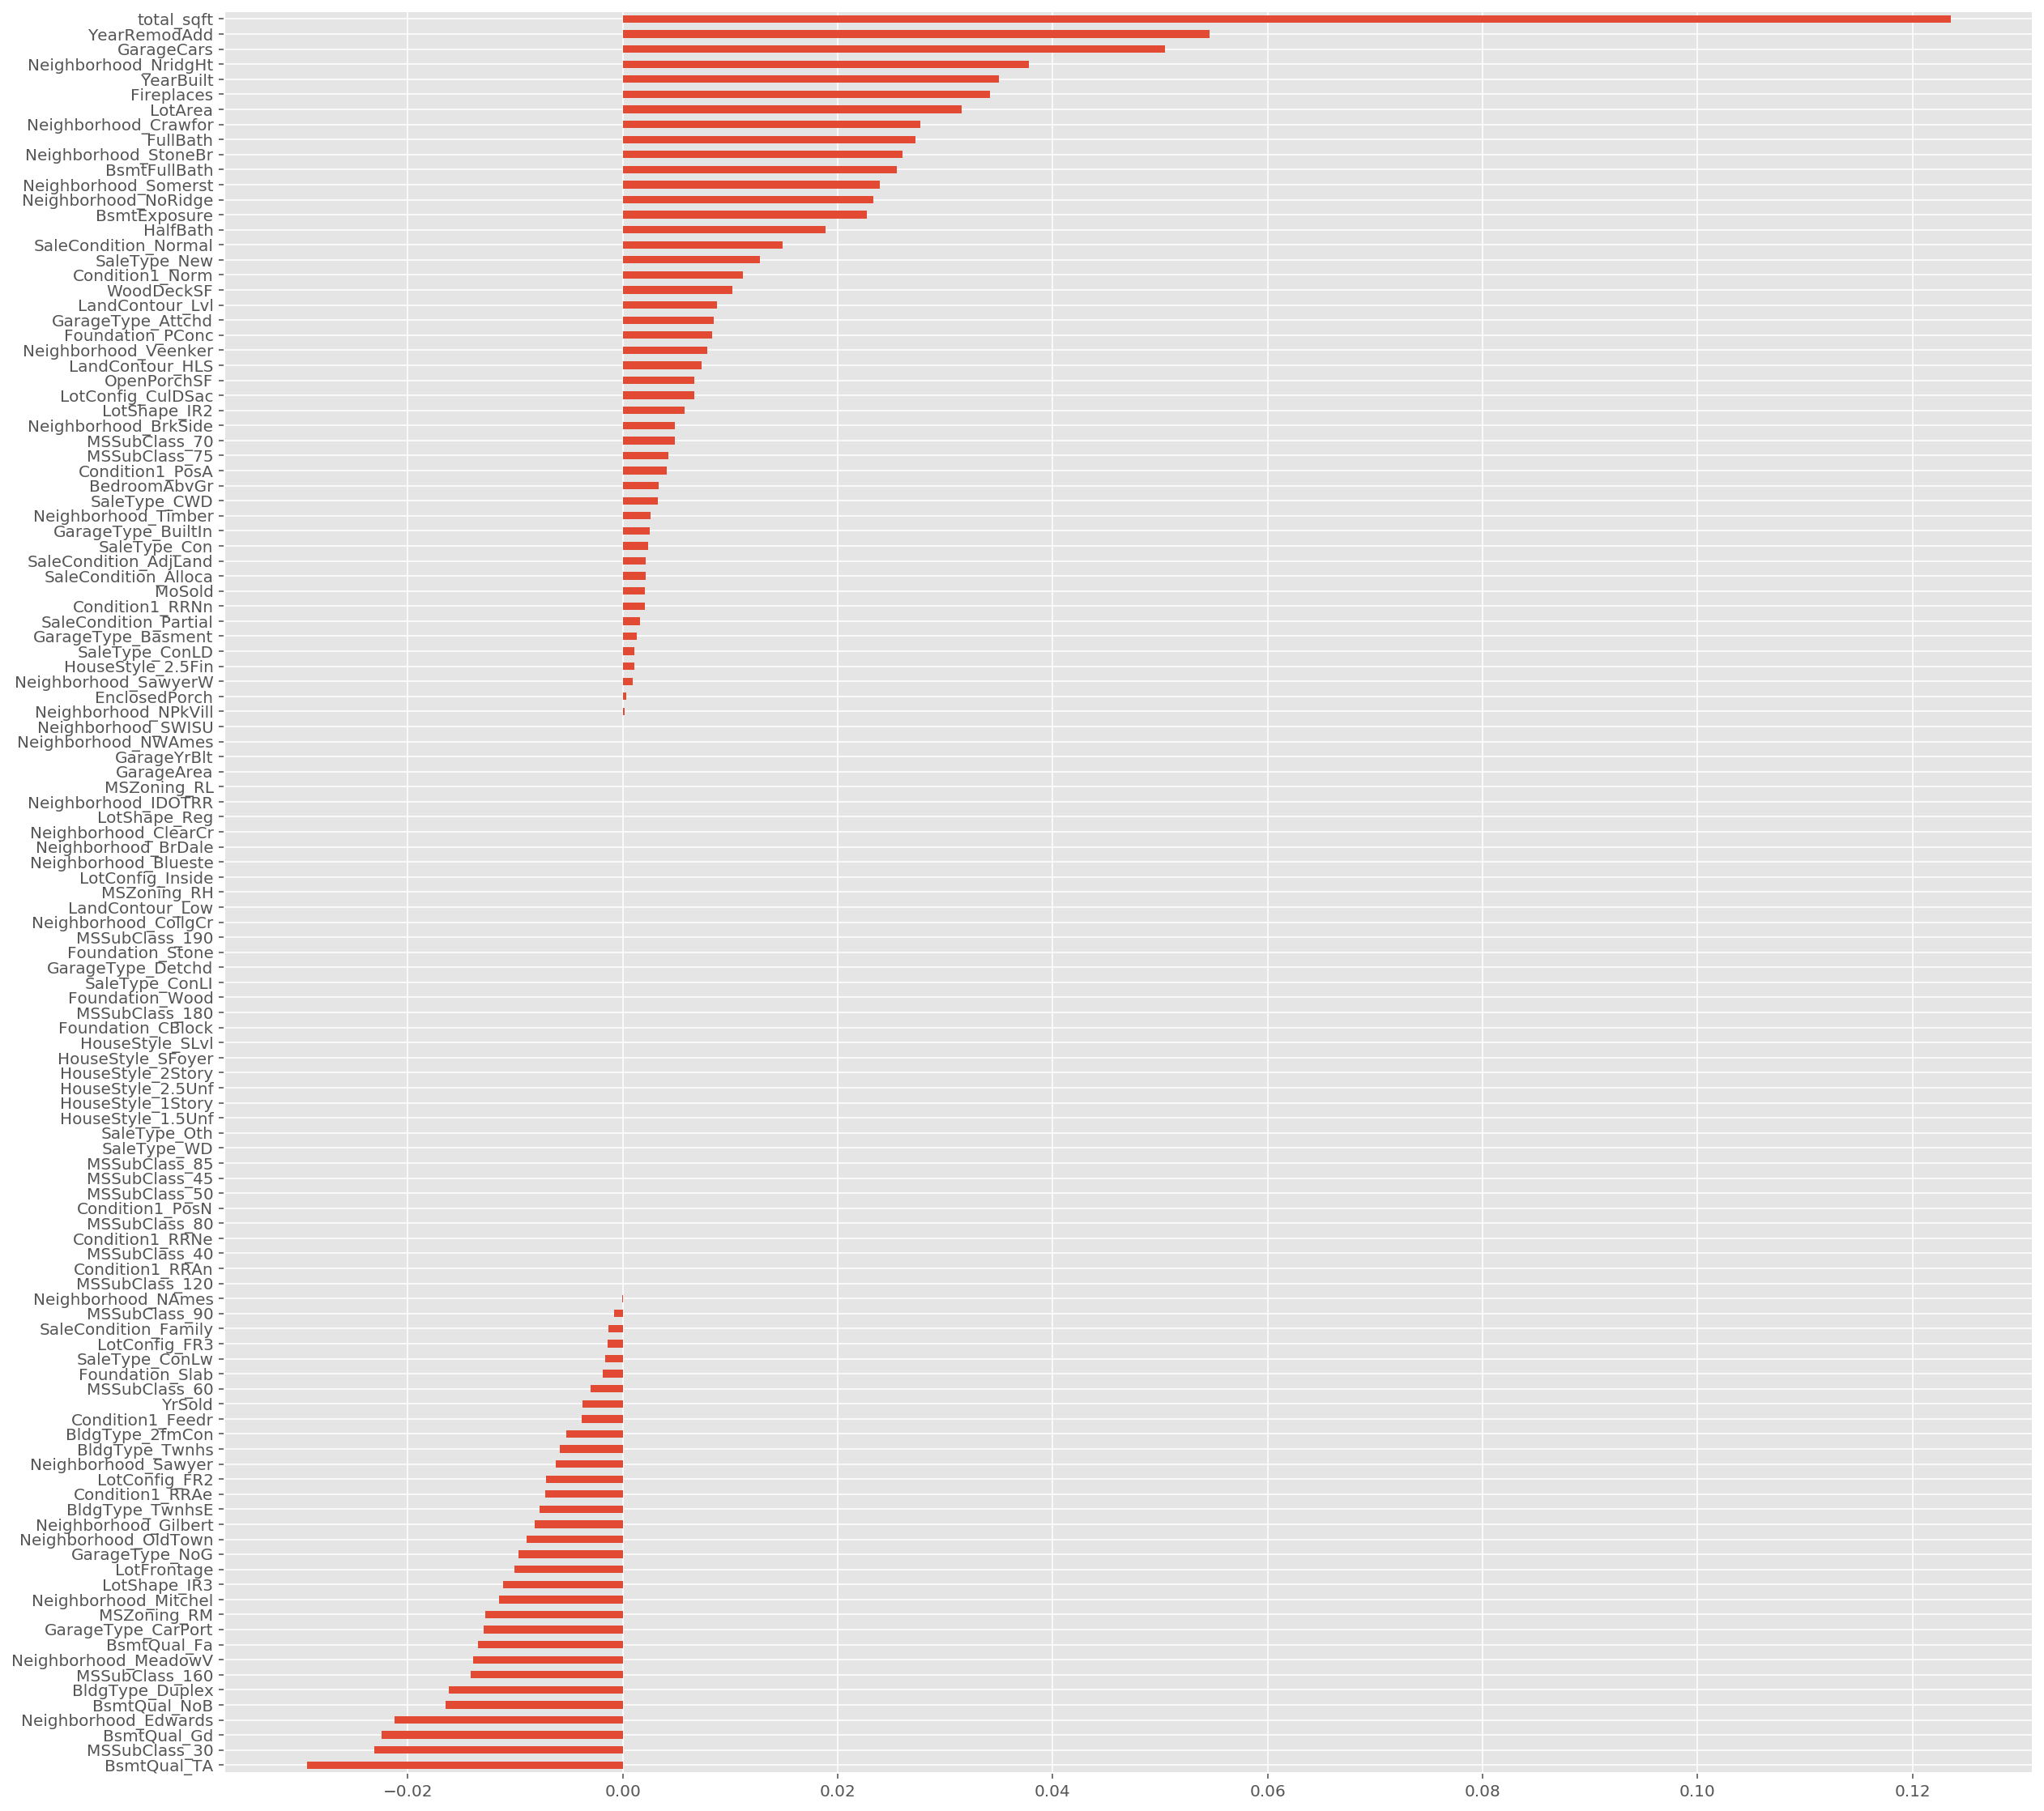

In [51]:
coef_lasso = pd.DataFrame(lassoCV.coef_, index=X_pre_std.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso'].sort_values().plot(kind='barh');

#### Cutting down the coefficients

In [52]:
coef_lasso.sort_values(by='coef_lasso_abs')

coef_lasso  coef_lasso_abs
MSSubClass_190          -0.000000        0.000000
LandContour_Low         -0.000000        0.000000
Condition1_RRAn          0.000000        0.000000
Neighborhood_Blueste     0.000000        0.000000
Neighborhood_BrDale      0.000000        0.000000
GarageType_Detchd       -0.000000        0.000000
Neighborhood_ClearCr    -0.000000        0.000000
Neighborhood_CollgCr     0.000000        0.000000
Foundation_Wood         -0.000000        0.000000
Neighborhood_IDOTRR     -0.000000        0.000000
Foundation_Stone        -0.000000        0.000000
Neighborhood_NWAmes     -0.000000        0.000000
Foundation_CBlock       -0.000000        0.000000
HouseStyle_SLvl          0.000000        0.000000
HouseStyle_SFoyer        0.000000        0.000000
Neighborhood_SWISU      -0.000000        0.000000
HouseStyle_2Story       -0.000000        0.000000
HouseStyle_2.5Unf        0.000000        0.000000
HouseStyle_1Story        0.000000        0.000000
HouseStyle_1.5Unf       -0.000000        0.000000
MSSubClass_180          -0.000000        0.000000
Condition1_PosN         -0.000000        0.000000
SaleType_ConLI          -0.000000        0.000000
LotShape_Reg             0.000000        0.000000
LotConfig_Inside         0.000000        0.000000
SaleType_Oth            -0.000000        0.000000
MSSubClass_120          -0.000000        0.000000
MSSubClass_85           -0.000000        0.000000
MSSubClass_80            0.000000        0.000000
MSSubClass_50            0.000000        0.000000
MSSubClass_45           -0.000000        0.000000
MSSubClass_40           -0.000000        0.000000
GarageYrBlt              0.000000        0.000000
GarageArea               0.000000        0.000000
Condition1_RRNe          0.000000        0.000000
MSZoning_RL              0.000000        0.000000
MSZoning_RH             -0.000000        0.000000
SaleType_WD              0.000000        0.000000
Neighborhood_NAmes      -0.000078        0.000078
Neighborhood_NPkVill     0.000153        0.000153
EnclosedPorch            0.000306        0.000306
MSSubClass_90           -0.000810        0.000810
Neighborhood_SawyerW     0.000899        0.000899
HouseStyle_2.5Fin        0.001052        0.001052
SaleType_ConLD           0.001113        0.001113
GarageType_Basment       0.001341        0.001341
SaleCondition_Family    -0.001358        0.001358
LotConfig_FR3           -0.001408        0.001408
SaleCondition_Partial    0.001582        0.001582
SaleType_ConLw          -0.001651        0.001651
Foundation_Slab         -0.001859        0.001859
Condition1_RRNn          0.002067        0.002067
MoSold                   0.002067        0.002067
SaleCondition_Alloca     0.002108        0.002108
SaleCondition_AdjLand    0.002110        0.002110
SaleType_Con             0.002379        0.002379
GarageType_BuiltIn       0.002485        0.002485
Neighborhood_Timber      0.002594        0.002594
MSSubClass_60           -0.002965        0.002965
SaleType_CWD             0.003248        0.003248
BedroomAbvGr             0.003375        0.003375
YrSold                  -0.003708        0.003708
Condition1_Feedr        -0.003842        0.003842
Condition1_PosA          0.004101        0.004101
MSSubClass_75            0.004248        0.004248
MSSubClass_70            0.004872        0.004872
Neighborhood_BrkSide     0.004872        0.004872
BldgType_2fmCon         -0.005269        0.005269
LotShape_IR2             0.005780        0.005780
BldgType_Twnhs          -0.005878        0.005878
Neighborhood_Sawyer     -0.006259        0.006259
LotConfig_CulDSac        0.006643        0.006643
OpenPorchSF              0.006692        0.006692
LotConfig_FR2           -0.007103        0.007103
Condition1_RRAe         -0.007177        0.007177
LandContour_HLS          0.007336        0.007336
BldgType_TwnhsE         -0.007722        0.007722
Neighborhood_Veenker     0.007835        0.007835
Neighborhood_Gilbert    -0.008171        0.008171
Foundation_PConc       

In [53]:
coef_thres = np.linspace(coef_lasso.coef_lasso_abs.min(),
                         0.02, num=50)
mean_cv_scores = []
cols_dropped = []
for thres in coef_thres:
    good_coef = coef_lasso[coef_lasso.coef_lasso_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    lassoCV = LassoCV(n_alphas=100, cv=kf)
    lassoCV.fit(X_subset, y_pre_2010)
    lasso = Lasso(alpha=lassoCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        lasso, X_subset, y_pre_2010, cv=kf).mean())

In [54]:
improve_lasso = pd.DataFrame({'coef_thres_lasso': coef_thres, 'mean_cv_scores_lasso': mean_cv_scores, 
                              'cols_dropped_num_lasso': cols_dropped})

In [55]:
improve_lasso = improve_lasso.sort_values(by=['mean_cv_scores_lasso', 'cols_dropped_num_lasso'], 
                                          ascending =[False, False])
improve_lasso[:10]

coef_thres_lasso  mean_cv_scores_lasso  cols_dropped_num_lasso
13          0.005306              0.856770                      68
14          0.005714              0.856770                      68
12          0.004898              0.856658                      67
10          0.004082              0.856374                      63
7           0.002857              0.856076                      58
11          0.004490              0.856033                      65
6           0.002449              0.855843                      56
9           0.003673              0.855789                      61
15          0.006122              0.855650                      70
8           0.003265              0.855565                      60

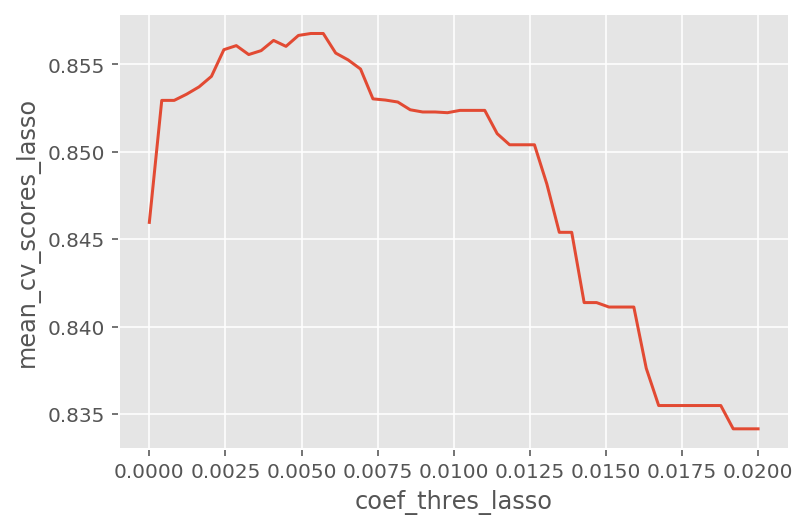

In [56]:
sns.lineplot(improve_lasso.coef_thres_lasso, improve_lasso.mean_cv_scores_lasso)

#### Optimal Lasso

In [57]:
opt_thres_lasso = improve_lasso['coef_thres_lasso'].iloc[0]
print(opt_thres_lasso)
columns_keep_lasso = coef_lasso[coef_lasso.coef_lasso_abs > opt_thres_lasso].index
X_opt = X_pre_std.loc[:, columns_keep_lasso]

0.005306122448979592


Optimal intercept(Lasso): 12.032355644349652
Optimal alpha (Lasso): 0.00030126845359658595
Optimal CV Score (Lasso): 0.8567698123960625
Optimal Train Score (Lasso): 0.8767206311105022
Optimal Test Score (Lasso): 0.8966498510875767


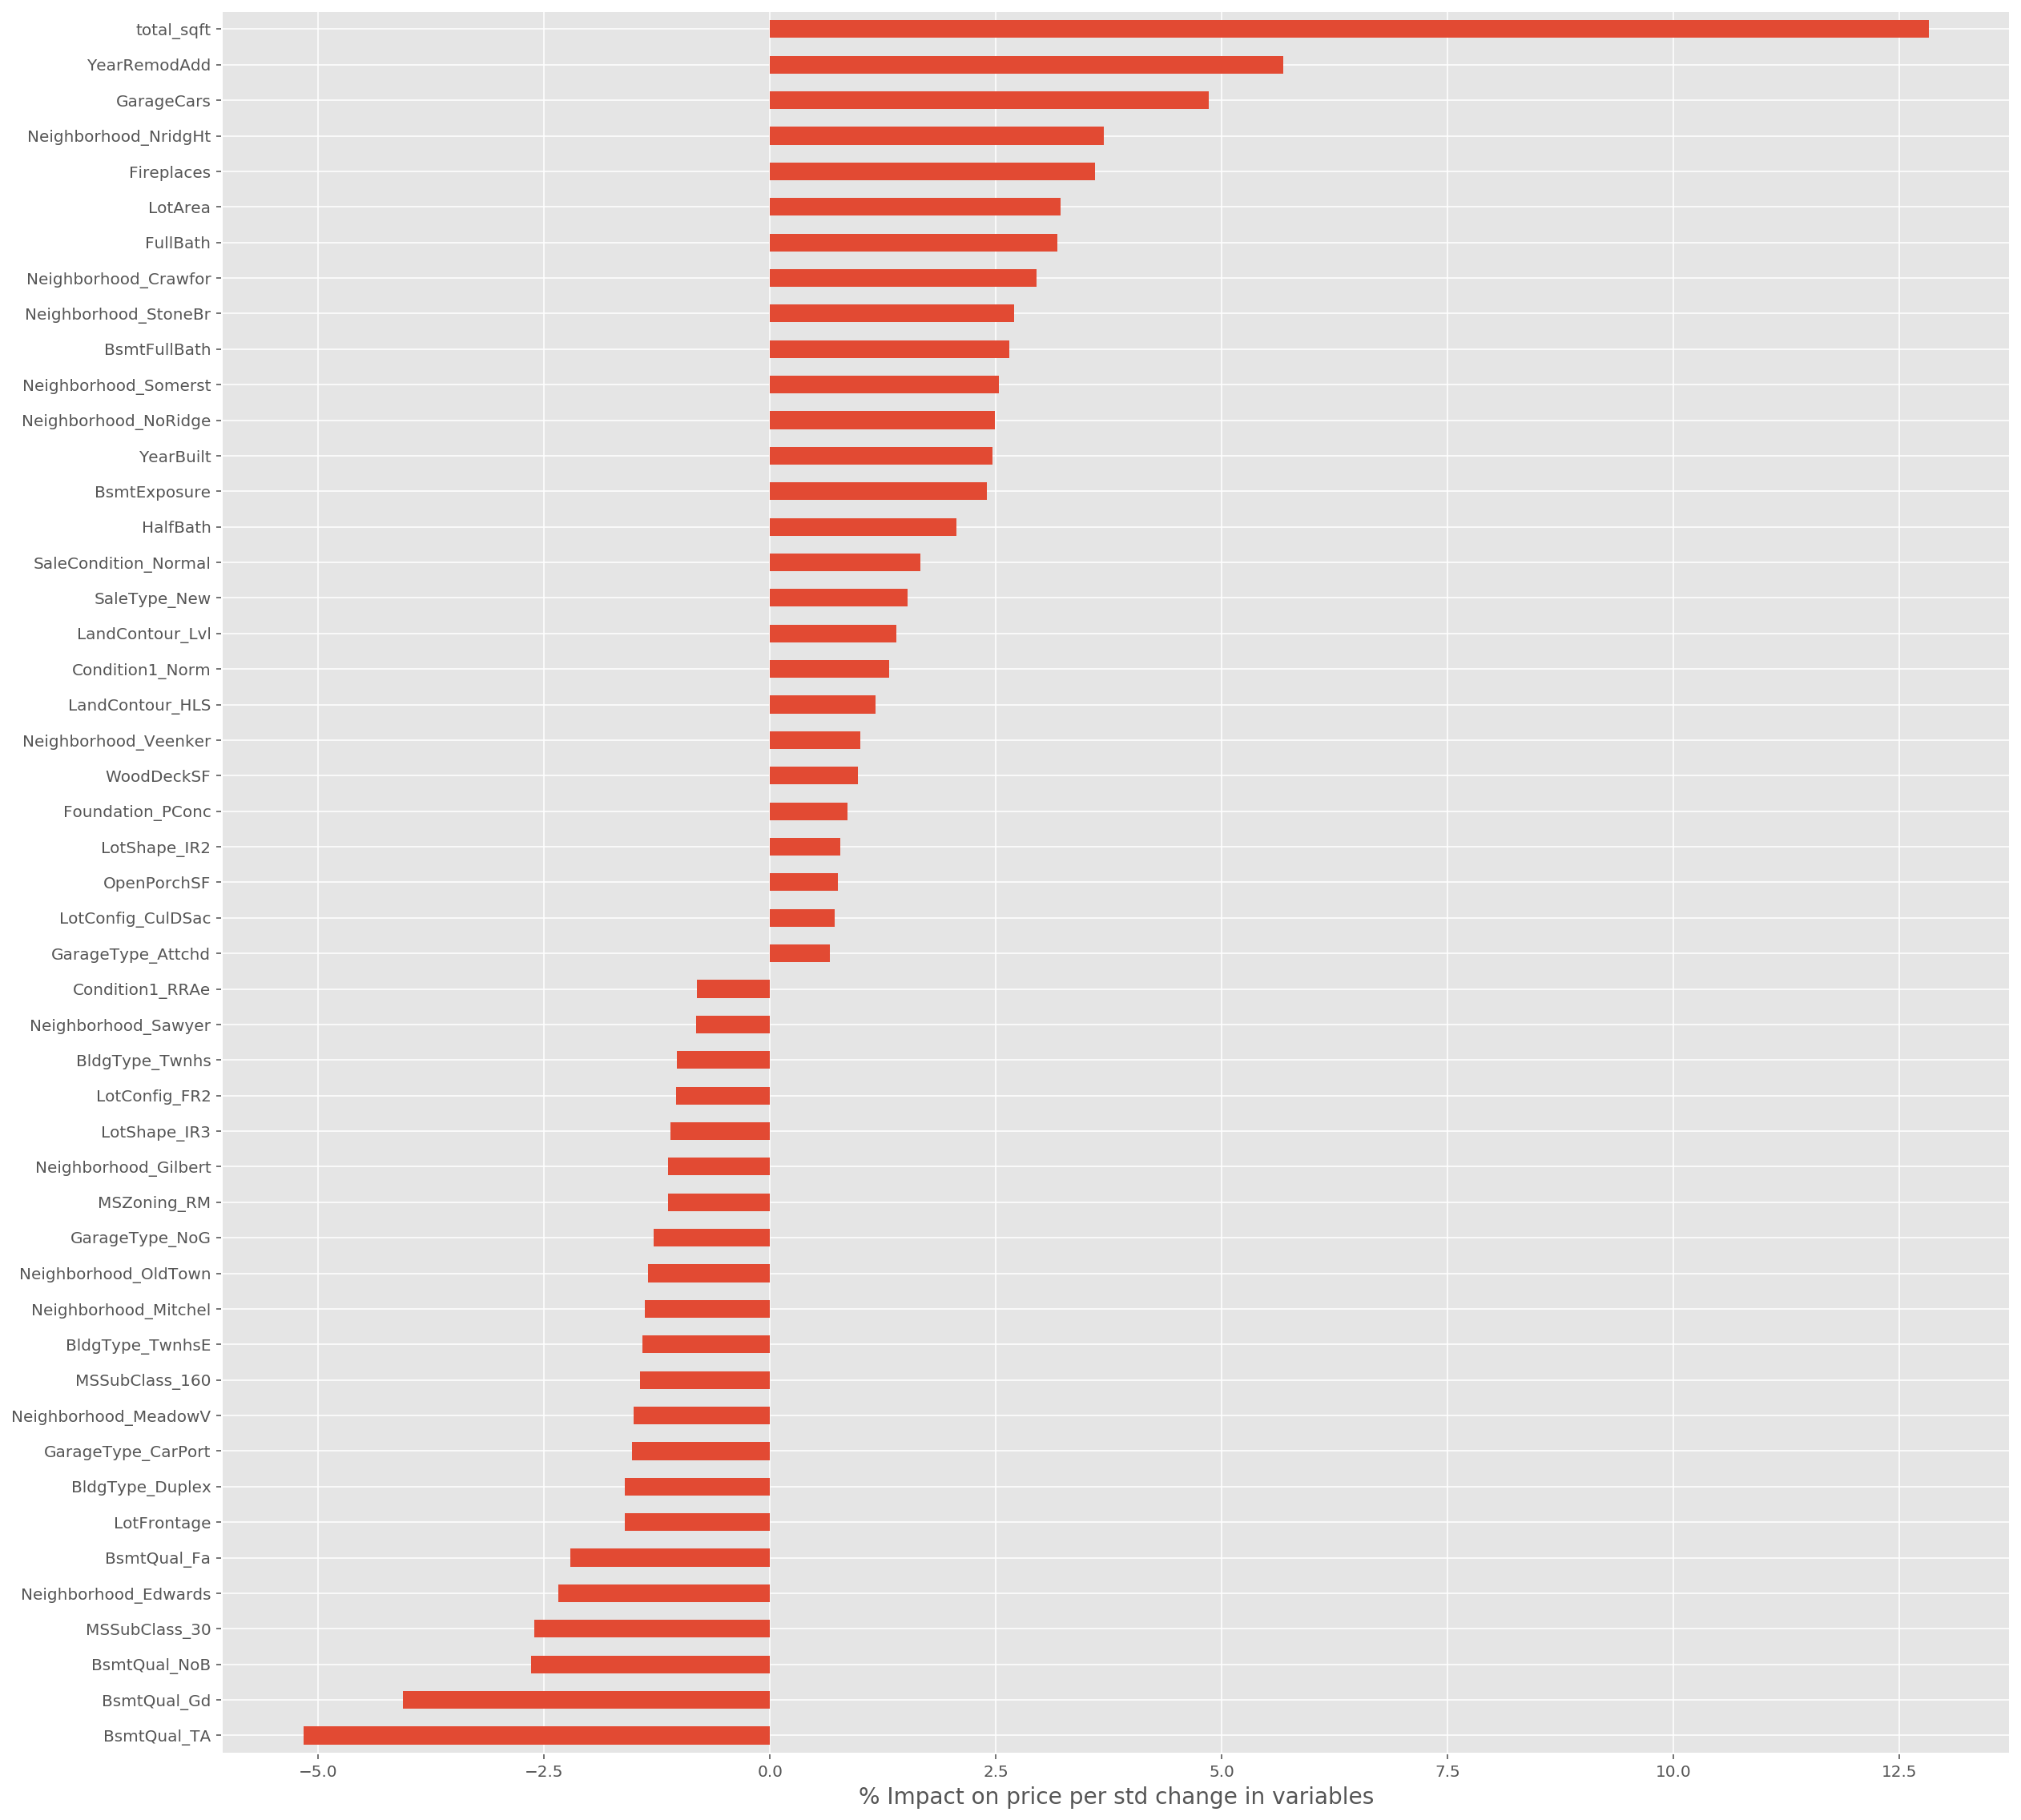

In [58]:
#Sense checking the optimal Lasso model
lassoCV_opt = LassoCV(n_alphas = 100, cv=kf)
lassoCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
lasso_opt = Lasso(alpha=lassoCV_opt.alpha_)


print(f'Optimal intercept(Lasso): {lassoCV_opt.intercept_}')
print(f'Optimal alpha (Lasso): {lassoCV_opt.alpha_}')
print(f'Optimal CV Score (Lasso): {cross_val_score(lasso_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Lasso): {lassoCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Lasso): {lassoCV_opt.score(X_post_std.loc[:, columns_keep_lasso], y_post_2010)}')


#Visualising the optimal coefficients
coef_lasso = pd.DataFrame(lassoCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()
coef_lasso['coef_lasso_price_impact'] = (np.exp(coef_lasso.coef_lasso)-1)*100

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso_price_impact'].sort_values().plot(kind='barh')
plt.xlabel('% Impact on price per std change in variables', fontsize = 14);

### **Ridge CV - Ridge is a Smidge Better!** 

In [59]:
ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV.fit(X_pre_std, y_pre_2010)

train_score = ridgeCV.score(X_pre_std, y_pre_2010)
test_score = ridgeCV.score(X_post_std, y_post_2010)

#Cross Validation 
ridge = Ridge(alpha=ridgeCV.alpha_)
cv_score = cross_val_score(ridge, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {ridgeCV.intercept_}')
print(f'Model coeff: {ridgeCV.coef_}')
print(f'Model alpha: {ridgeCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-0.00587365  0.0286854   0.02689555  0.04765676  0.02492071  0.02637613
  0.0347302   0.02277532  0.01175453  0.03678779  0.00502665  0.03609687
  0.01954853  0.01274671  0.01174116  0.00366814  0.00342353 -0.00494993
  0.08921577 -0.00087665  0.00143067 -0.01196817  0.00809888 -0.00956363
  0.00060258  0.00793525 -0.00180997  0.0090299   0.00904517 -0.0087716
 -0.00314217  0.00079524  0.00015422 -0.00061425  0.00228455 -0.00056201
 -0.00568109  0.02408075 -0.02416487 -0.01336715 -0.00385506 -0.0156855
 -0.01445297 -0.00835844  0.00073514 -0.00292388  0.02481904  0.03478009
 -0.01428872 -0.00456659 -0.0113299   0.00086384  0.01880964  0.0250851
  0.00264751  0.00808612 -0.00540441  0.01192396  0.00574277  0.00153006
 -0.0081392  -0.00014194  0.00082324  0.00486967 -0.00479075 -0.00792532
 -0.0063041  -0.0084497   0.00160856 -0.00034155  0.00473785  0.00201945
 -0.00191852  0.00033386 -0.0005763  -0.00016877  0.01400293 -0.00618308
 -0.0

#### Visualising coefs

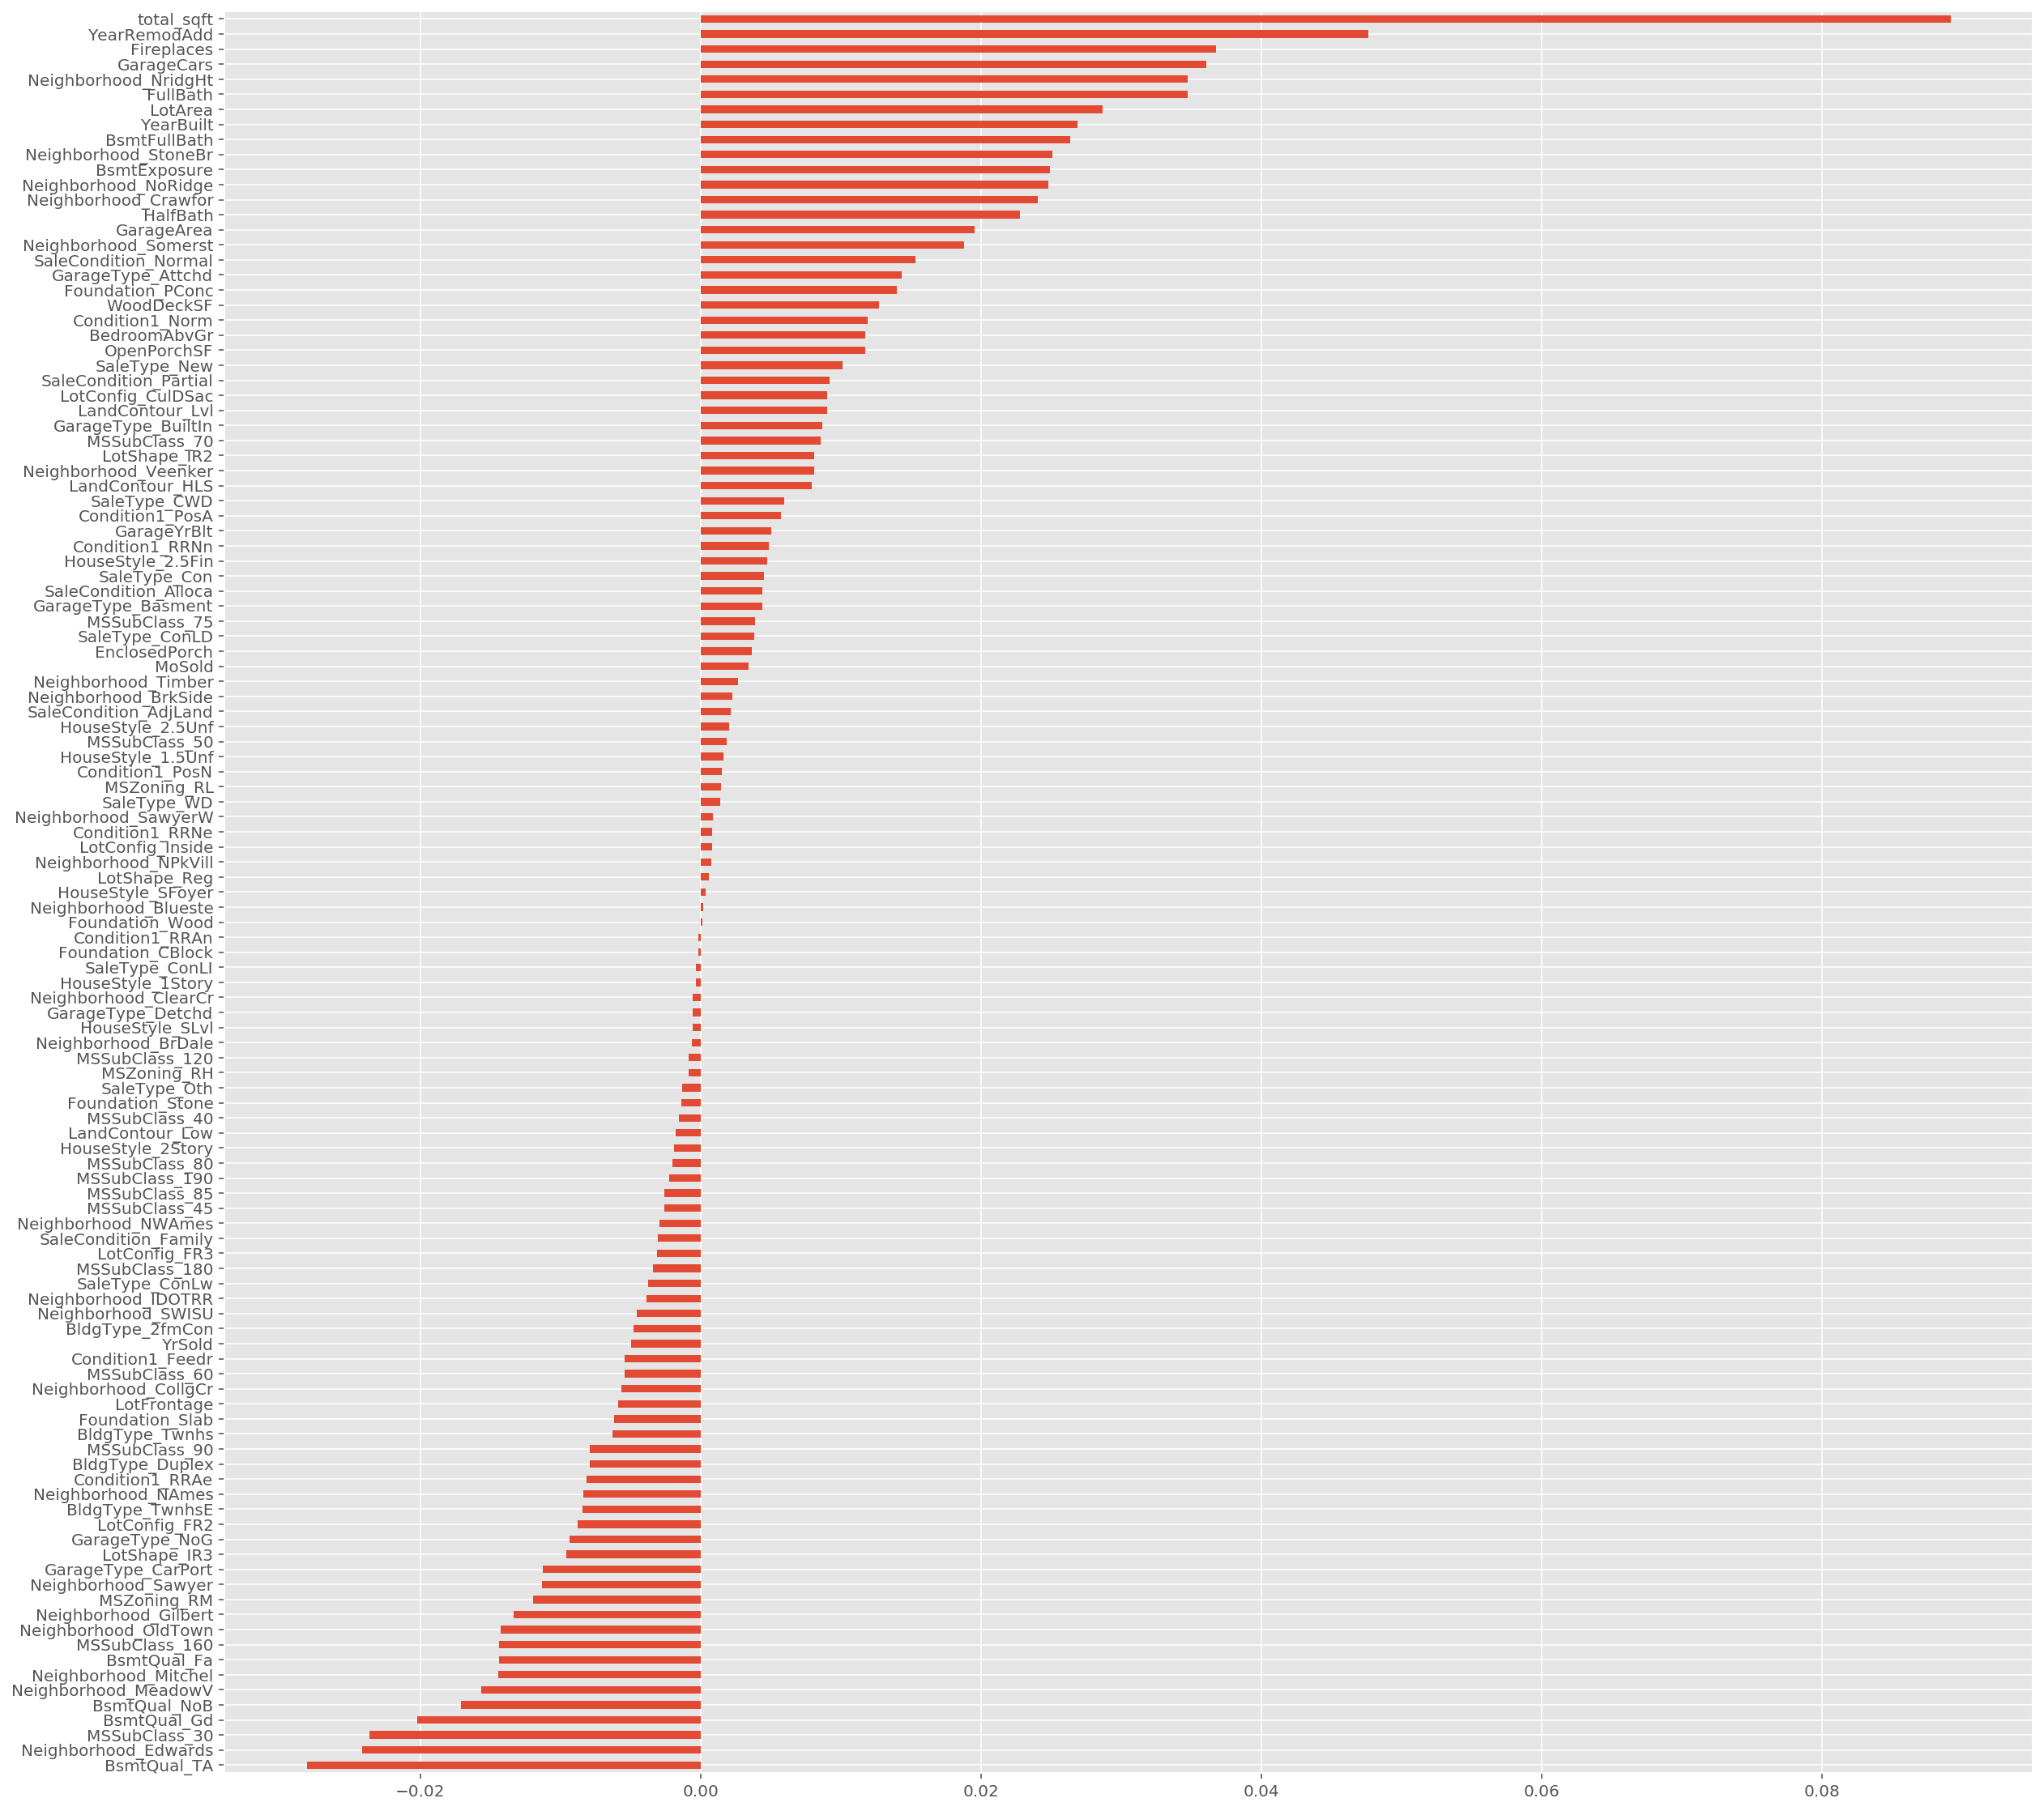

In [60]:
coef_ridge= pd.DataFrame(ridgeCV.coef_, index=X_pre_std.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge'].sort_values().plot(kind='barh');

#### Cutting down the coefficients

In [61]:
coef_ridge.sort_values(by='coef_ridge_abs')

coef_ridge  coef_ridge_abs
Condition1_RRAn         -0.000142        0.000142
Foundation_Wood          0.000144        0.000144
Neighborhood_Blueste     0.000154        0.000154
Foundation_CBlock       -0.000169        0.000169
SaleType_ConLI          -0.000332        0.000332
HouseStyle_SFoyer        0.000334        0.000334
HouseStyle_1Story       -0.000342        0.000342
Neighborhood_ClearCr    -0.000562        0.000562
GarageType_Detchd       -0.000568        0.000568
HouseStyle_SLvl         -0.000576        0.000576
LotShape_Reg             0.000603        0.000603
Neighborhood_BrDale     -0.000614        0.000614
Neighborhood_NPkVill     0.000735        0.000735
LotConfig_Inside         0.000795        0.000795
Condition1_RRNe          0.000823        0.000823
Neighborhood_SawyerW     0.000864        0.000864
MSSubClass_120          -0.000873        0.000873
MSZoning_RH             -0.000877        0.000877
SaleType_Oth            -0.001326        0.001326
Foundation_Stone        -0.001381        0.001381
SaleType_WD              0.001405        0.001405
MSZoning_RL              0.001431        0.001431
Condition1_PosN          0.001530        0.001530
MSSubClass_40           -0.001538        0.001538
HouseStyle_1.5Unf        0.001609        0.001609
LandContour_Low         -0.001810        0.001810
MSSubClass_50            0.001830        0.001830
HouseStyle_2Story       -0.001919        0.001919
HouseStyle_2.5Unf        0.002019        0.002019
MSSubClass_80           -0.002028        0.002028
SaleCondition_AdjLand    0.002121        0.002121
MSSubClass_190          -0.002220        0.002220
Neighborhood_BrkSide     0.002285        0.002285
MSSubClass_85           -0.002599        0.002599
MSSubClass_45           -0.002617        0.002617
Neighborhood_Timber      0.002648        0.002648
Neighborhood_NWAmes     -0.002924        0.002924
SaleCondition_Family    -0.003086        0.003086
LotConfig_FR3           -0.003142        0.003142
MSSubClass_180          -0.003390        0.003390
MoSold                   0.003424        0.003424
EnclosedPorch            0.003668        0.003668
SaleType_ConLw          -0.003742        0.003742
SaleType_ConLD           0.003798        0.003798
Neighborhood_IDOTRR     -0.003855        0.003855
MSSubClass_75            0.003903        0.003903
GarageType_Basment       0.004396        0.004396
SaleCondition_Alloca     0.004426        0.004426
SaleType_Con             0.004529        0.004529
Neighborhood_SWISU      -0.004567        0.004567
HouseStyle_2.5Fin        0.004738        0.004738
BldgType_2fmCon         -0.004791        0.004791
Condition1_RRNn          0.004870        0.004870
YrSold                  -0.004950        0.004950
GarageYrBlt              0.005027        0.005027
Condition1_Feedr        -0.005404        0.005404
MSSubClass_60           -0.005421        0.005421
Neighborhood_CollgCr    -0.005681        0.005681
Condition1_PosA          0.005743        0.005743
LotFrontage             -0.005874        0.005874
SaleType_CWD             0.005938        0.005938
Foundation_Slab         -0.006183        0.006183
BldgType_Twnhs          -0.006304        0.006304
MSSubClass_90           -0.007925        0.007925
BldgType_Duplex         -0.007925        0.007925
LandContour_HLS          0.007935        0.007935
Neighborhood_Veenker     0.008086        0.008086
LotShape_IR2             0.008099        0.008099
Condition1_RRAe         -0.008139        0.008139
Neighborhood_NAmes      -0.008358        0.008358
BldgType_TwnhsE         -0.008450        0.008450
MSSubClass_70            0.008553        0.008553
GarageType_BuiltIn       0.008654        0.008654
LotConfig_FR2           -0.008772        0.008772
LandContour_Lvl          0.009030        0.009030
LotConfig_CulDSac        0.009045        0.009045
SaleCondition_Partial    0.009214        0.009214
GarageType_NoG          -0.009382        0.009382
LotShape_IR3            -0.009564        0.009564
SaleType_New           

In [62]:
coef_thres = np.linspace(coef_ridge.coef_ridge_abs.min(),
                         0.02, num=50)
mean_cv_scores = []
cols_dropped = []

for thres in coef_thres:
    good_coef = coef_ridge[coef_ridge.coef_ridge_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
    ridgeCV.fit(X_subset, y_pre_2010)
    ridge = Ridge(alpha=ridgeCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        ridge, X_subset, y_pre_2010, cv=kf).mean())

In [63]:
improve_ridge = pd.DataFrame({'coef_thres_ridge': coef_thres, 'mean_cv_scores_ridge': mean_cv_scores, 
                              'cols_dropped_num_ridge': cols_dropped})

In [64]:
improve_ridge = improve_ridge.sort_values(by=['mean_cv_scores_ridge', 'cols_dropped_num_ridge'], 
                                          ascending =[False, False])
improve_ridge[:10]

coef_thres_ridge  mean_cv_scores_ridge  cols_dropped_num_ridge
15          0.006221              0.857827                      62
16          0.006626              0.857716                      63
17          0.007031              0.857716                      63
18          0.007437              0.857716                      63
19          0.007842              0.857716                      63
13          0.005410              0.857182                      56
14          0.005816              0.856405                      59
12          0.005005              0.856403                      54
11          0.004600              0.855990                      50
10          0.004195              0.855270                      46

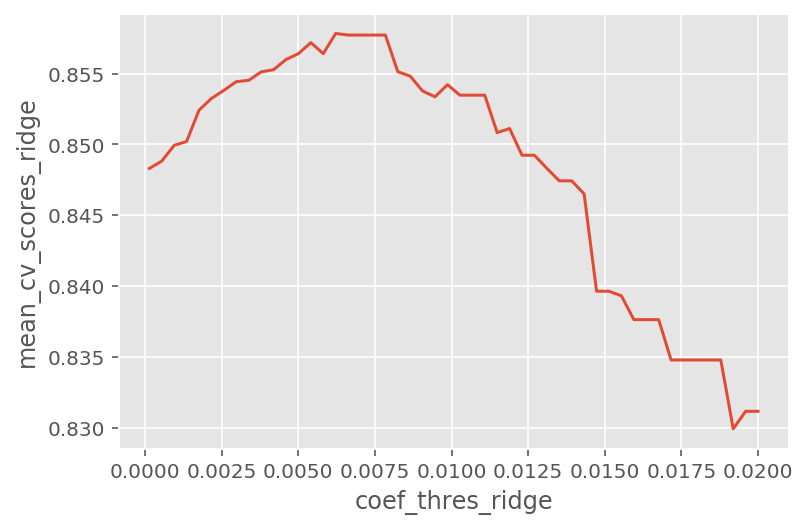

In [65]:
sns.lineplot(improve_ridge.coef_thres_ridge, improve_ridge.mean_cv_scores_ridge)

#### Optimal Ridge

In [66]:
opt_thres_ridge = improve_ridge['coef_thres_ridge'].iloc[0]
columns_keep_ridge = coef_ridge[coef_ridge.coef_ridge_abs > opt_thres_ridge].index
X_opt = X_pre_std.loc[:, columns_keep_ridge]
print(opt_thres_ridge)

0.006220939643180351


Optimal intercept(Ridge): 12.032355644349652
Optimal alpha (Ridge): 166.81005372000558
Optimal CV Score (Ridge): 0.8578271322009046
Optimal Train Score (Ridge): 0.8731101010826363
Optimal Test Score (Ridge): 0.8946954033851798


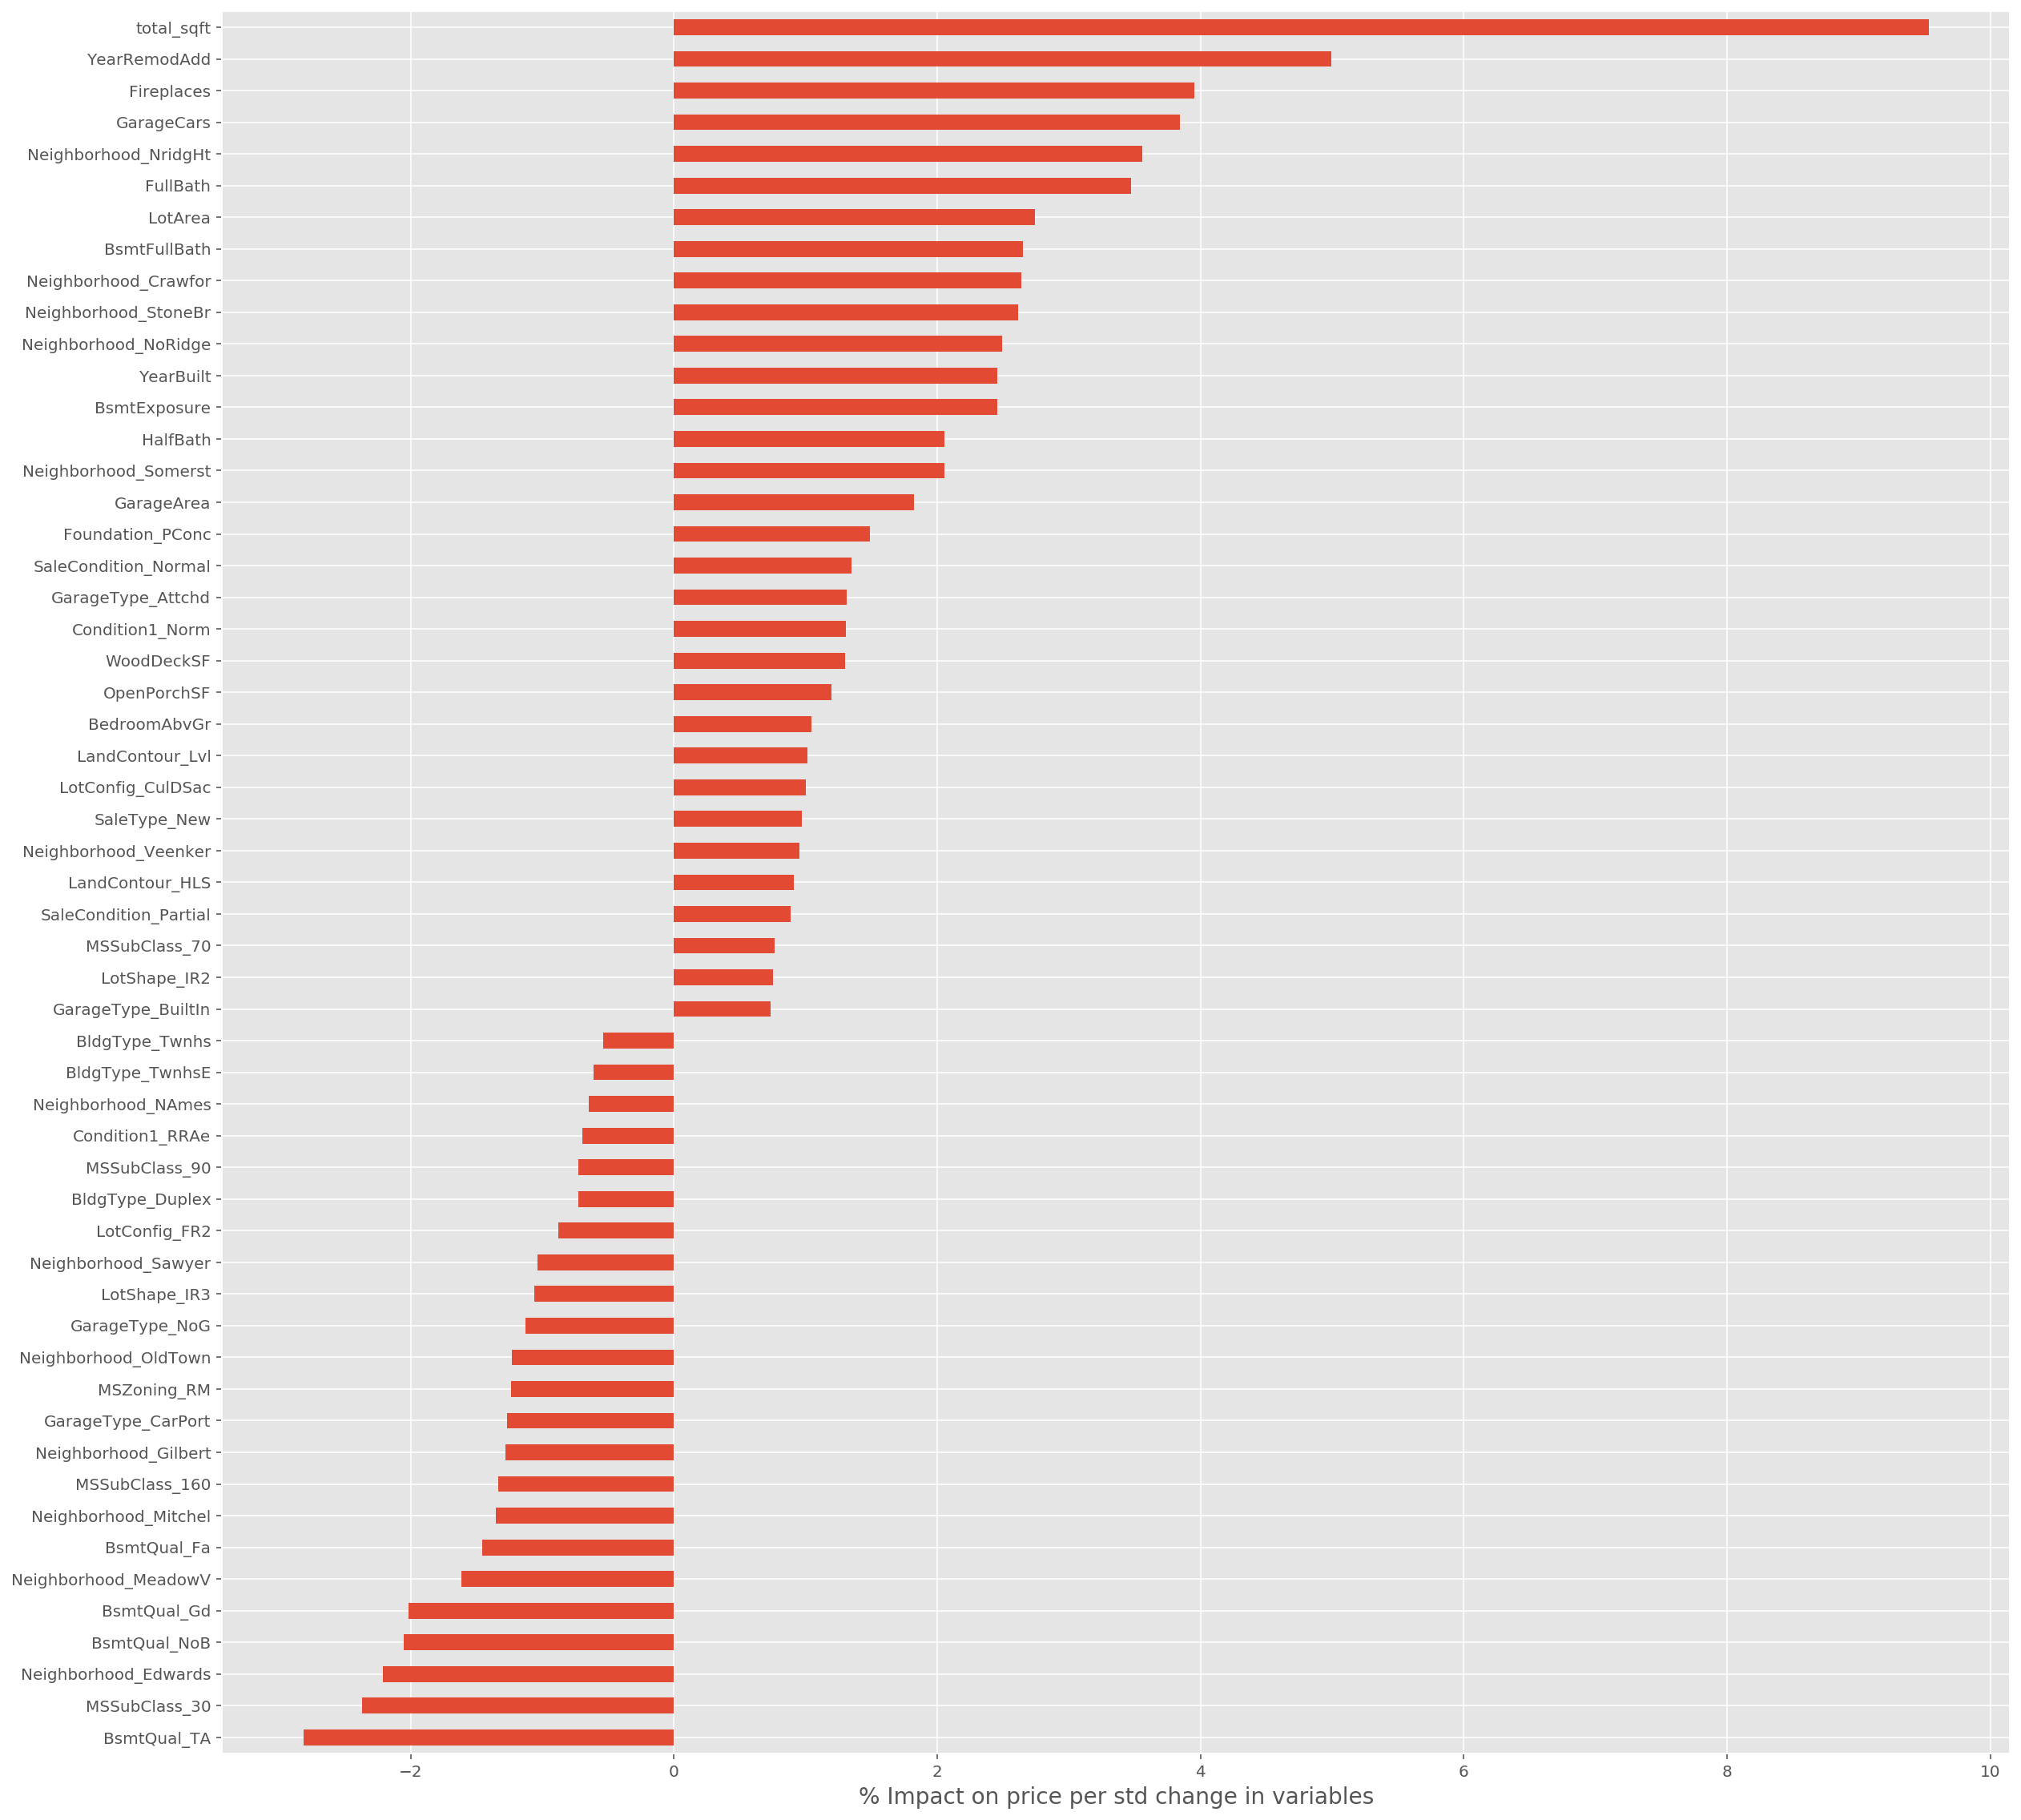

In [67]:
#Sense checking the optimal Ridge model
ridgeCV_opt = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
ridge_opt = Ridge(alpha=ridgeCV_opt.alpha_)

print(f'Optimal intercept(Ridge): {ridgeCV_opt.intercept_}')
print(f'Optimal alpha (Ridge): {ridgeCV_opt.alpha_}')
print(f'Optimal CV Score (Ridge): {cross_val_score(ridge_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Ridge): {ridgeCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Ridge): {ridgeCV_opt.score(X_post_std.loc[:, columns_keep_ridge], y_post_2010)}')

#Visualising the optimal coefficients 
coef_ridge = pd.DataFrame(ridgeCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()
coef_ridge['coef_ridge_price_impact'] = 100*(np.exp(coef_ridge.coef_ridge)-1)

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge_price_impact'].sort_values().plot(kind='barh')
plt.xlabel('% Impact on price per std change in variables', fontsize = 14);


### Extracting residuals from optimal ridge - best model right now 

In [68]:
res_train = y_pre_2010-ridgeCV_opt.predict(X_opt)
res_test = y_post_2010- ridgeCV_opt.predict(X_post_std.loc[:, columns_keep_ridge])
res_full = pd.concat([res_train, res_test]) 

print(res_train.shape, res_test.shape, res_full.shape)


(1278,) (172,) (1450,)


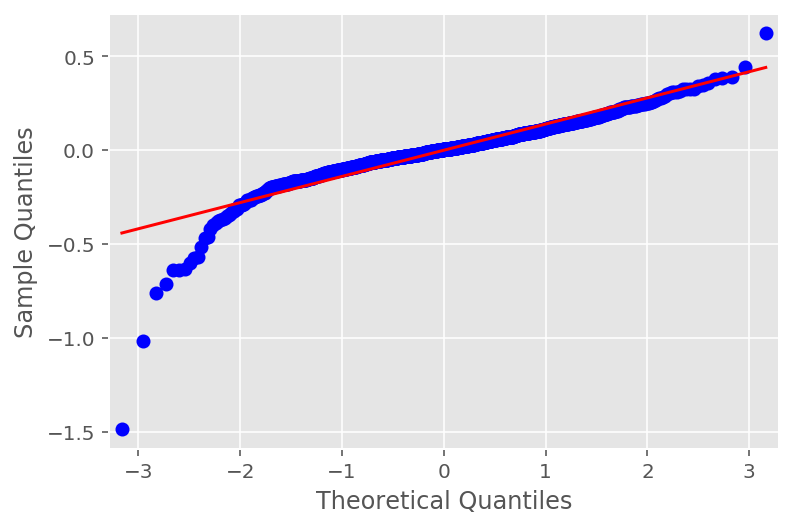

In [69]:
sm.qqplot(res_train, line='s');

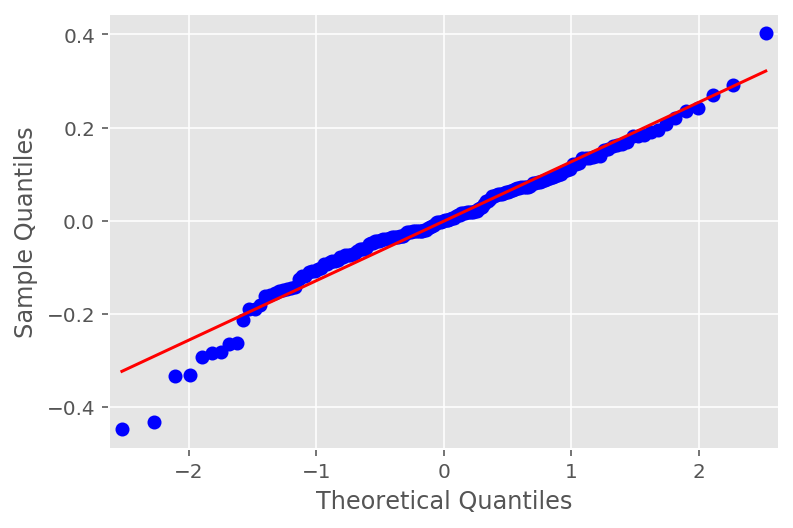

In [70]:
sm.qqplot(res_test, line='s');

### **ElasticNet CV**

In [71]:
elasticnetCV = ElasticNetCV(n_alphas = 100, l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]), cv=kf)
elasticnetCV.fit(X_pre_std, y_pre_2010)

train_score = elasticnetCV.score(X_pre_std, y_pre_2010)
test_score = elasticnetCV.score(X_post_std, y_post_2010)

#Cross Validation 
elasticnet = ElasticNet(alpha=elasticnetCV.alpha_, l1_ratio = elasticnetCV.l1_ratio_)
cv_score = cross_val_score(elasticnet, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {elasticnetCV.intercept_}')
print(f'Model coeff: {elasticnetCV.coef_}')
print(f'Model alpha: {elasticnetCV.alpha_}')
print(f'Model l1_ratio: {elasticnetCV.l1_ratio_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: 12.032355644349652
Model coeff: [-5.32097262e-03  3.02846818e-02  3.10753413e-02  5.40213764e-02
  2.28428497e-02  2.47881466e-02  2.85517613e-02  1.79257644e-02
  3.77181124e-03  3.55502212e-02  0.00000000e+00  4.67284825e-02
  6.66046878e-03  1.08311360e-02  7.38972732e-03  0.00000000e+00
  1.72384439e-03 -2.79861807e-03  1.17410671e-01 -0.00000000e+00
  0.00000000e+00 -1.25635629e-02  4.97900967e-03 -1.09642581e-02
 -0.00000000e+00  5.68254583e-03 -0.00000000e+00  6.64683499e-03
  7.30515054e-03 -5.88631468e-03 -6.51998903e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.02316287e-03 -0.00000000e+00
 -0.00000000e+00  2.72925603e-02 -1.99417813e-02 -8.01517460e-03
 -0.00000000e+00 -1.39374635e-02 -1.06243486e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  2.25660167e-02  3.74245611e-02
 -8.69462058e-03 -0.00000000e+00 -5.67653590e-03  1.59247083e-05
  2.21756637e-02  2.57204829e-02  3.02435506e-03  7.46413380e-03
 -3.99618647e-03  1.06975407e-02  3.05061

### Q2

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Loading the data for floating features

In [72]:
fixed_cols

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'BsmtFinSF2',
 'HouseStyle',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageType',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'PoolArea',
 'ScreenPorch',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [73]:
house_renov = house.loc[:, ~house.columns.isin(fixed_cols)].copy()
house_renov.head()
house_renov.columns
house_renov.shape

(1450, 27)

### Checking the values in each columns

In [74]:
#Removing all the columns that have 90% of the same values
remove_features = []
for col in house_renov.columns: 
    if house_renov[col].value_counts(dropna=False).iloc[0]/house_renov[col].value_counts(dropna=False).sum() > 0.90:
        print(house_renov[col].value_counts(dropna=False),'-------------------------', sep='\n')
        remove_features.append(col)
remove_features

AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64
-------------------------
CompShg    1424
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
ClyTile       1
Roll          1
Metal         1
Name: RoofMatl, dtype: int64
-------------------------
GasA     1419
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
-------------------------
Y    1361
N      89
Name: CentralAir, dtype: int64
-------------------------
SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64
-------------------------
TA     1319
NaN      79
Fa       34
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64
-------------------------
Y    1335
N      85
P      30
Name: PavedDrive, dtype: int64
-------------------------
NaN    1443
Gd        3
Ex        2
Fa        2
Name: PoolQC, dtype: int64
-------------------------


['Utilities',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageCond',
 'PavedDrive',
 'PoolQC']

In [75]:
house_renov.drop(columns = remove_features, inplace=True)

### Dealing with Null values

In [76]:
house_renov.isnull().sum()

OverallQual        0
OverallCond        0
RoofStyle          0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtUnfSF          0
HeatingQC          0
KitchenQual        0
FireplaceQu      681
GarageFinish      79
GarageQual        79
Fence           1172
dtype: int64

#### Basement condition and ratings

In [77]:
#Fixing an error in the basement entry details for one datapoint
house_renov[house_renov.BsmtCond.isnull()]

mistake = house[~house.BsmtCond.isnull() & house.BsmtFinType2.isnull()].index

In [78]:
house[(house.BsmtFinType1 == 'GLQ') & ~house.BsmtFinType2.isnull() & 
      (house.BsmtFinSF2 != 0)]['BsmtFinType2'].value_counts()

LwQ    10
Rec     9
ALQ     4
BLQ     2
Name: BsmtFinType2, dtype: int64

In [79]:
#Replace the mistake with the most frequently occuring value
house_renov.loc[mistake, 'BsmtFinType2'] = 'LwQ'

In [80]:
house_renov.BsmtCond.fillna('NoB', inplace=True)
house_renov.BsmtFinType1.fillna('NoB', inplace=True)
house_renov.BsmtFinType2.fillna('NoB', inplace=True)

#### Masonry type

In [81]:
house_renov[~house_renov.MasVnrType.isnull()][:20]
house_renov[house_renov.MasVnrType=='None'][:10]

OverallQual  OverallCond RoofStyle Exterior1st Exterior2nd MasVnrType  \
1             6            8     Gable     MetalSd     MetalSd       None   
3             7            5     Gable     Wd Sdng     Wd Shng       None   
5             5            5     Gable     VinylSd     VinylSd       None   
8             7            5     Gable     BrkFace     Wd Shng       None   
9             5            6     Gable     MetalSd     MetalSd       None   
10            5            5       Hip     HdBoard     HdBoard       None   
12            5            6       Hip     HdBoard     Plywood       None   
15            7            8     Gable     Wd Sdng     Wd Sdng       None   
17            4            5     Gable     MetalSd     MetalSd       None   
18            5            5     Gable     VinylSd     VinylSd       None   

    MasVnrArea ExterQual ExterCond BsmtCond BsmtFinType1 BsmtFinType2  \
1          0.0        TA        TA       TA          ALQ          Unf   
3          0.0        TA        TA       Gd          ALQ          Unf   
5          0.0        TA        TA       TA          GLQ          Unf   
8          0.0        TA        TA       TA          Unf          Unf   
9          0.0        TA        TA       TA          GLQ          Unf   
10         0.0        TA        TA       TA          Rec          Unf   
12         0.0        TA        TA       TA          ALQ          Unf   
15         0.0        TA        TA       TA          Unf          Unf   
17         0.0        TA        TA      NoB          NoB          NoB   
18         0.0        TA        TA       TA          GLQ          Unf   

    BsmtUnfSF HeatingQC KitchenQual FireplaceQu GarageFinish GarageQual  Fence  
1         284        Ex          TA          TA          RFn         TA    NaN  
3         540        Gd          Gd          Gd          Unf         TA    NaN  
5          64        Ex          TA         NaN          Unf         TA  MnPrv  
8         952        Gd          TA          TA          Unf         Fa    NaN  
9         140        Ex          TA          TA          RFn         Gd    NaN  
10        134        Ex          TA         NaN          Unf         TA    NaN  
12        175        TA          TA         NaN          Unf         TA    NaN  
15        832        Ex          TA         NaN          Unf         TA  GdPrv  
17          0        TA          TA         NaN          Unf         TA    NaN  
18        468        Ex          Gd         NaN          Unf         TA    NaN

In [82]:
house_renov[house_renov.MasVnrType.isnull()]
house_renov.MasVnrType.fillna('None', inplace=True)
house_renov.MasVnrArea.fillna(0.0, inplace=True)

#### Garage

In [83]:
house_renov.GarageFinish.fillna('NoG', inplace=True)
house_renov.GarageQual.fillna('NoG', inplace=True)

#### Fireplace

In [84]:
#Only Na because there is no Fireplace 
house[house.FireplaceQu.isnull()]
house_renov.FireplaceQu.fillna('NoF', inplace=True)

#### Fence

In [85]:
house[house.Fence.isnull()][:100]
house_renov.Fence.fillna('NoFe', inplace=True)

### Analysing variables (Correlation map & Histograms)

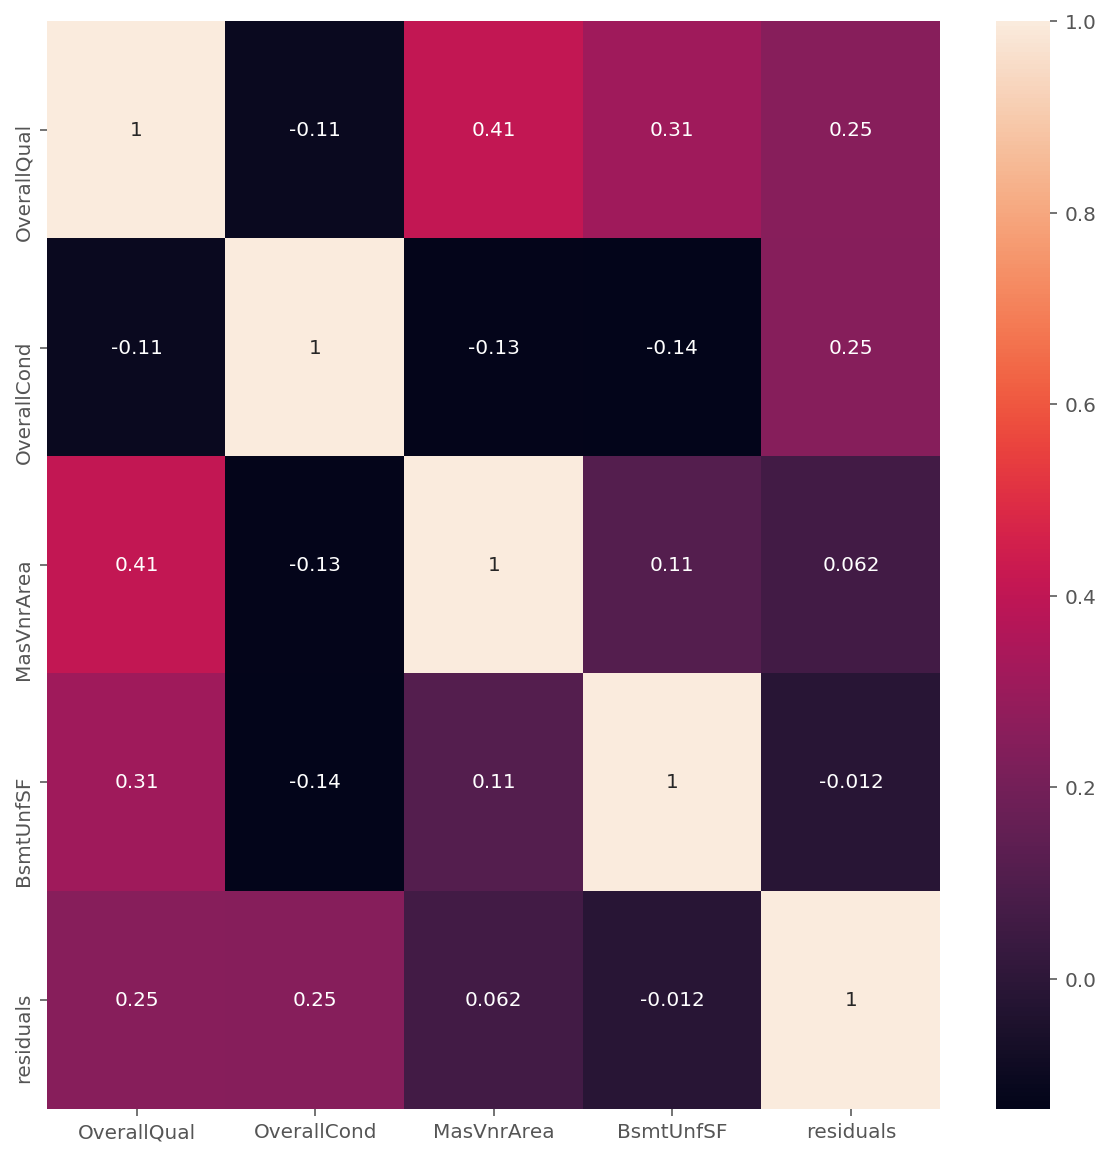

In [86]:
res_house_renov = house_renov.copy()
res_house_renov['residuals'] = res_full
plt.figure(figsize=(10,10))
sns.heatmap(res_house_renov.corr(), annot=True)

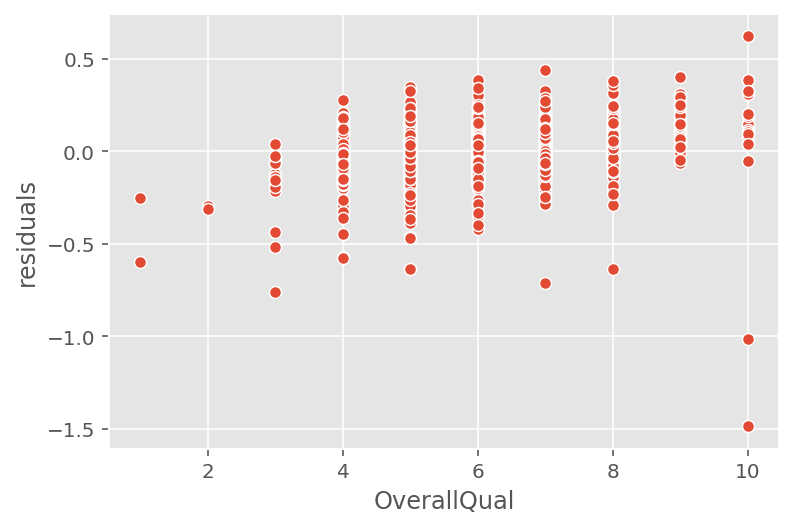

In [87]:
sns.scatterplot(res_house_renov.OverallQual, res_house_renov.residuals)

### Checking the skew of the variables

In [88]:
house_renov.skew()

OverallQual    0.237138
OverallCond    0.726570
MasVnrArea     2.666948
BsmtUnfSF      0.922304
dtype: float64

### Interaction elements & other feature engineering

In [89]:
"""house_renov['OverallQual_Sqr'] = house_renov.OverallQual**2
house_renov.OverallQual_Sqr.head(10)"""

"house_renov['OverallQual_Sqr'] = house_renov.OverallQual**2\nhouse_renov.OverallQual_Sqr.head(10)"

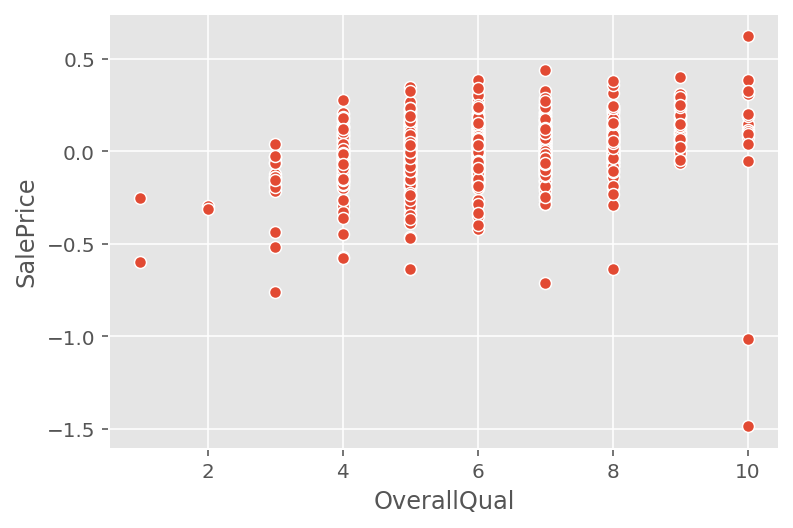

In [90]:
sns.scatterplot(house_renov.OverallQual, res_full)

In [91]:
house_renov['OverallCond_Sqr'] = house_renov.OverallCond**1.5
house_renov.OverallCond_Sqr.head(10)

0    11.180340
1    22.627417
2    11.180340
3    11.180340
4    11.180340
5    11.180340
6    11.180340
7    14.696938
8    11.180340
9    14.696938
Name: OverallCond_Sqr, dtype: float64

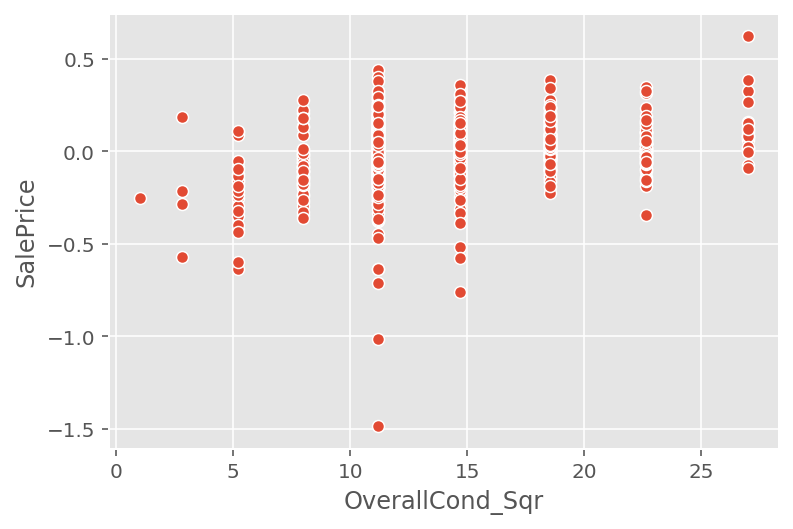

In [92]:
sns.scatterplot(house_renov.OverallCond_Sqr, res_full)

### Dummifying variables

In [93]:
to_dummify = list(house_renov.select_dtypes(include='object').columns)
to_dummify

['RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'Fence']

In [94]:
to_dummify +=['OverallQual']

In [95]:
house_renov_dum = pd.get_dummies(house_renov, columns = to_dummify, drop_first= True)
house_renov_dum.shape

(1450, 97)

### Splitting the data

In [96]:
print(np.all(house_fixed[house_fixed.YrSold<2010].index == res_train.index))
print(np.all(house_fixed[house_fixed.YrSold>=2010].index == res_test.index))

True
True


In [97]:
X_pre_2010 = house_renov_dum.loc[house_renov_dum.index.isin(res_train.index), :]
X_post_2010 = house_renov_dum.loc[house_renov_dum.index.isin(res_test.index), :]
y_pre_2010 = res_train
y_post_2010 = res_test

In [98]:
X_pre_2010.shape, X_post_2010.shape, y_pre_2010.shape, y_post_2010.shape

((1278, 97), (172, 97), (1278,), (172,))

### Scaling the data

In [99]:
scaler = StandardScaler()
X_pre_std = pd.DataFrame(scaler.fit_transform(X_pre_2010), index = X_pre_2010.index, columns = X_pre_2010.columns)
X_post_std = pd.DataFrame(scaler.transform(X_post_2010), index = X_post_2010.index, columns = X_post_2010.columns)

### **Linear Regression**

In [100]:
linreg = LinearRegression()
linreg.fit(X_pre_std, y_pre_2010)

train_score = linreg.score(X_pre_std, y_pre_2010)
test_score = linreg.score(X_post_std, y_post_2010)

#Cross Validation 
cv_score = cross_val_score(linreg, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {linreg.intercept_}')
print(f'Model coeff: {linreg.coef_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: -9.543935647270805e-17
Model coeff: [ 1.62564688e-01 -3.90336793e-03 -1.02501828e-03 -1.27384774e-01
 -8.23358792e-03  5.85481479e-04 -5.56943981e-03  5.49254030e-03
 -3.00336534e-04  1.81573205e+10 -5.87112010e-03  2.85860083e-02
 -3.13891209e+09  6.18002403e-03  1.95180025e-02 -1.40656877e-03
  2.27653669e-02  1.23408784e-02  8.24400950e-03  1.44795005e-02
  3.14914621e-02  7.57251817e-03  7.15570528e-03 -6.33535534e-03
 -3.81233318e-03 -1.09587877e-02  3.13891209e+09 -1.10715038e-02
 -4.03545419e-02 -2.05963974e-03 -3.38343086e-02 -5.71242545e-03
 -2.93495378e-02 -1.18660862e-02 -2.27406223e-02 -5.46147272e-02
 -1.99977217e-02 -1.97027786e-02  1.57249787e-02  9.45915269e-03
  2.12370049e-03  7.22515419e-03  7.07049410e-03  1.20496980e-02
 -1.42295135e-02 -3.02282852e-02 -2.33459075e+09 -2.90808399e-02
  1.30320580e-02  1.02971361e+10  1.15354352e-02  1.79644168e-02
  1.52046755e-03 -3.11364995e-03 -2.07748875e-03 -8.32120256e+10
  1.86954083e-03 -1.93741488e-02 -9.1

#### Visualising the coefficients

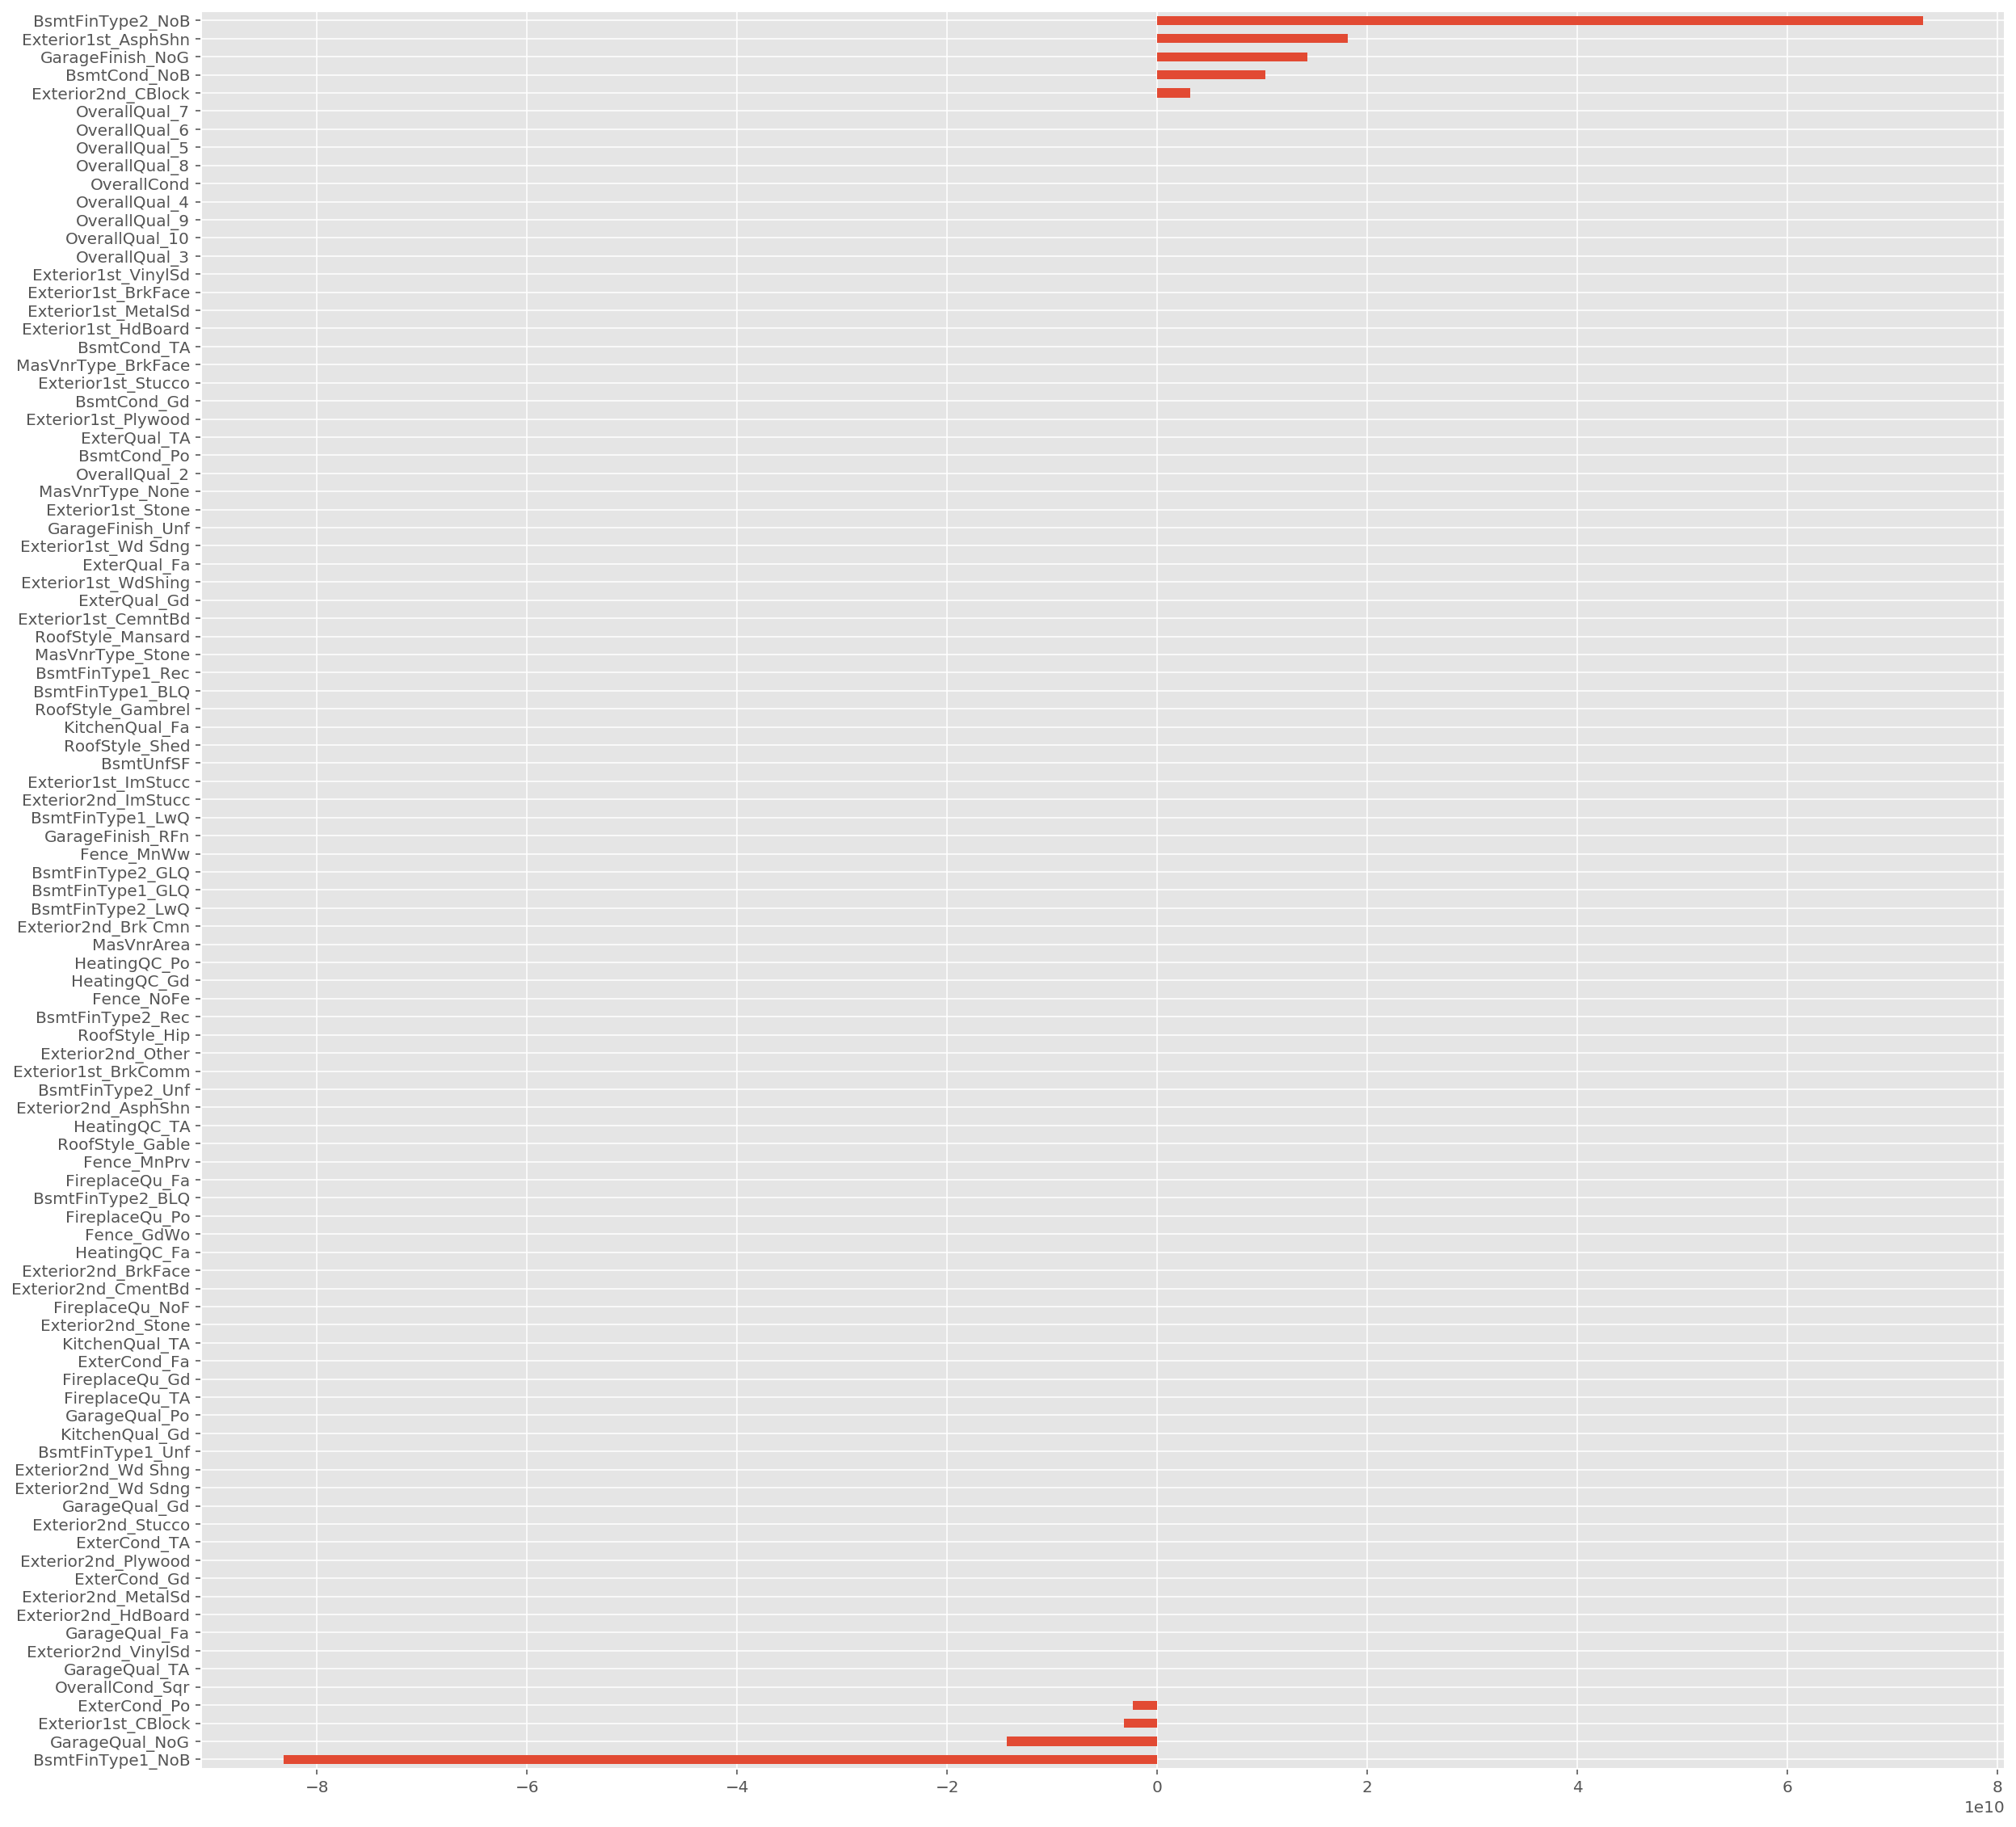

In [101]:
coef_linreg = pd.DataFrame(linreg.coef_, index=X_pre_std.columns,
                       columns=['coef_linreg'])
coef_linreg['coef_linreg_abs'] = coef_linreg.coef_linreg.abs()

plt.figure(figsize = (20,20))
coef_linreg['coef_linreg'].sort_values().plot(kind='barh');

### **Lasso CV**

In [102]:
lassoCV = LassoCV(alphas = np.logspace(-4, 4, 100), cv=kf)
lassoCV.fit(X_pre_std, y_pre_2010)

train_score = lassoCV.score(X_pre_std, y_pre_2010)
test_score = lassoCV.score(X_post_std, y_post_2010)

#Cross Validation 
lasso = Lasso(alpha=lassoCV.alpha_)
cv_score = cross_val_score(lasso, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {lassoCV.intercept_}')
print(f'Model coeff: {lassoCV.coef_}')
print(f'Model alpha: {lassoCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00357315308858297, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003532104738674491, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026490038678890215, tolerance: 0.0018692891077116641
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not c

Model intercept: -1.1583734940860617e-16
Model coeff: [ 0.03491951  0.         -0.          0.         -0.00078117  0.
  0.          0.         -0.          0.         -0.00386832  0.01637209
 -0.          0.00088547 -0.         -0.          0.         -0.
  0.00023157 -0.         -0.         -0.         -0.          0.
 -0.          0.         -0.          0.         -0.00231074  0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.00033472  0.         -0.         -0.         -0.
  0.         -0.         -0.00149633 -0.          0.          0.
  0.          0.         -0.          0.00023059 -0.          0.00010375
 -0.          0.          0.         -0.01184295 -0.00189371  0.
 -0.          0.         -0.          0.         -0.0068623  -0.
 -0.         -0.00010967 -0.         -0.         -0.         -0.
  0.          0.         -0.00348655 -0.          0.         -0.
 -0.         -0.00199826  0.          0.         -0.         -0.
 -0.00336142 -0.0002

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023016443575478718, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011975116999833446, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018368754231966378, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not con

#### Visualising the coefficients

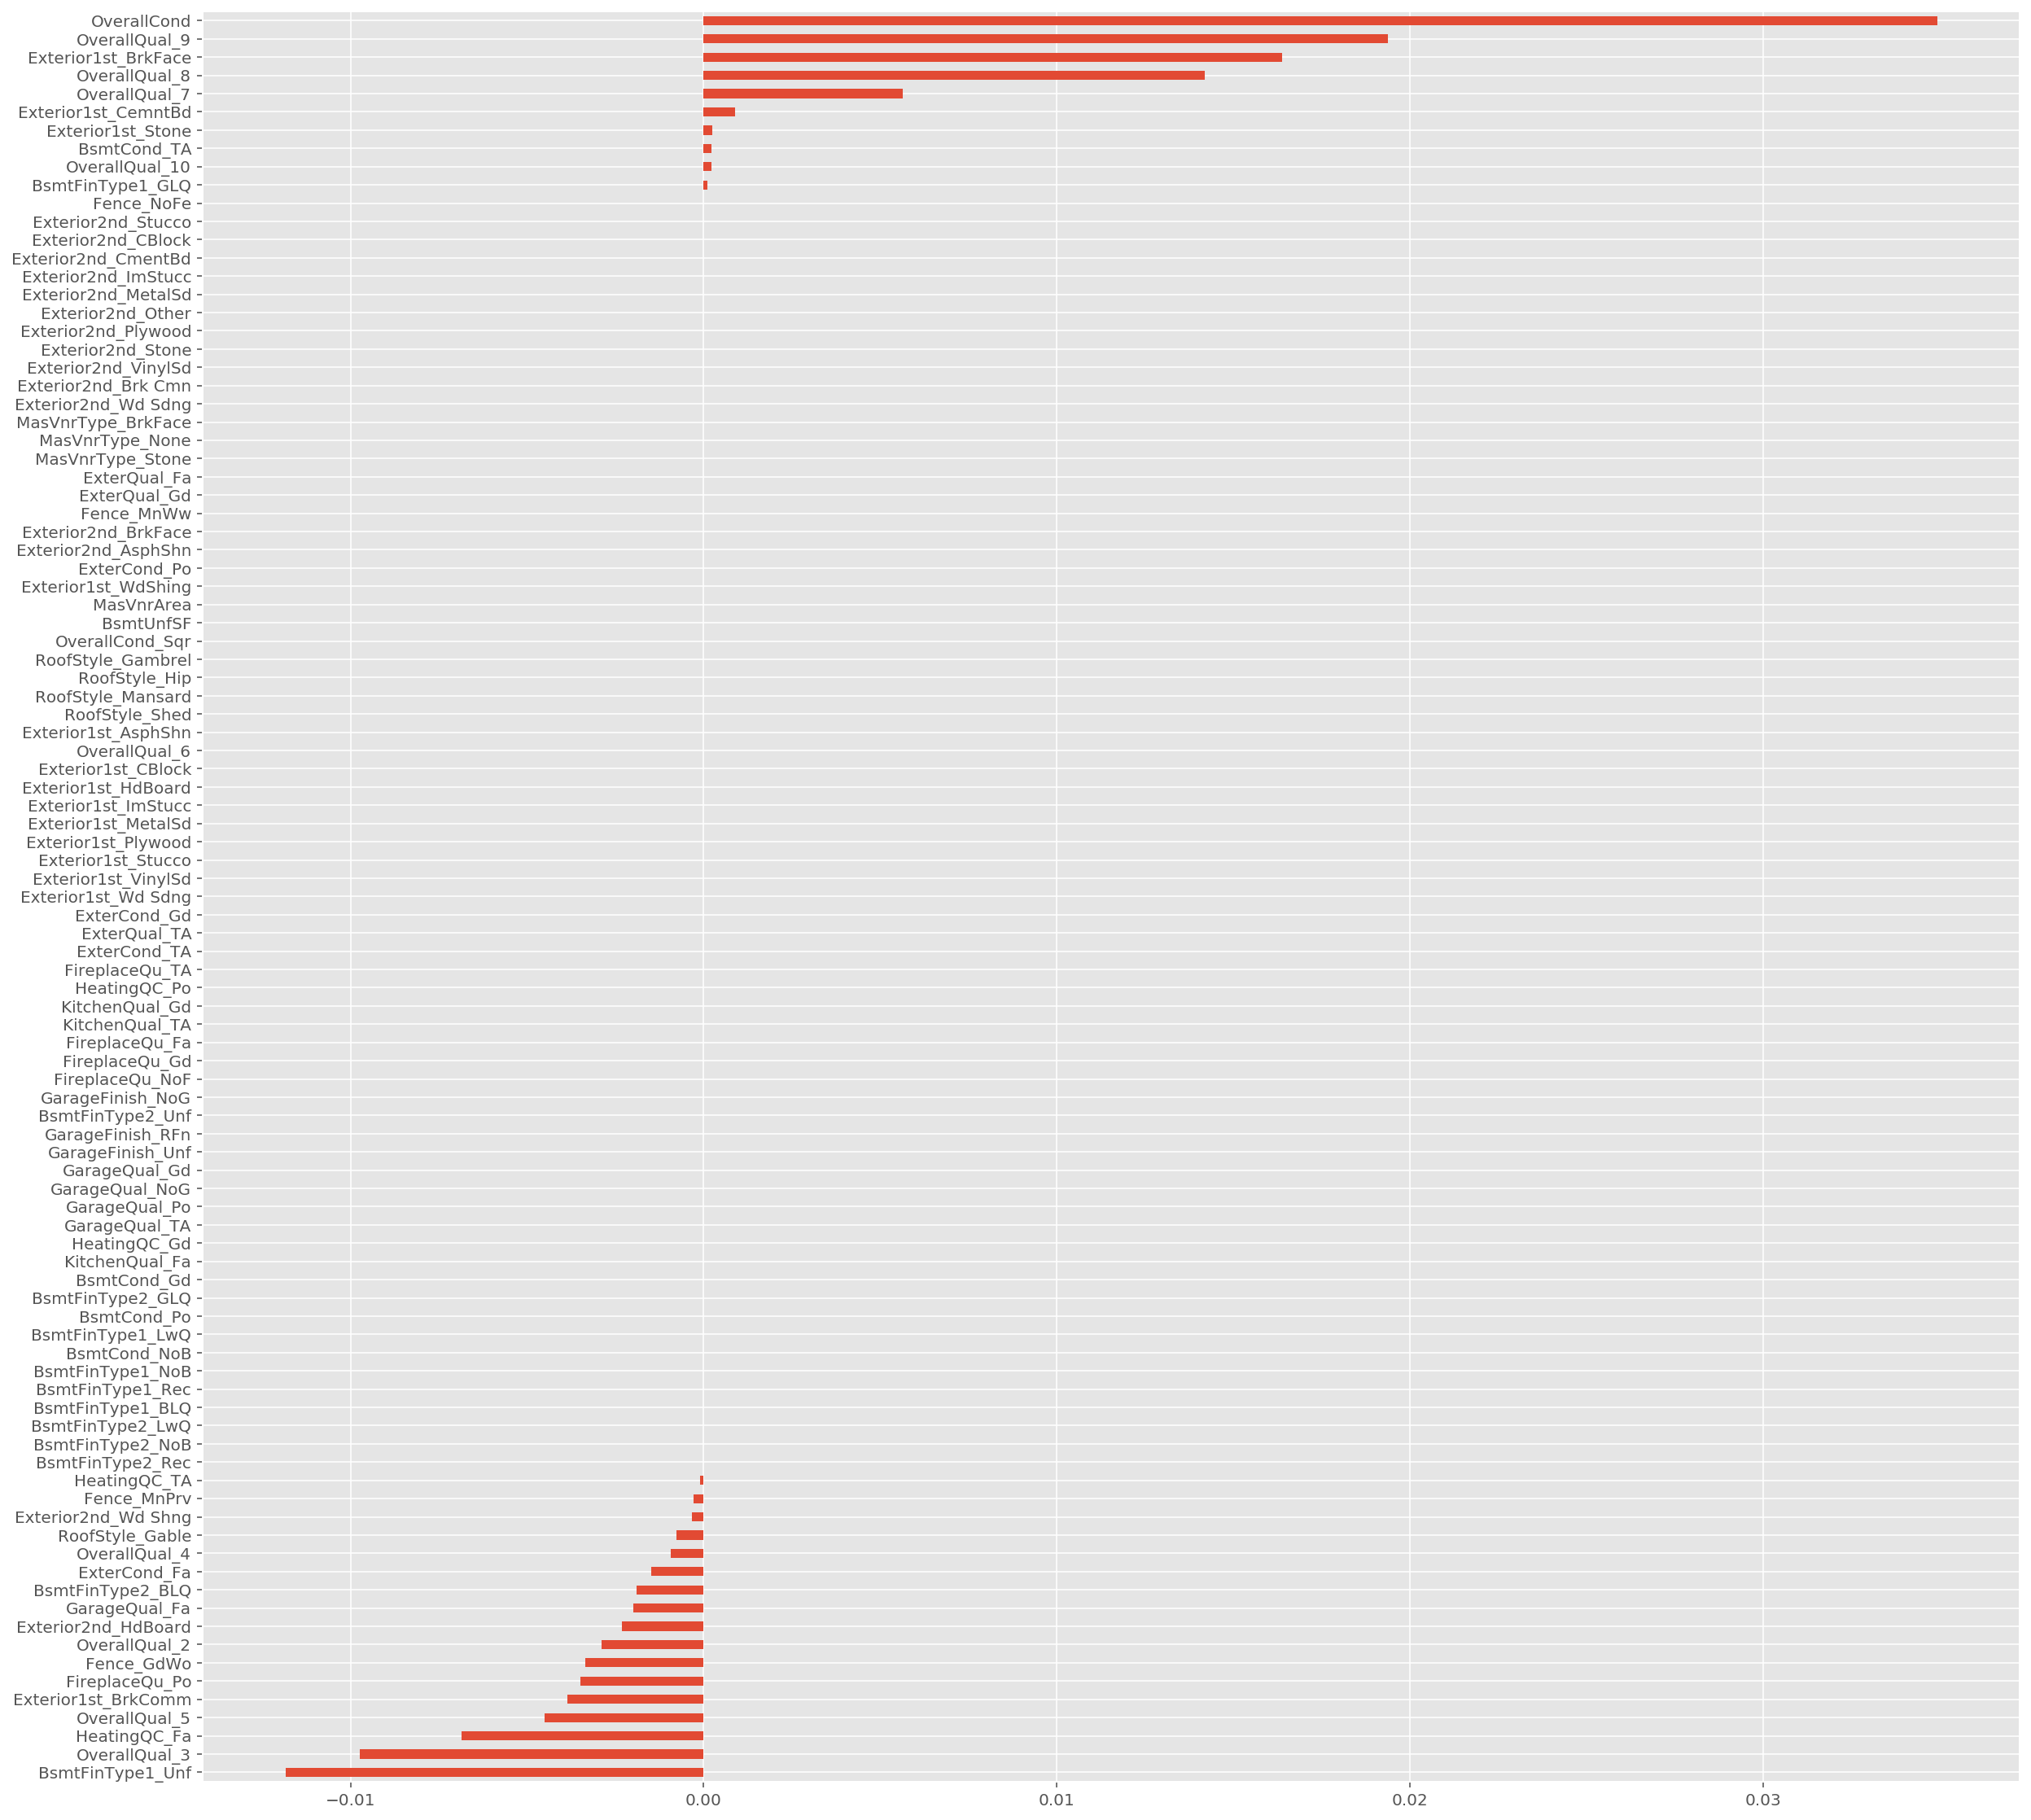

In [103]:
coef_lasso = pd.DataFrame(lassoCV.coef_, index=X_pre_std.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso'].sort_values().plot(kind='barh');

#### Cutting down the coefficients

In [104]:
coef_lasso.sort_values(by='coef_lasso_abs')

coef_lasso  coef_lasso_abs
BsmtCond_Gd            0.000000        0.000000
GarageQual_Gd          0.000000        0.000000
MasVnrType_BrkFace     0.000000        0.000000
MasVnrType_None       -0.000000        0.000000
MasVnrType_Stone      -0.000000        0.000000
ExterQual_Fa          -0.000000        0.000000
ExterQual_Gd           0.000000        0.000000
ExterQual_TA          -0.000000        0.000000
GarageFinish_Unf      -0.000000        0.000000
ExterCond_Gd          -0.000000        0.000000
ExterCond_Po           0.000000        0.000000
ExterCond_TA           0.000000        0.000000
GarageFinish_RFn      -0.000000        0.000000
BsmtCond_NoB           0.000000        0.000000
BsmtCond_Po           -0.000000        0.000000
GarageFinish_NoG       0.000000        0.000000
BsmtFinType1_BLQ      -0.000000        0.000000
BsmtFinType1_LwQ      -0.000000        0.000000
KitchenQual_Gd        -0.000000        0.000000
KitchenQual_Fa        -0.000000        0.000000
HeatingQC_Po          -0.000000        0.000000
HeatingQC_Gd          -0.000000        0.000000
FireplaceQu_Gd         0.000000        0.000000
BsmtFinType2_Unf       0.000000        0.000000
Exterior2nd_Wd Sdng    0.000000        0.000000
BsmtFinType2_Rec      -0.000000        0.000000
BsmtFinType2_LwQ      -0.000000        0.000000
BsmtFinType2_GLQ       0.000000        0.000000
FireplaceQu_NoF        0.000000        0.000000
FireplaceQu_TA        -0.000000        0.000000
BsmtFinType1_Rec       0.000000        0.000000
BsmtFinType1_NoB       0.000000        0.000000
BsmtFinType2_NoB       0.000000        0.000000
KitchenQual_TA        -0.000000        0.000000
Exterior2nd_VinylSd   -0.000000        0.000000
Exterior2nd_Stone     -0.000000        0.000000
Exterior1st_HdBoard   -0.000000        0.000000
GarageQual_TA         -0.000000        0.000000
Exterior1st_CBlock    -0.000000        0.000000
Fence_MnWw            -0.000000        0.000000
Fence_NoFe             0.000000        0.000000
Exterior1st_AsphShn    0.000000        0.000000
Exterior1st_ImStucc   -0.000000        0.000000
RoofStyle_Shed        -0.000000        0.000000
RoofStyle_Hip          0.000000        0.000000
RoofStyle_Gambrel      0.000000        0.000000
OverallQual_6         -0.000000        0.000000
OverallCond_Sqr        0.000000        0.000000
BsmtUnfSF             -0.000000        0.000000
MasVnrArea             0.000000        0.000000
RoofStyle_Mansard      0.000000        0.000000
Exterior2nd_Stucco    -0.000000        0.000000
FireplaceQu_Fa        -0.000000        0.000000
Exterior1st_Plywood   -0.000000        0.000000
Exterior2nd_Plywood   -0.000000        0.000000
Exterior2nd_Other     -0.000000        0.000000
Exterior2nd_MetalSd    0.000000        0.000000
Exterior2nd_ImStucc    0.000000        0.000000
GarageQual_NoG         0.000000        0.000000
Exterior2nd_CmentBd    0.000000        0.000000
Exterior1st_MetalSd    0.000000        0.000000
Exterior2nd_CBlock    -0.000000        0.000000
Exterior2nd_Brk Cmn   -0.000000        0.000000
Exterior2nd_AsphShn    0.000000        0.000000
Exterior1st_WdShing   -0.000000        0.000000
Exterior1st_Wd Sdng   -0.000000        0.000000
Exterior1st_VinylSd   -0.000000        0.000000
Exterior1st_Stucco    -0.000000        0.000000
GarageQual_Po         -0.000000        0.000000
Exterior2nd_BrkFace    0.000000        0.000000
BsmtFinType1_GLQ       0.000104        0.000104
HeatingQC_TA          -0.000110        0.000110
OverallQual_10         0.000223        0.000223
BsmtCond_TA            0.000231        0.000231
Exterior1st_Stone      0.000232        0.000232
Fence_MnPrv           -0.000281        0.000281
Exterior2nd_Wd Shng   -0.000335        0.000335
RoofStyle_Gable       -0.000781        0.000781
Exterior1st_CemntBd    0.000885        0.000885
OverallQual_4         -0.000927        0.000927
ExterCond_Fa          -0.001496        0.001496
BsmtFinType2_BLQ      -0.001894        0.001894
GarageQual_Fa         -0.001998      

In [105]:
coef_thres = np.linspace(coef_lasso.coef_lasso_abs.min(),
                         coef_lasso.coef_lasso_abs.max(), num=50)
mean_cv_scores = []
cols_dropped = []
for thres in coef_thres:
    good_coef = coef_lasso[coef_lasso.coef_lasso_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    lassoCV = LassoCV(n_alphas=100, cv=kf)
    lassoCV.fit(X_subset, y_pre_2010)
    lasso = Lasso(alpha=lassoCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        lasso, X_subset, y_pre_2010, cv=kf).mean())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004130964341637622, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004640255493827183, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046560876178034505, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020956708381483224, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003512713458283301, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003739102815751849, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not con

In [106]:
improve_lasso = pd.DataFrame({'coef_thres_lasso': coef_thres, 'mean_cv_scores_lasso': mean_cv_scores, 
                              'cols_dropped_num_lasso': cols_dropped})

In [107]:
improve_lasso = improve_lasso.sort_values(by=['mean_cv_scores_lasso', 'cols_dropped_num_lasso'], 
                                          ascending =[False, False])
improve_lasso[:10]

coef_thres_lasso  mean_cv_scores_lasso  cols_dropped_num_lasso
6           0.004276              0.189700                      88
7           0.004989              0.187984                      89
3           0.002138              0.178131                      83
4           0.002851              0.177919                      84
5           0.003563              0.174902                      87
2           0.001425              0.174411                      80
8           0.005701              0.173557                      90
9           0.006414              0.173557                      90
1           0.000713              0.172365                      77
10          0.007126              0.167471                      91

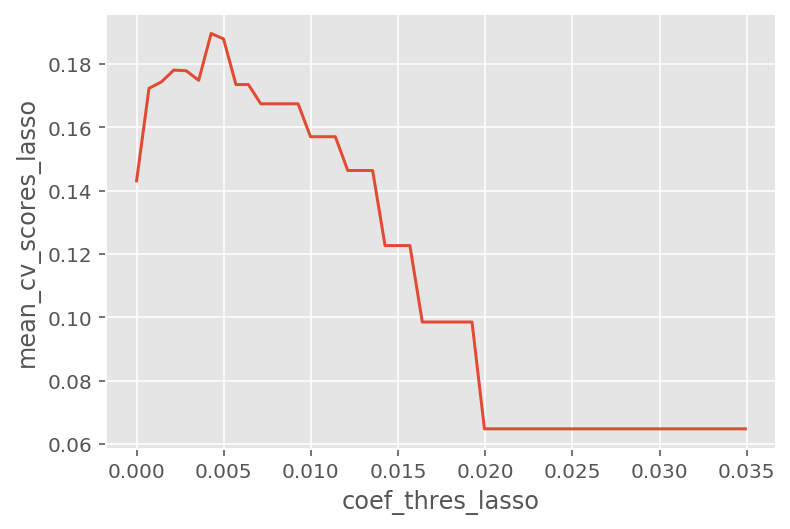

In [108]:
sns.lineplot(improve_lasso.coef_thres_lasso, improve_lasso.mean_cv_scores_lasso)

#### Optimal Lasso

In [109]:
opt_thres_lasso = improve_lasso['coef_thres_lasso'].iloc[0]
print(opt_thres_lasso)
columns_keep_lasso = coef_lasso[coef_lasso.coef_lasso_abs > opt_thres_lasso].index
X_opt = X_pre_std.loc[:, columns_keep_lasso]

0.004275858337601077


Optimal intercept(Lasso): -1.1582535130523907e-16
Optimal alpha (Lasso): 3.7011102061481725e-05
Optimal CV Score (Lasso): 0.18969961300870633
Optimal Train Score (Lasso): 0.19809100011258896
Optimal Test Score (Lasso): 0.08800860705882307


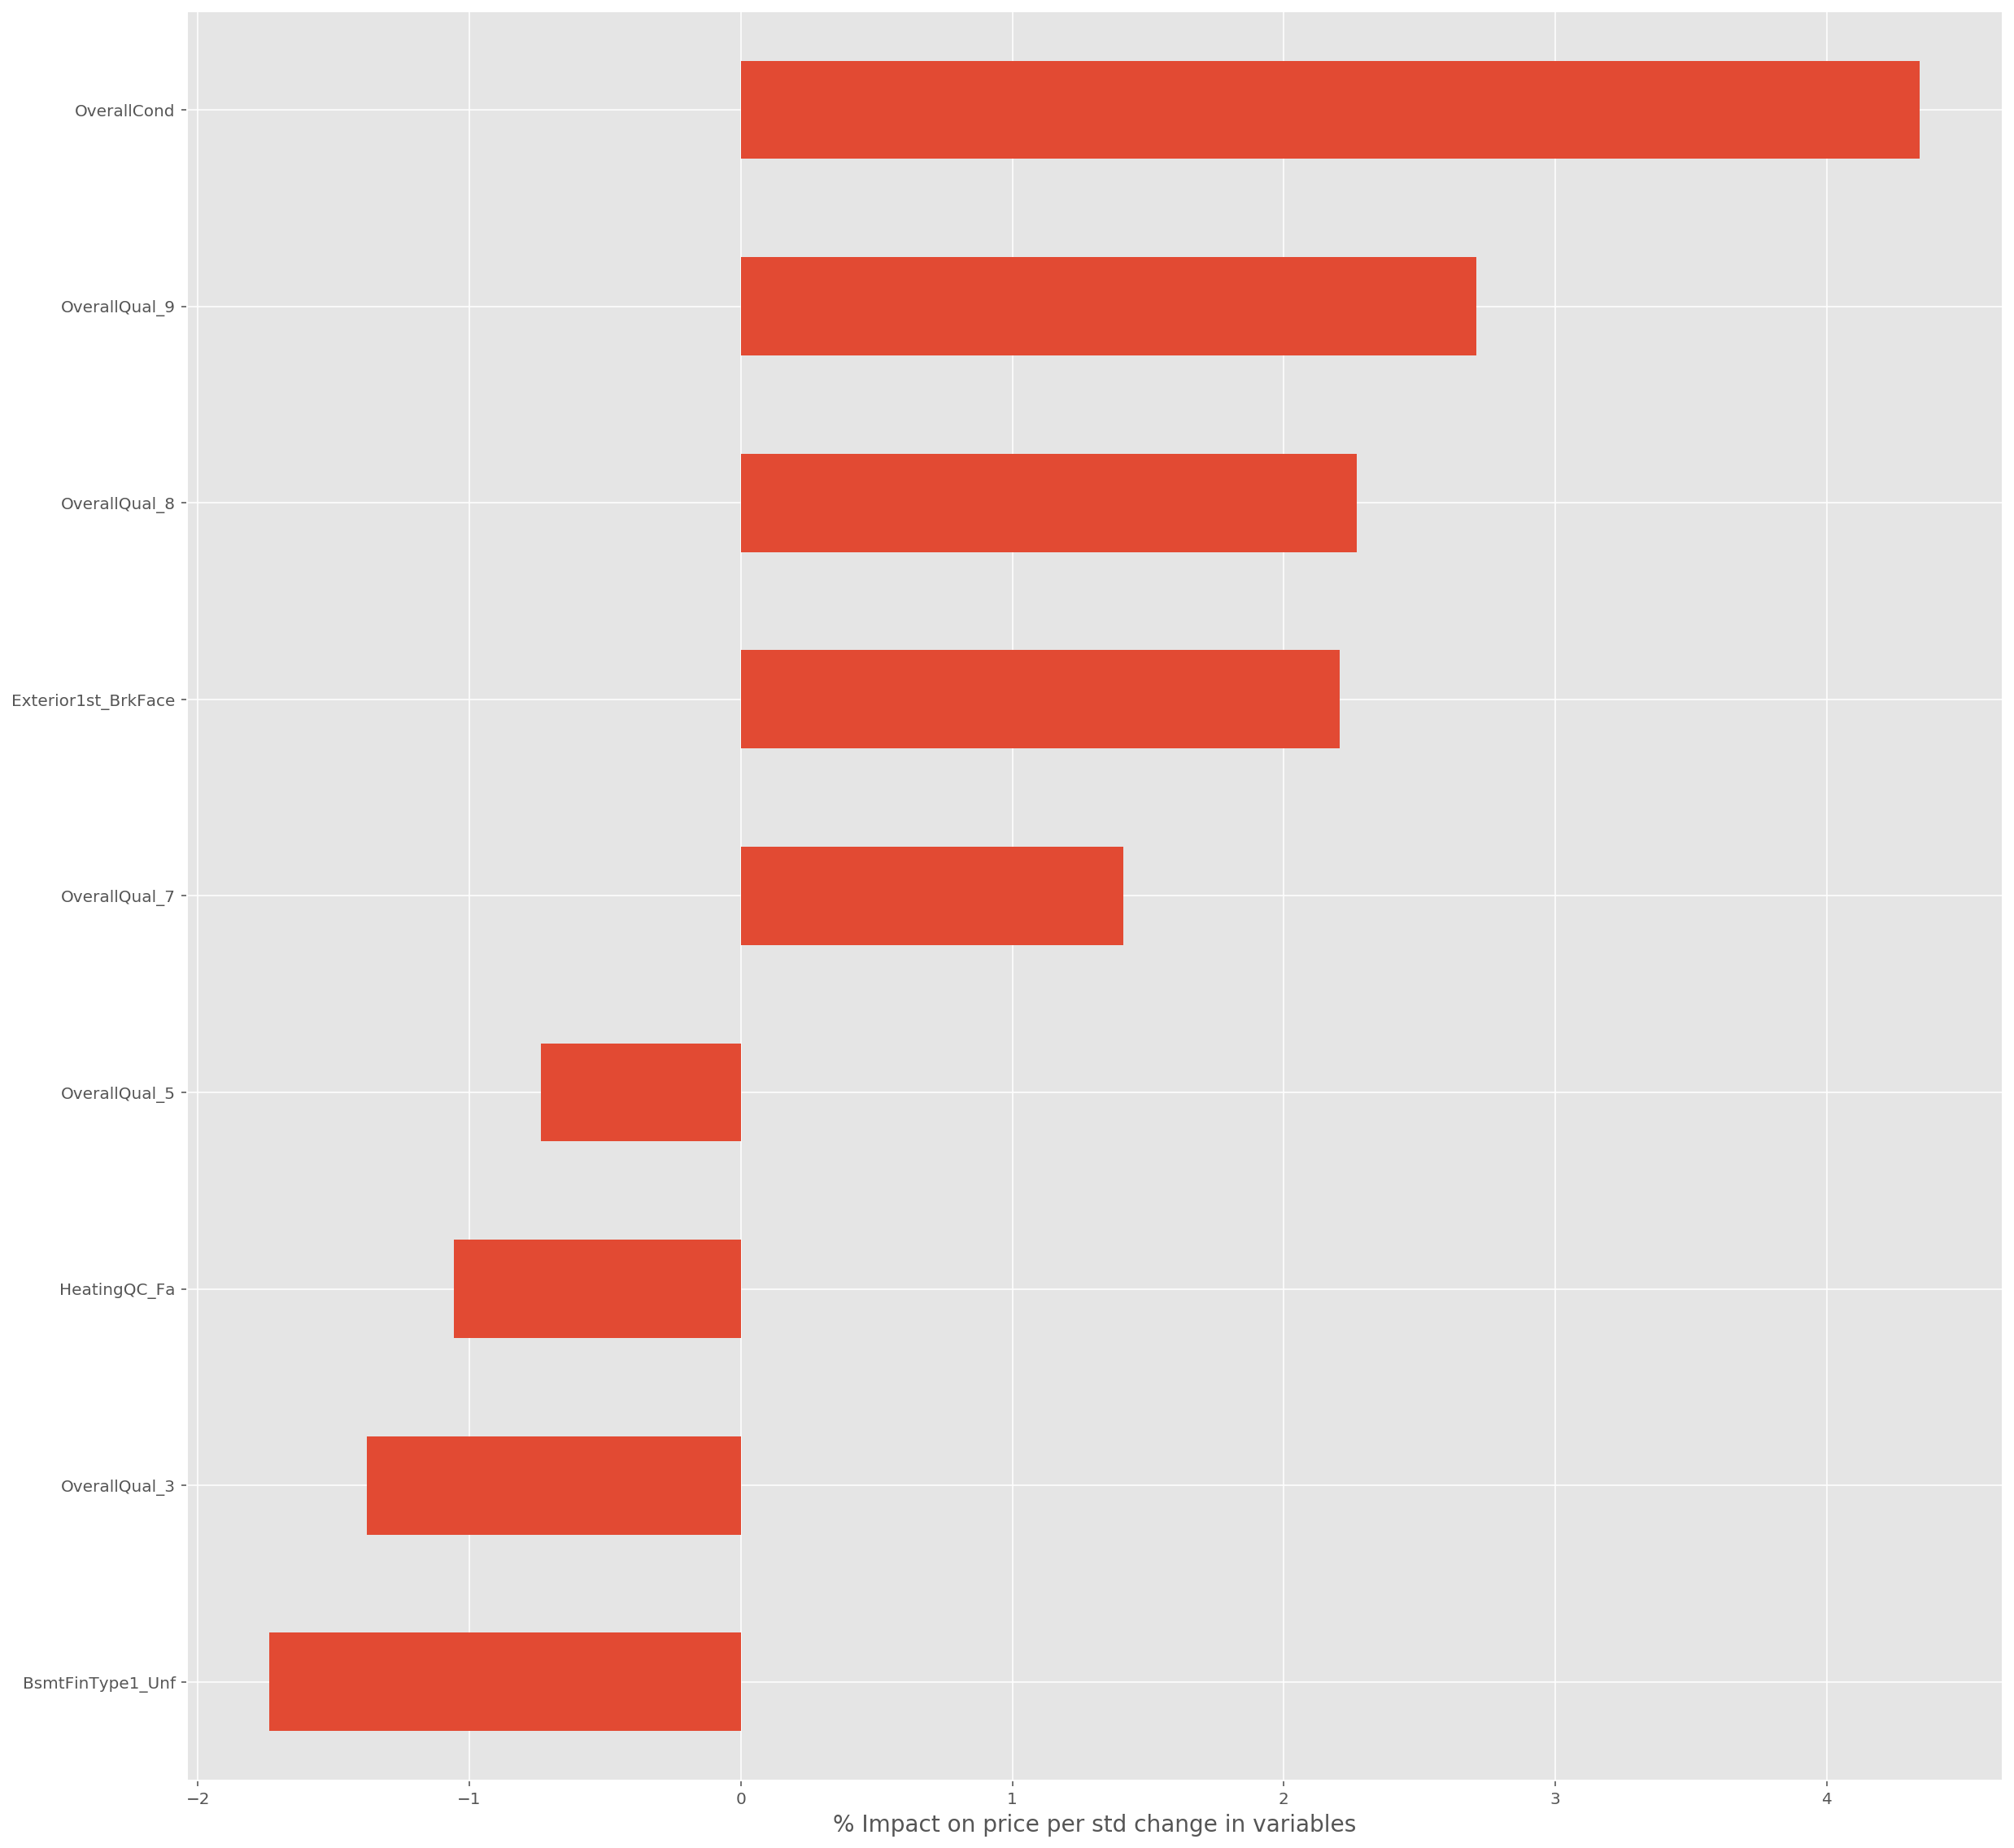

In [110]:
#Sense checking the optimal Lasso model
lassoCV_opt = LassoCV(n_alphas = 100, cv=kf)
lassoCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
lasso_opt = Lasso(alpha=lassoCV_opt.alpha_)


print(f'Optimal intercept(Lasso): {lassoCV_opt.intercept_}')
print(f'Optimal alpha (Lasso): {lassoCV_opt.alpha_}')
print(f'Optimal CV Score (Lasso): {cross_val_score(lasso_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Lasso): {lassoCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Lasso): {lassoCV_opt.score(X_post_std.loc[:, columns_keep_lasso], y_post_2010)}')


#Visualising the optimal coefficients
coef_lasso = pd.DataFrame(lassoCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_lasso'])
coef_lasso['coef_lasso_abs'] = coef_lasso.coef_lasso.abs()
coef_lasso['coef_lasso_price_impact'] = (np.exp(coef_lasso.coef_lasso)-1)*100

plt.figure(figsize = (20,20))
coef_lasso['coef_lasso_price_impact'].sort_values().plot(kind='barh')
plt.xlabel('% Impact on price per std change in variables', fontsize = 14);

### **Ridge CV - Ridge is again a Smidge Better!**

In [111]:
ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV.fit(X_pre_std, y_pre_2010)

train_score = ridgeCV.score(X_pre_std, y_pre_2010)
test_score = ridgeCV.score(X_post_std, y_post_2010)

#Cross Validation 
ridge = Ridge(alpha=ridgeCV.alpha_)
cv_score = cross_val_score(ridge, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {ridgeCV.intercept_}')
print(f'Model coeff: {ridgeCV.coef_}')
print(f'Model alpha: {ridgeCV.alpha_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Model intercept: -1.164824228377876e-16
Model coeff: [ 2.02207701e-02 -2.46724350e-03 -1.48058955e-03  1.48368451e-02
 -3.51363712e-03  1.06544148e-03 -3.40192403e-04  5.07254364e-03
 -2.68391086e-04  0.00000000e+00 -7.76546109e-03  1.73264219e-02
  2.26695115e-04  1.03192950e-03 -1.61781040e-03 -1.78866411e-03
  1.01855721e-03 -1.54720836e-04  5.58614251e-03  5.25420331e-03
 -1.67101370e-03 -7.94128574e-03 -1.60468920e-03 -1.40357949e-03
  1.43889433e-03  1.10784627e-03  2.26695115e-04  1.38561086e-03
 -6.23736563e-03  4.31606197e-03  1.09250573e-03 -2.42755864e-03
 -3.08388048e-03 -5.18755039e-03 -8.85466209e-03 -3.26729623e-03
  6.74981617e-03 -4.12786506e-03  5.82268439e-03  6.06212300e-04
 -2.22803265e-03 -1.73243805e-03  6.62430501e-04  1.48778409e-03
 -4.13259513e-03 -2.78516640e-03  0.00000000e+00  1.28243469e-03
  7.54519904e-03  3.49203271e-03 -2.73414390e-03  1.11714571e-02
  1.92670708e-03  7.30124498e-04  8.55703231e-05  3.49203271e-03
  3.61245040e-03 -1.37168509e-02 -6.7

#### Visualising coefficients

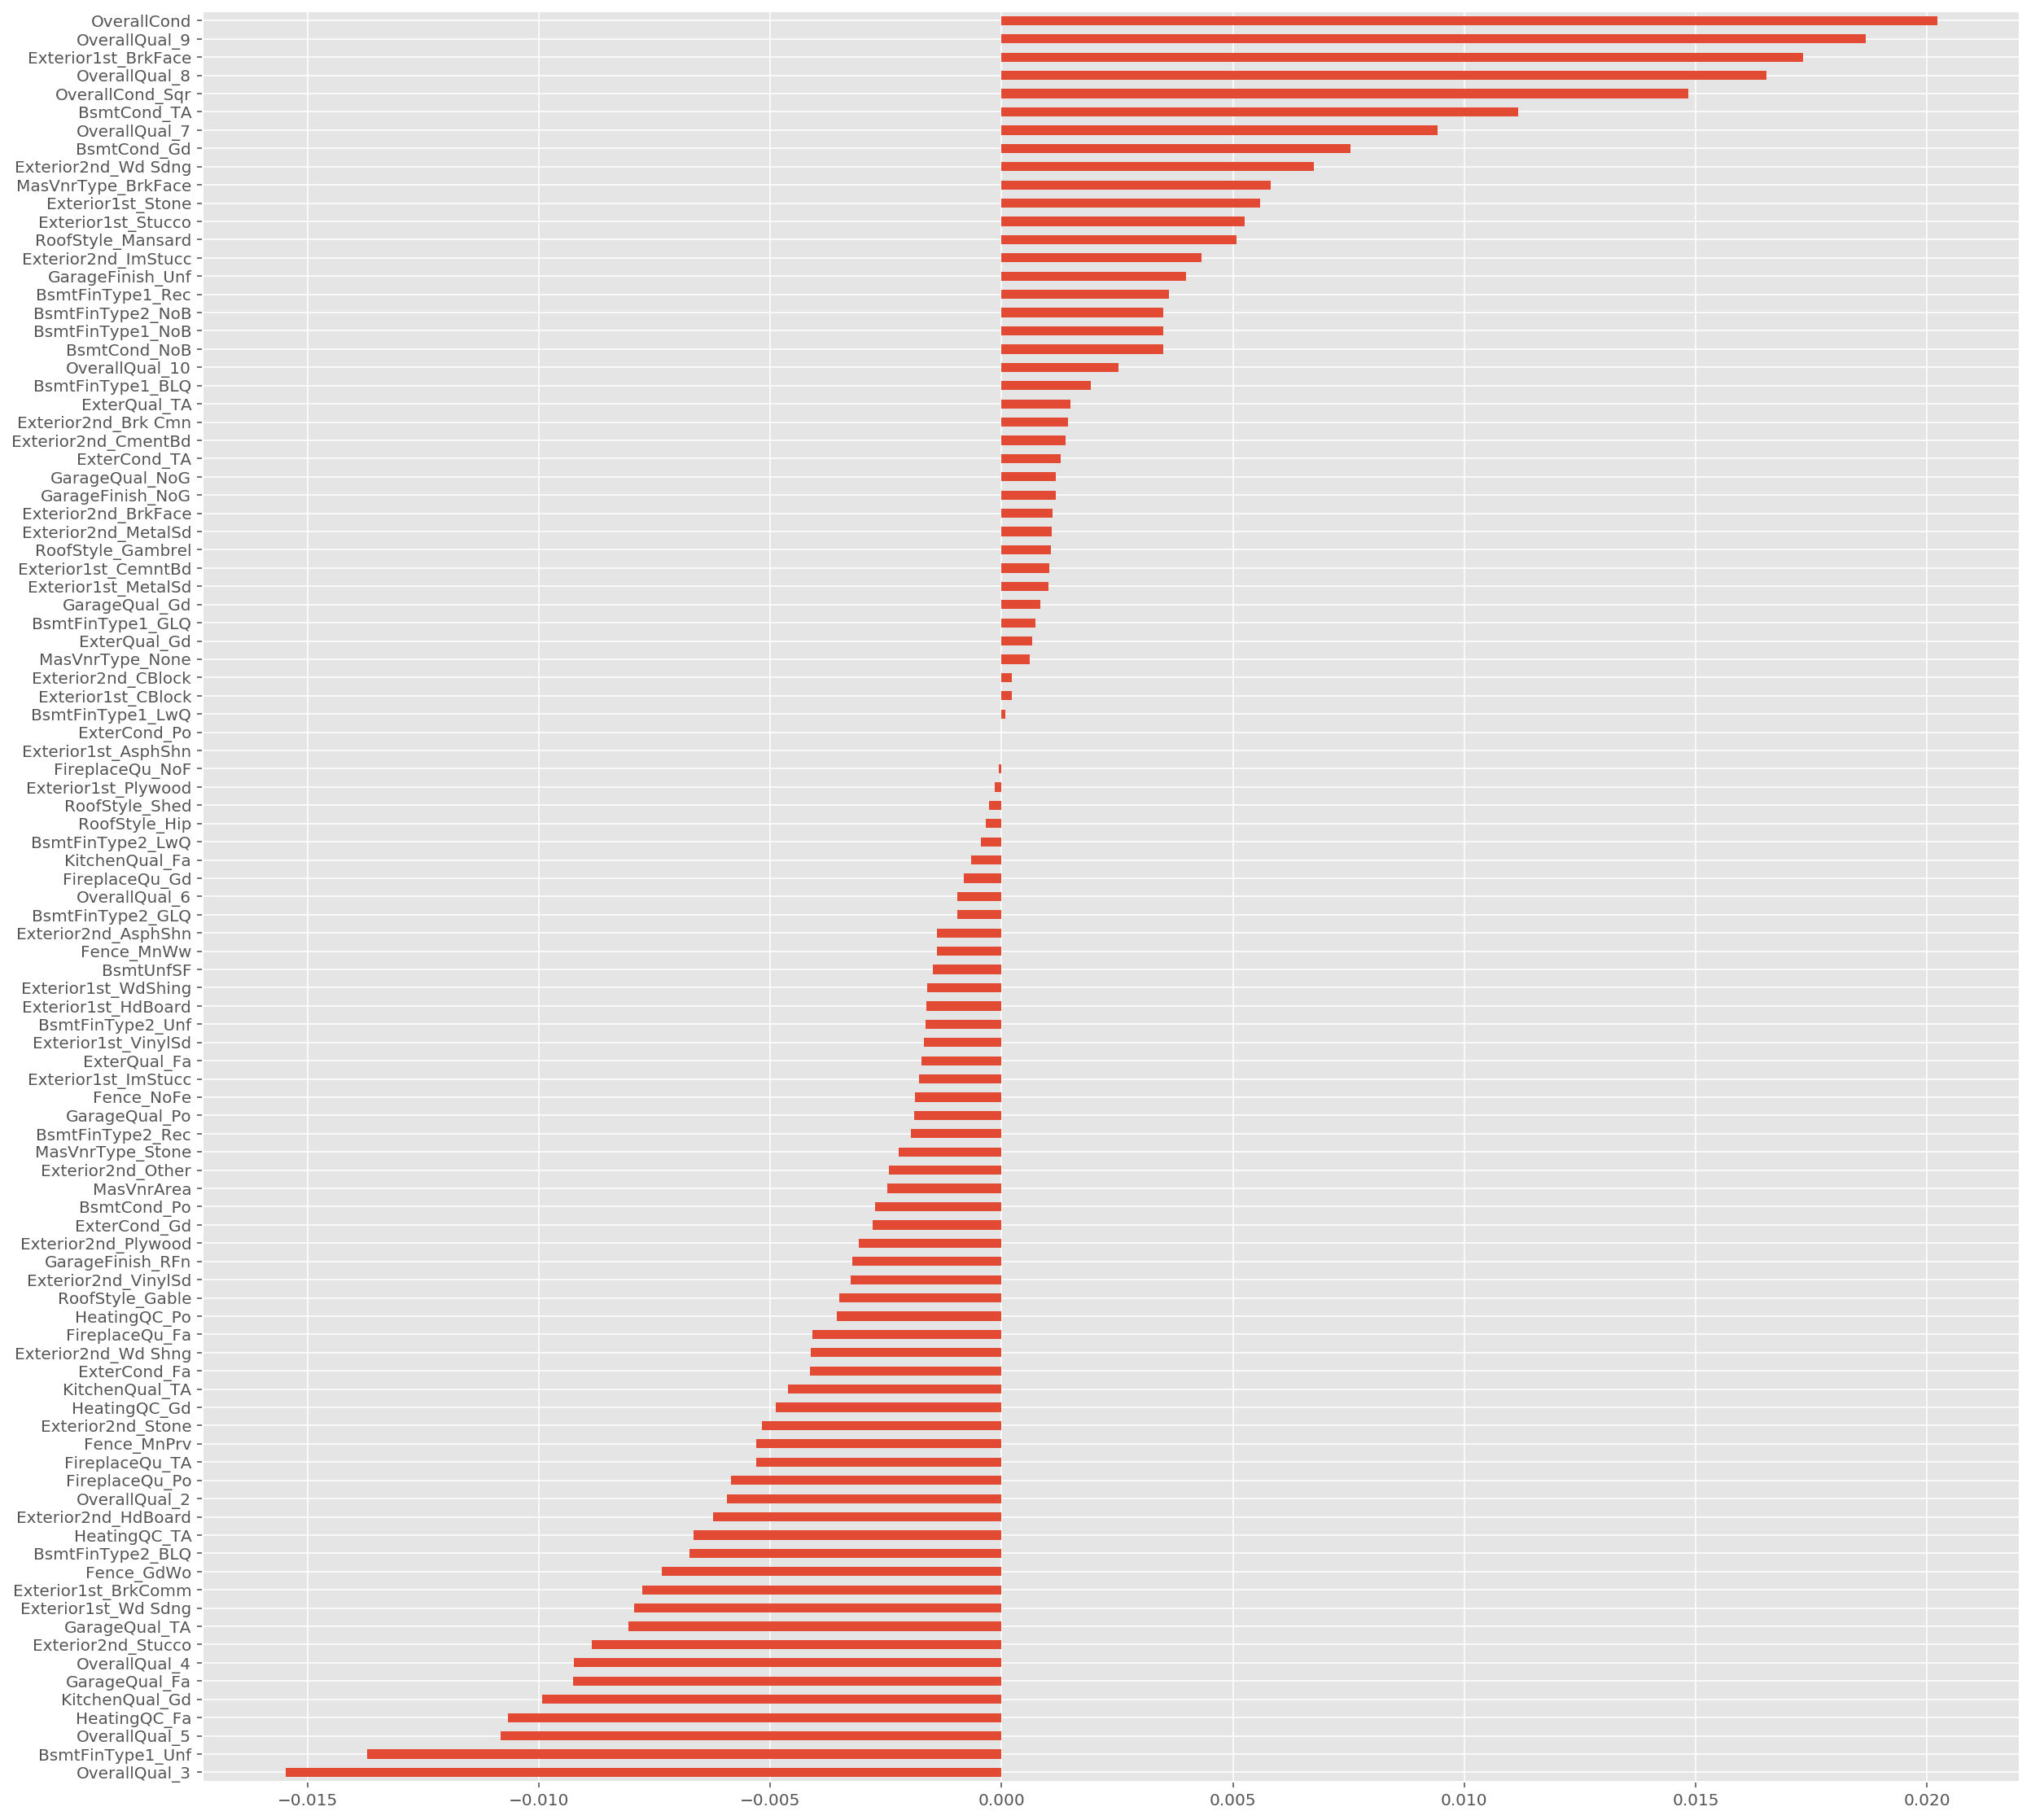

In [112]:
coef_ridge= pd.DataFrame(ridgeCV.coef_, index=X_pre_std.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge'].sort_values().plot(kind='barh');

#### Cutting down the coefficients

In [113]:
coef_ridge.sort_values(by='coef_ridge_abs')

coef_ridge  coef_ridge_abs
ExterCond_Po           0.000000        0.000000
Exterior1st_AsphShn    0.000000        0.000000
FireplaceQu_NoF       -0.000053        0.000053
BsmtFinType1_LwQ       0.000086        0.000086
Exterior1st_Plywood   -0.000155        0.000155
Exterior1st_CBlock     0.000227        0.000227
Exterior2nd_CBlock     0.000227        0.000227
RoofStyle_Shed        -0.000268        0.000268
RoofStyle_Hip         -0.000340        0.000340
BsmtFinType2_LwQ      -0.000442        0.000442
MasVnrType_None        0.000606        0.000606
KitchenQual_Fa        -0.000655        0.000655
ExterQual_Gd           0.000662        0.000662
BsmtFinType1_GLQ       0.000730        0.000730
FireplaceQu_Gd        -0.000817        0.000817
GarageQual_Gd          0.000832        0.000832
OverallQual_6         -0.000960        0.000960
BsmtFinType2_GLQ      -0.000964        0.000964
Exterior1st_MetalSd    0.001019        0.001019
Exterior1st_CemntBd    0.001032        0.001032
RoofStyle_Gambrel      0.001065        0.001065
Exterior2nd_MetalSd    0.001093        0.001093
Exterior2nd_BrkFace    0.001108        0.001108
GarageFinish_NoG       0.001174        0.001174
GarageQual_NoG         0.001174        0.001174
ExterCond_TA           0.001282        0.001282
Exterior2nd_CmentBd    0.001386        0.001386
Exterior2nd_AsphShn   -0.001404        0.001404
Fence_MnWw            -0.001404        0.001404
Exterior2nd_Brk Cmn    0.001439        0.001439
BsmtUnfSF             -0.001481        0.001481
ExterQual_TA           0.001488        0.001488
Exterior1st_WdShing   -0.001605        0.001605
Exterior1st_HdBoard   -0.001618        0.001618
BsmtFinType2_Unf      -0.001636        0.001636
Exterior1st_VinylSd   -0.001671        0.001671
ExterQual_Fa          -0.001732        0.001732
Exterior1st_ImStucc   -0.001789        0.001789
Fence_NoFe            -0.001865        0.001865
GarageQual_Po         -0.001888        0.001888
BsmtFinType1_BLQ       0.001927        0.001927
BsmtFinType2_Rec      -0.001963        0.001963
MasVnrType_Stone      -0.002228        0.002228
Exterior2nd_Other     -0.002428        0.002428
MasVnrArea            -0.002467        0.002467
OverallQual_10         0.002518        0.002518
BsmtCond_Po           -0.002734        0.002734
ExterCond_Gd          -0.002785        0.002785
Exterior2nd_Plywood   -0.003084        0.003084
GarageFinish_RFn      -0.003220        0.003220
Exterior2nd_VinylSd   -0.003267        0.003267
BsmtFinType1_NoB       0.003492        0.003492
BsmtCond_NoB           0.003492        0.003492
BsmtFinType2_NoB       0.003492        0.003492
RoofStyle_Gable       -0.003514        0.003514
HeatingQC_Po          -0.003563        0.003563
BsmtFinType1_Rec       0.003612        0.003612
GarageFinish_Unf       0.003989        0.003989
FireplaceQu_Fa        -0.004086        0.004086
Exterior2nd_Wd Shng   -0.004128        0.004128
ExterCond_Fa          -0.004133        0.004133
Exterior2nd_ImStucc    0.004316        0.004316
KitchenQual_TA        -0.004615        0.004615
HeatingQC_Gd          -0.004880        0.004880
RoofStyle_Mansard      0.005073        0.005073
Exterior2nd_Stone     -0.005188        0.005188
Exterior1st_Stucco     0.005254        0.005254
Fence_MnPrv           -0.005301        0.005301
FireplaceQu_TA        -0.005306        0.005306
Exterior1st_Stone      0.005586        0.005586
MasVnrType_BrkFace     0.005823        0.005823
FireplaceQu_Po        -0.005843        0.005843
OverallQual_2         -0.005934        0.005934
Exterior2nd_HdBoard   -0.006237        0.006237
HeatingQC_TA          -0.006655        0.006655
Exterior2nd_Wd Sdng    0.006750        0.006750
BsmtFinType2_BLQ      -0.006750        0.006750
Fence_GdWo            -0.007350        0.007350
BsmtCond_Gd            0.007545        0.007545
Exterior1st_BrkComm   -0.007765        0.007765
Exterior1st_Wd Sdng   -0.007941        0.007941
GarageQual_TA         -0.008067        0.008067
Exterior2nd_Stucco    -0.008855      

In [114]:
coef_thres = np.linspace(coef_ridge.coef_ridge_abs.min(),
                         0.0125, num=50)
mean_cv_scores = []
cols_dropped = []

for thres in coef_thres:
    good_coef = coef_ridge[coef_ridge.coef_ridge_abs >= thres].index
    cols_dropped.append(len(X_pre_std.columns) - len(good_coef))

    X_subset = X_pre_std.loc[:, good_coef]

    ridgeCV = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
    ridgeCV.fit(X_subset, y_pre_2010)
    ridge = Ridge(alpha=ridgeCV.alpha_)
    mean_cv_scores.append(cross_val_score(
        ridge, X_subset, y_pre_2010, cv=kf).mean())

In [115]:
improve_ridge = pd.DataFrame({'coef_thres_ridge': coef_thres, 'mean_cv_scores_ridge': mean_cv_scores, 
                              'cols_dropped_num_ridge': cols_dropped})

In [116]:
improve_ridge = improve_ridge.sort_values(by=['mean_cv_scores_ridge', 'cols_dropped_num_ridge'], 
                                          ascending =[False, False])
improve_ridge[:10]

coef_thres_ridge  mean_cv_scores_ridge  cols_dropped_num_ridge
35          0.008929              0.198993                      83
36          0.009184              0.198993                      83
31          0.007908              0.192101                      80
39          0.009949              0.190137                      87
40          0.010204              0.190137                      87
41          0.010459              0.190137                      87
37          0.009439              0.189394                      86
38          0.009694              0.189394                      86
32          0.008163              0.188049                      82
33          0.008418              0.188049                      82

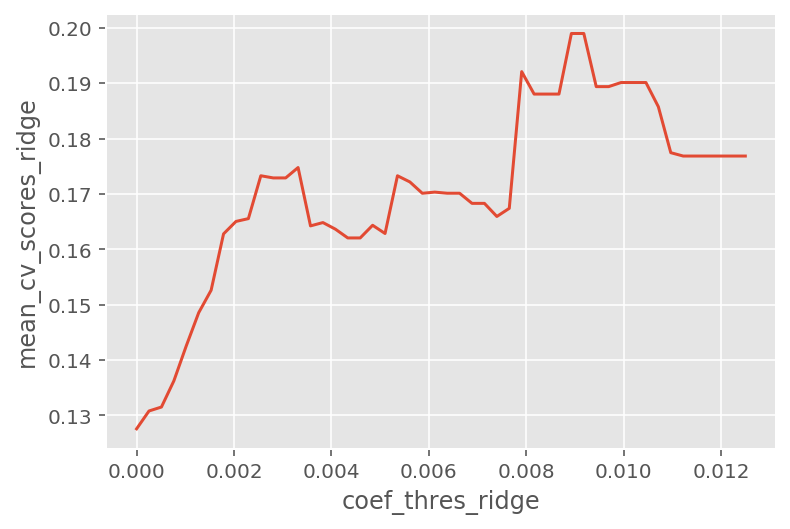

In [117]:
sns.lineplot(improve_ridge.coef_thres_ridge, improve_ridge.mean_cv_scores_ridge)

#### Optimal Ridge

In [118]:
opt_thres_ridge = improve_ridge['coef_thres_ridge'].iloc[0]
columns_keep_ridge = coef_ridge[coef_ridge.coef_ridge_abs > opt_thres_ridge].index
X_opt = X_pre_std.loc[:, columns_keep_ridge]
print(opt_thres_ridge)

0.00892857142857143


Optimal intercept(Ridge): -9.800344704191896e-17
Optimal alpha (Ridge): 0.3593813663804626
Optimal CV Score (Ridge): 0.19899268469835557
Optimal Train Score (Ridge): 0.21182063618875066
Optimal Test Score (Ridge): 0.10779911217136973


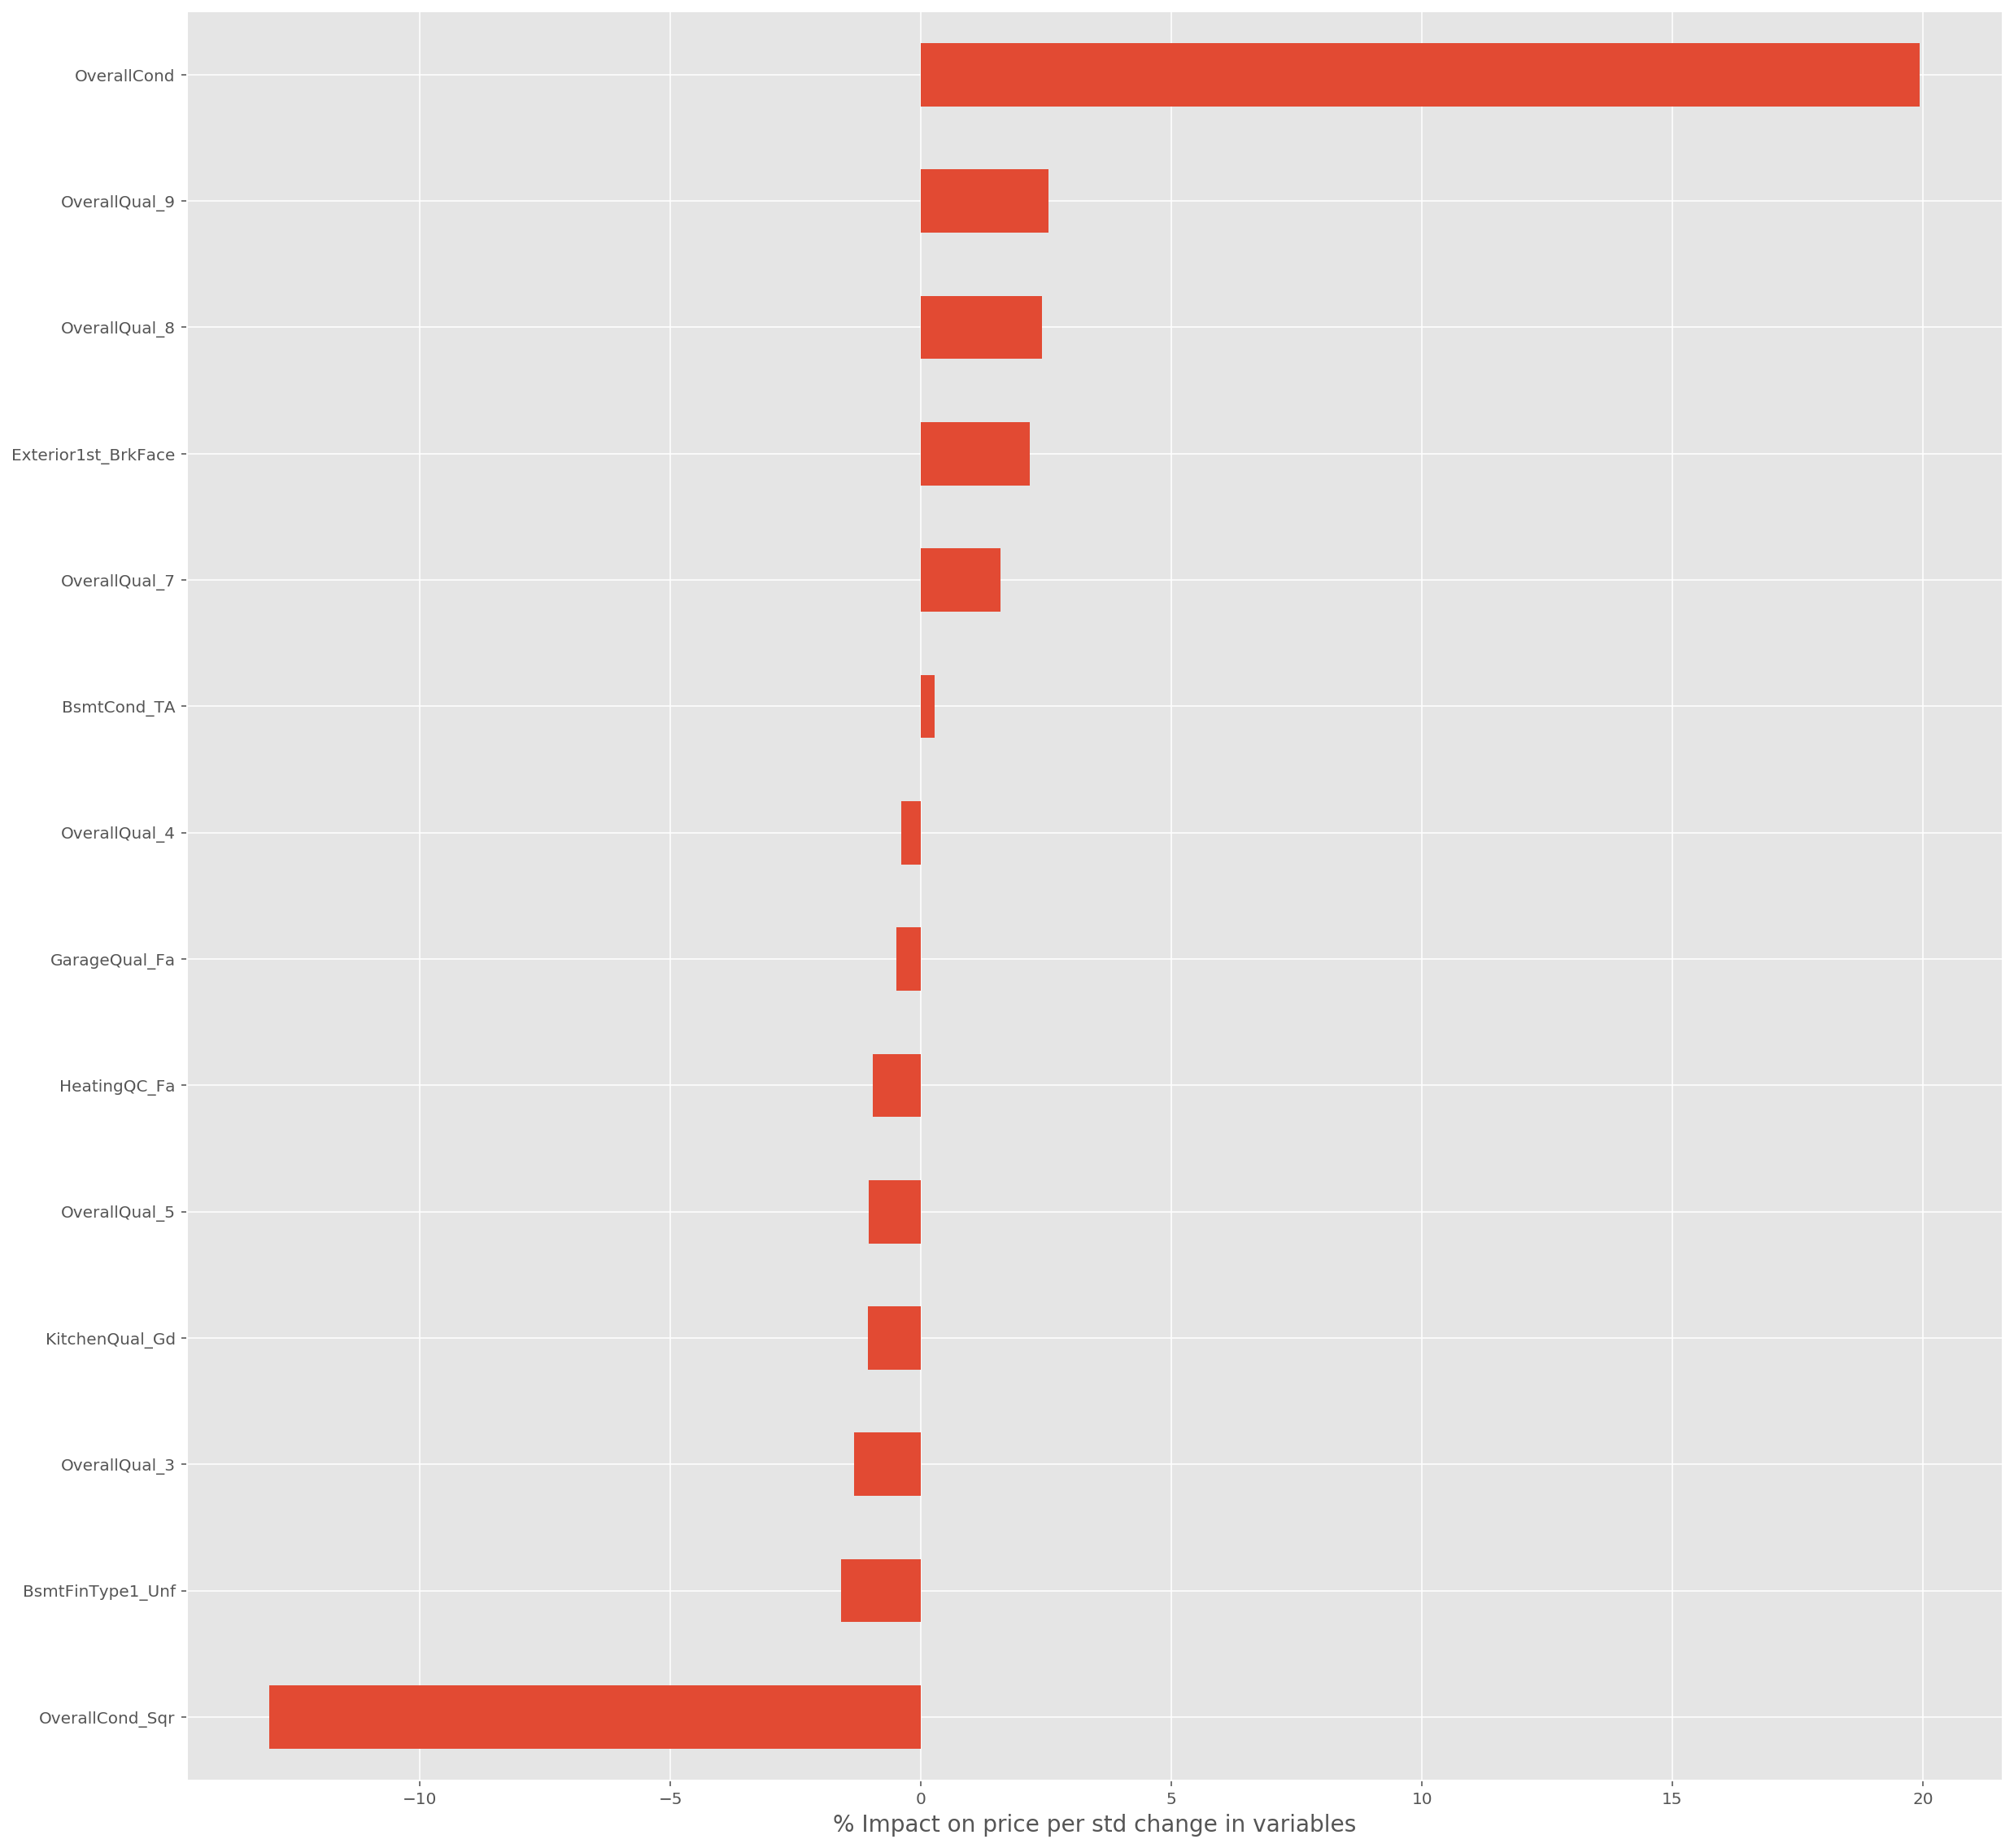

In [119]:
#Sense checking the optimal Ridge model
ridgeCV_opt = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=kf)
ridgeCV_opt.fit(X_opt, y_pre_2010)

#Cross Validation 
ridge_opt = Ridge(alpha=ridgeCV_opt.alpha_)

print(f'Optimal intercept(Ridge): {ridgeCV_opt.intercept_}')
print(f'Optimal alpha (Ridge): {ridgeCV_opt.alpha_}')
print(f'Optimal CV Score (Ridge): {cross_val_score(ridge_opt, X_opt, y_pre_2010, cv = kf).mean()}')
print(f'Optimal Train Score (Ridge): {ridgeCV_opt.score(X_opt, y_pre_2010)}')
print(f'Optimal Test Score (Ridge): {ridgeCV_opt.score(X_post_std.loc[:, columns_keep_ridge], y_post_2010)}')

#Visualising the optimal coefficients 
coef_ridge = pd.DataFrame(ridgeCV_opt.coef_, index=X_opt.columns,
                       columns=['coef_ridge'])
coef_ridge['coef_ridge_abs'] = coef_ridge.coef_ridge.abs()
coef_ridge['coef_ridge_price_impact'] = 100*(np.exp(coef_ridge.coef_ridge)-1)

plt.figure(figsize = (20,20))
coef_ridge['coef_ridge_price_impact'].sort_values().plot(kind='barh');
plt.xlabel('% Impact on price per std change in variables', fontsize = 14);

### **ElasticNet CV**

In [120]:
elasticnetCV = ElasticNetCV(n_alphas = 100, l1_ratio=np.array([.8, .85, .9, .95, .97, .99, 1]), cv=kf)
elasticnetCV.fit(X_pre_std, y_pre_2010)

train_score = elasticnetCV.score(X_pre_std, y_pre_2010)
test_score = elasticnetCV.score(X_post_std, y_post_2010)

#Cross Validation 
elasticnet = ElasticNet(alpha=elasticnetCV.alpha_, l1_ratio = elasticnetCV.l1_ratio_)
cv_score = cross_val_score(elasticnet, X_pre_std, y_pre_2010, cv = kf).mean()

print(f'Model intercept: {elasticnetCV.intercept_}')
print(f'Model coeff: {elasticnetCV.coef_}')
print(f'Model alpha: {elasticnetCV.alpha_}')
print(f'Model l1_ratio: {elasticnetCV.l1_ratio_}')
print(f'CV Score: {cv_score}')
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036222443384197334, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00413067708033843, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041868605035624284, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003140557744814032, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003352219773947951, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003376463920627515, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not conv

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037671845533608916, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004277129149237169, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004322726548490863, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032409040357457286, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003460776697092882, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034769365627536075, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008541094394169946, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008474129025705324, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038999177004050978, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033332932254257486, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003560502518073605, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035689238514162724, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004020953026962815, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004531388877270004, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004556888046893803, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not c

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034182113176015605, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003652320866001091, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036533966219813863, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004066345733940935, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045763934278646445, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004598003406940165, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020302249295767183, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034563669155840415, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003687807444768154, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008267904420812044, tolerance: 0.0019712880526730845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004109896573510241, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004619474009771807, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not c

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020745138370052985, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034943019718092216, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037223035459472698, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not c

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004130964341637622, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004640255493827183, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0046560876178034505, tolerance: 0.0021406701245842022
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020956708381483224, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003512713458283301, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003739102815751849, tolerance: 0.001995910195370688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not con

Model intercept: -1.1571839126088596e-16
Model coeff: [ 3.54304644e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -9.55476342e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -4.10605355e-03  1.68155238e-02
 -0.00000000e+00  1.09893241e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.01991493e-04 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -2.70329362e-03  0.00000000e+00  6.51420717e-05 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -7.06649741e-04  1.07316502e-04 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.63642594e-03 -0.00000000e+00  0.00000000e+00  7.34456885e-05
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  4.30769568e-04
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.23442338e-02 -2.

### Q3

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

### Combining the features into one clean dataframe

In [121]:
# A:
house_renov.shape
house_fixed.shape

(1450, 34)

In [122]:
house_full_clean = pd.concat([house_fixed, house_renov], axis =1)

In [123]:
house_full_clean.shape

(1450, 54)

### Reducing categories

In [124]:
house_full_clean.SaleCondition.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [125]:
house_full_clean['SaleCategory'] = house_full_clean.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 0).astype('int')

### Baseline accuracy

In [126]:
house_full_clean.SaleCategory.value_counts(normalize=True)

0    0.933793
1    0.066207
Name: SaleCategory, dtype: float64

### Feature Selection

In [127]:
house_full_clean.select_dtypes(include='object').columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual',
       'GarageType', 'SaleType', 'SaleCondition', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'Fence'],
      dtype='object')

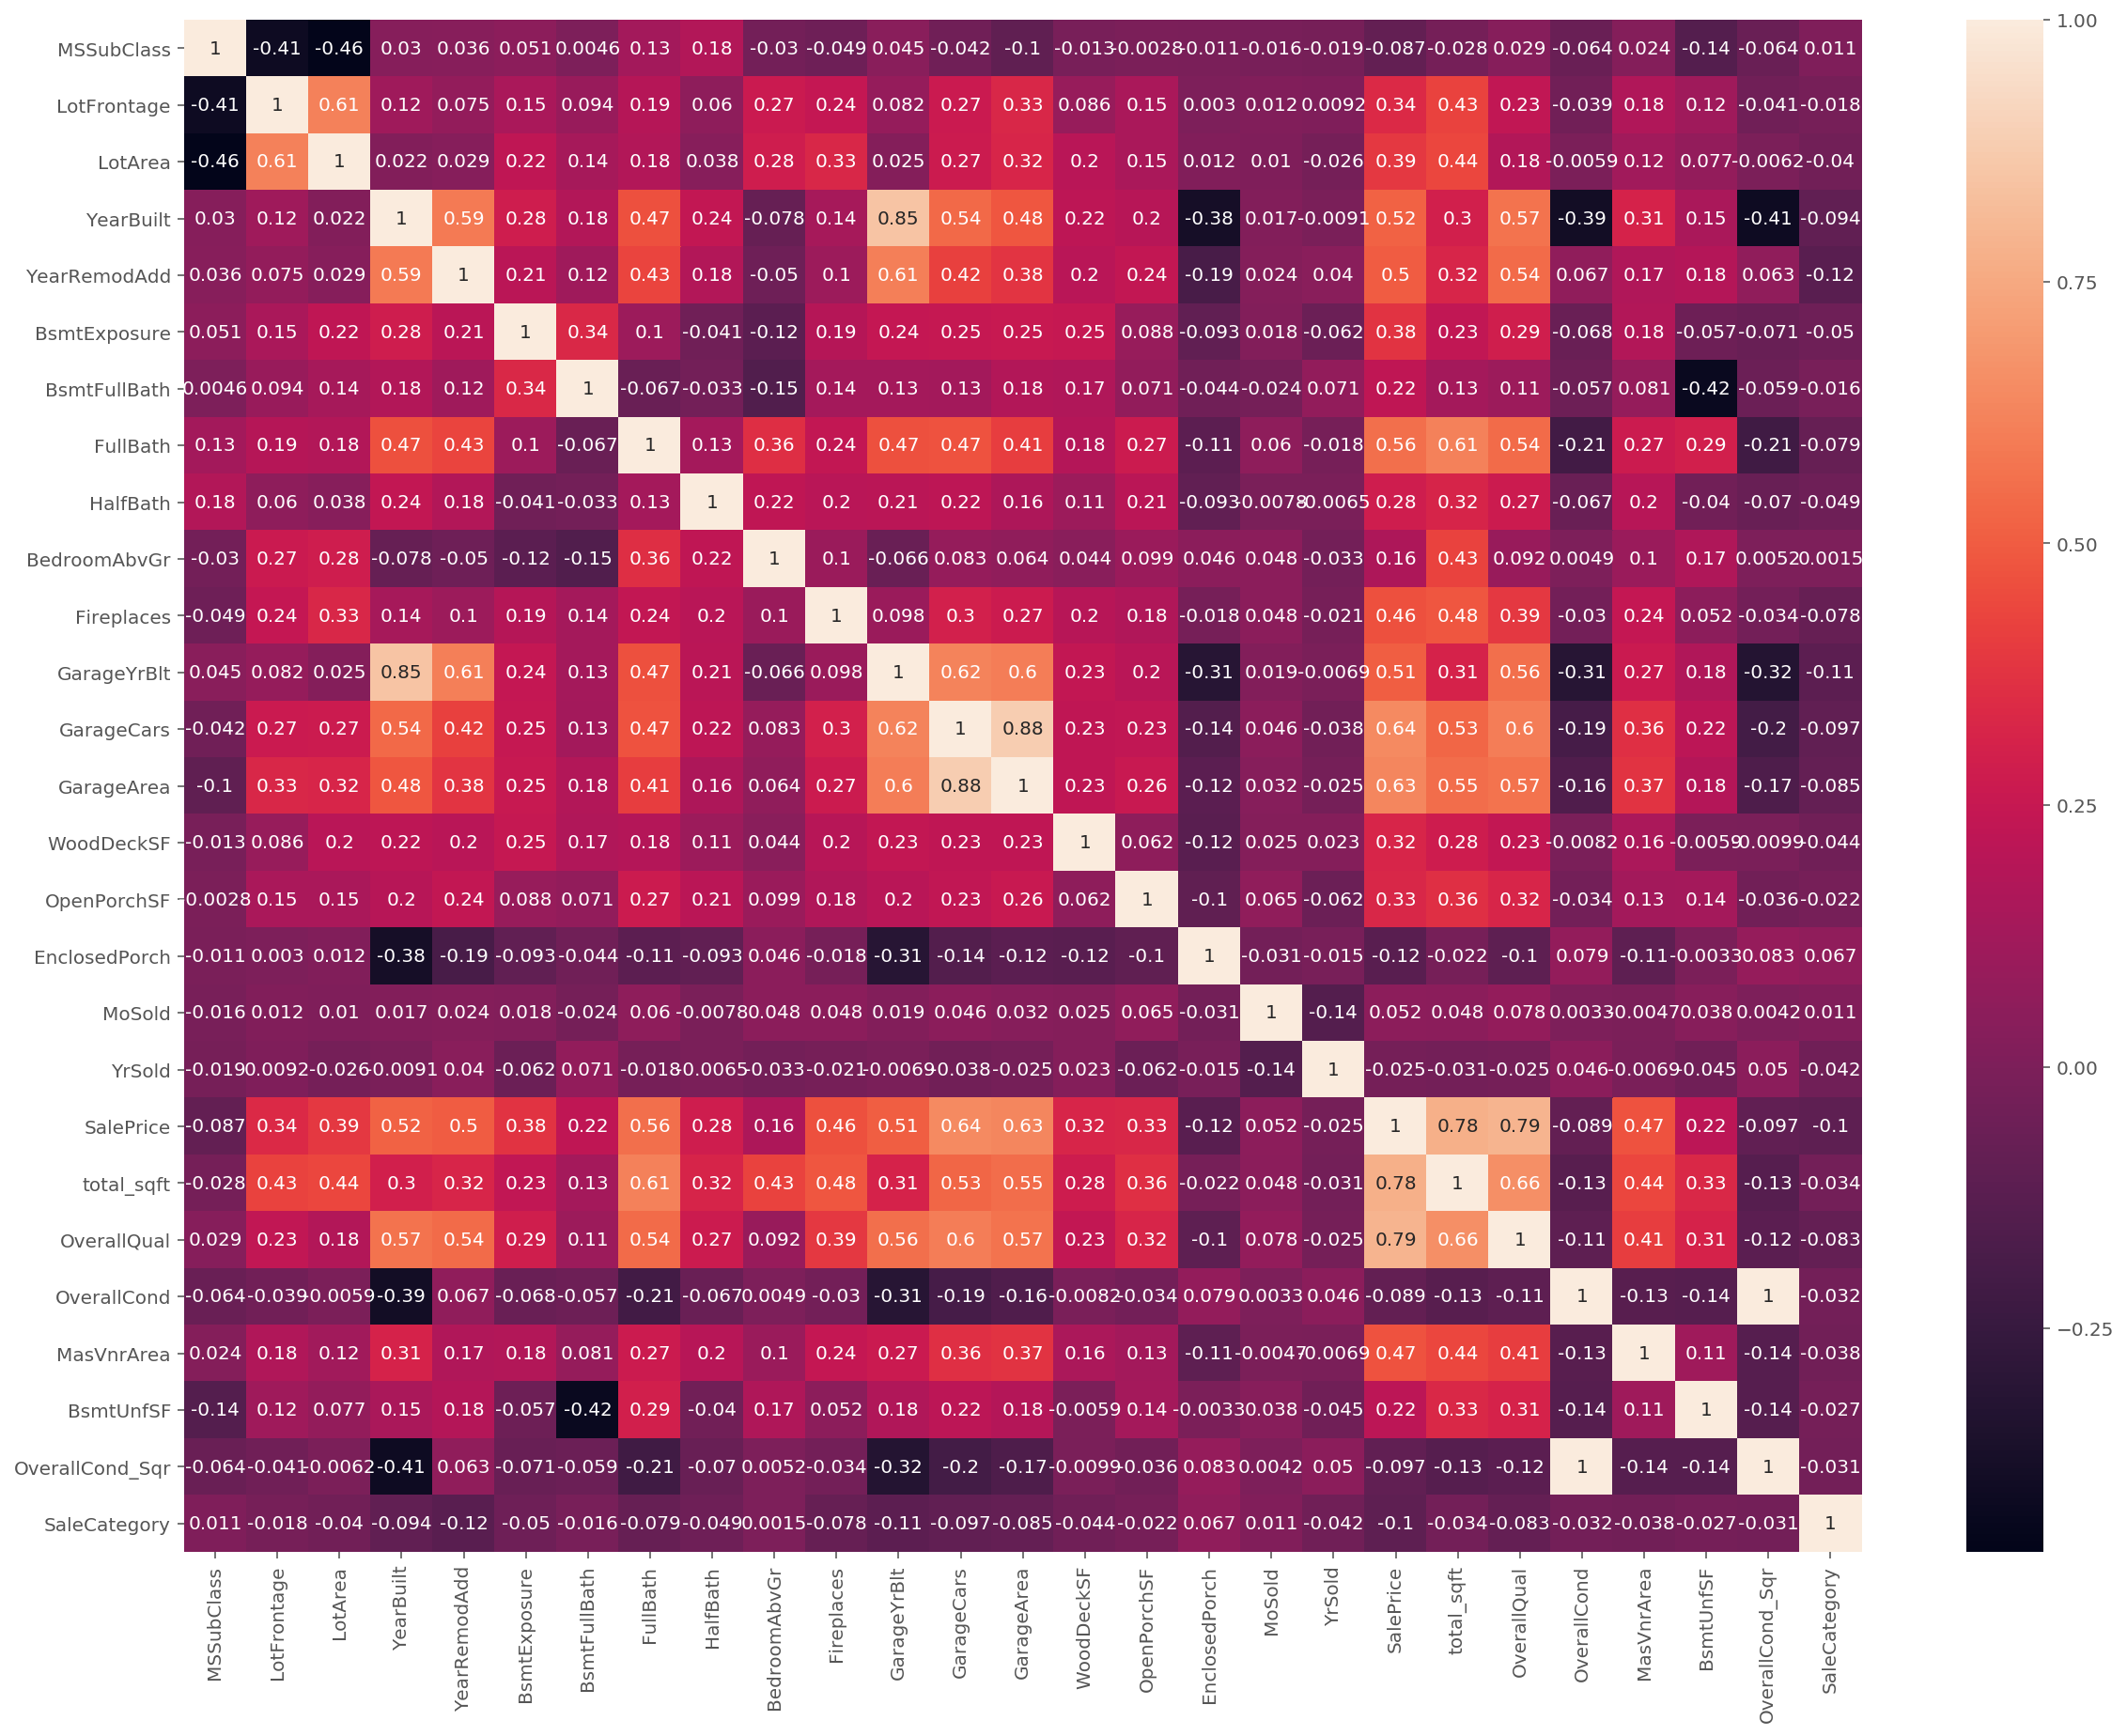

In [128]:
#Very little correlation to Sale Category so will add all of them to the algo for now. 
plt.figure(figsize=(20,15))
sns.heatmap(house_full_clean.corr(), annot=True)

### Predictor matrix and dependent variable

In [129]:
X = house_full_clean.copy()
y = X.pop('SaleCategory')
X.pop('SaleCondition')

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
5        Normal
6        Normal
7        Normal
8       Abnorml
9        Normal
10       Normal
11      Partial
12       Normal
13      Partial
14       Normal
15       Normal
16       Normal
17       Normal
18       Normal
19      Abnorml
20      Partial
21       Normal
22       Normal
23       Normal
24       Normal
25       Normal
26       Normal
27       Normal
28       Normal
29       Normal
31       Normal
32       Normal
33       Normal
34       Normal
35       Normal
36       Normal
37       Normal
38      Abnorml
39      AdjLand
40      Abnorml
41       Normal
42       Normal
43       Normal
44       Normal
45       Normal
46      Abnorml
47       Normal
48      Partial
49       Normal
50       Normal
51       Normal
52       Normal
53       Normal
54       Normal
55       Normal
56      Abnorml
57       Normal
58      Partial
59       Normal
60      Partial
61       Normal
62       Normal
63      

### Dummifying variables

In [130]:
#Going to try all of them seeing for now 
X.select_dtypes(include='object').columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual',
       'GarageType', 'SaleType', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'Fence'],
      dtype='object')

In [131]:
X_dum = pd.get_dummies(X, drop_first=True)

### Splitting and scaling the data


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, stratify = y, random_state = 1)

In [133]:
stdscaler = StandardScaler()
X_train_std = pd.DataFrame(stdscaler.fit_transform(X_train), columns = X_train.columns)
X_test_std = pd.DataFrame(stdscaler.transform(X_test), columns = X_train.columns)

In [134]:
print(X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape)

(1160, 189) (290, 189) (1160,) (290,)


### Logisitic Regression using GridSearch

In [136]:
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')

In [ ]:
lr_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-3, 0, 10)}

lr_gridsearch = GridSearchCV(logreg,
                             lr_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

In [ ]:
#lr_gridsearch.fit(X_train_std, y_train)

In [ ]:
print(lr_gridsearch.best_params_)
best_logreg = lr_gridsearch.best_estimator_

In [ ]:
print(f'Best log reg train score: {best_logreg.score(X_train_std, y_train)}')
print(f'Best log reg test score: {best_logreg.score(X_test_std, y_test)}')
print(f'Best log reg mean cv score: {lr_gridsearch.best_score_}')

In [ ]:
'''logreg = LogisticRegressionCV(Cs = np.logspace(-3, 0, 15), penalty = 'l1', solver='liblinear', multi_class='ovr')
logreg.fit(X_train_std, y_train)
print(f'Train Score: {logreg.score(X_train_std, y_train)}')
print(f'Test Score: {logreg.score(X_test_std, y_test)}')
print(f'Model coef: {logreg.coef_}')
print(f'Model thres: {logreg.intercept_}')'''

In [ ]:
predictions = best_logreg.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions,
                               labels=[0,1])

In [ ]:
conf_mat_pd = pd.DataFrame(conf_matrix, 
                           index = ['acc_normal', 'acc_abnormal'], 
                           columns = ['pred_normal', 'pred_abnormal'] )
conf_mat_pd

### LogRegCV optimising precision & recall score

In [147]:
#Seeing as you cannot choose scoring with LogReg and hence cannot do GridSearchCV for this

logregCV = LogisticRegressionCV(Cs = np.logspace(-3, 0, 20), penalty = 'l1',
                              scoring = 'precision_macro',
                              solver='liblinear', multi_class='ovr')
logregCV.fit(X_train_std, y_train)
print(f'Train Score: {logregCV.score(X_train_std, y_train)}')
print(f'Test Score: {logregCV.score(X_test_std, y_test)}')
print(f'Model coef: {logregCV.coef_}')
print(f'Model thres: {logregCV.intercept_}')
print(f'Model C: {logregCV.C_}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-pa

Train Score: 0.9684256055363322
Test Score: 0.4672413793103448
Model coef: [[ 0.          0.          0.          0.         -0.00153455  0.
   0.          0.          0.          0.          0.         -0.04643772
   0.          0.          0.          0.          0.          0.
   0.         -0.0222973   0.          0.          0.          0.
   0.          0.          0.10943577  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00722664
   0.          0.          0.          0.          

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/m

In [151]:
predictions = logregCV.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

conf_matrix = confusion_matrix(y_test, predictions,
                               labels=[0,1])

conf_mat_pd = pd.DataFrame(conf_matrix, 
                           index = ['acc_normal', 'acc_abnormal'], 
                           columns = ['pred_normal', 'pred_abnormal'] )
conf_mat_pd

              precision    recall  f1-score   support

           0     0.9345    1.0000    0.9661       271
           1     0.0000    0.0000    0.0000        19

    accuracy                         0.9345       290
   macro avg     0.4672    0.5000    0.4831       290
weighted avg     0.8733    0.9345    0.9028       290



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pred_normal  pred_abnormal
acc_normal            271              0
acc_abnormal           19              0

In [153]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### KNN with GridSearchCV

In [161]:
knn_params = {
    'n_neighbors': [4, 5, 6, 7, 8],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn,
                              knn_params,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [4, 5, 6, 7, 8],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [162]:
print(knn_gridsearch.best_score_)

0.9344827586206896


In [163]:
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

In [164]:
best_knn = knn_gridsearch.best_estimator_

In [166]:
print(f'Train Score: {best_knn.score(X_train_std, y_train)}')
print(f'Test Score: {best_knn.score(X_test_std, y_test)}')

Train Score: 1.0
Test Score: 0.9310344827586207


In [167]:
predictions = best_knn.predict(X_test)
print(classification_report(y_test, predictions, digits=4))

conf_matrix = confusion_matrix(y_test, predictions,
                               labels=[0,1])

conf_mat_pd = pd.DataFrame(conf_matrix, 
                           index = ['acc_normal', 'acc_abnormal'], 
                           columns = ['pred_normal', 'pred_abnormal'] )
conf_mat_pd

              precision    recall  f1-score   support

           0     0.9345    1.0000    0.9661       271
           1     0.0000    0.0000    0.0000        19

    accuracy                         0.9345       290
   macro avg     0.4672    0.5000    0.4831       290
weighted avg     0.8733    0.9345    0.9028       290



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


pred_normal  pred_abnormal
acc_normal            271              0
acc_abnormal           19              0

### SMOTE

In [2]:
from imblearn.over_sampling import SMOTE